In [1]:
import sys
import numpy as np
import scipy
import scipy.io
from pyDOE import lhs
from torch import Tensor, ones, stack, load
from torch.autograd import grad
from torch.utils.data import Dataset
import mintegpy as mp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py as h5
import os#
import torch
sys.path.append('/Users/juanesteban')
import PINNFramework as pf
import sympy as sp
from mpl_toolkits.mplot3d import Axes3D 
sys.path.insert(1, '/Users/juanesteban/minterpy/src')
import minterpy as mp
import itertools

Was not able to import Horovod. Thus Horovod support is not enabled


### Define the Simulation Parameters

In [29]:
e_l = 2 # n-th eigenvalue of analytical solution
#Parameters for
DIM = 2 
DEG = 10
LP=2
POINTKIND = 'gauss_leg'#'leja'
USEDATA = False
#Doamin Bounds
lb = np.array([-1.0, -1.0, 0.0])
ub = np.array([1.0, 1.0, 0])
# Number of Epoch
n_epoch = 10000
#Create 2-D Datast from the analytical solution

In [30]:
def set_gen_1d(POLYDEG,n_bdy):
    unscaled_pts = np.polynomial.legendre.leggauss(POLYDEG)
    scaled_pts = []
    weights = []
    for i in range(3):
        if (n_bdy[1][i]-n_bdy[0][i])/2 == 0:
            arg_min = [k for k,j in enumerate(unscaled_pts[0]) if abs(j-n_bdy[1][i]) ==
                       min(abs(unscaled_pts[0]-n_bdy[1][i]))]
            scaled_pts.append(unscaled_pts[0][arg_min])
            weights.append([1])
        else:
            m = (n_bdy[1][i]-n_bdy[0][i])/2
            b = (n_bdy[0][i]+n_bdy[1][i])/2
            scaled_pts.append(unscaled_pts[0]*m+b)
            weights.append(unscaled_pts[1]*m)
    Grid = np.array([[[[scaled_pts[0][i],scaled_pts[1][j],scaled_pts[2][k]]
                   for i in range(len(scaled_pts[0]))]for j in range(len(scaled_pts[1]))]
                 for k in range(len(scaled_pts[2]))]).reshape(len(scaled_pts[0])
                                                              *len(scaled_pts[1])*
                                                              len(scaled_pts[2]),3)
    Weights = np.array([[[weights[0][i]*weights[1][j]*weights[2][k]
                   for i in range(len(weights[0]))]for j in range(len(weights[1]))]
                 for k in range(len(weights[2]))]).reshape(len(weights[0])
                                                              *len(weights[1])*
                                                              len(weights[2]))
    return Grid, Weights

In [31]:
#from scipy.integrate import quad
#ev = 0
#a =  sp.Symbol('a')
#b =  sp.Symbol('b')
#c =  sp.Symbol('c')
#Hna = sp.hermite(ev,a)
#Hnb = sp.hermite(ev,b)
#Psi = (1/((2**e_l*sp.factorial(ev))**(1/2))*(np.pi**(-1/4))*
# sp.exp(-(a**2+b**2)/2)*Hna*Hnb)
#psi_f = sp.lambdify((a,b),Psi)
#from scipy import integrate
#integrate.dblquad(psi_f, -1, 1, lambda x: 0, lambda x: 1)

#### Dataset Generating fuctions

In [32]:
#Create 2-D Dataset from the analytical solution
def Herm_pol(n):
    p =  sp.Symbol('p')
    Hn = sp.lambdify(p,sp.hermite(n, p))
    return Hn

def eigenvalue (ev):
    a =  sp.Symbol('a')
    b =  sp.Symbol('b')
    c =  sp.Symbol('c')
    Hna = sp.hermite(ev,a)
    Hnb = sp.hermite(ev,b)
    Psi = (1/((2**e_l*sp.factorial(ev))**(1/2))*(np.pi**(-1/4))*
     sp.exp(-(a**2+b**2)/2)*Hna*Hnb)
    return int(sp.simplify((-1/2*(sp.diff(Psi,a,a)+sp.diff(Psi,b,b))+
                            1/2*(a**2+b**2)*Psi)/Psi))
lam = eigenvalue(e_l)
def Psi (x,y,t,f):
    x = torch.Tensor(x)
    y= torch.Tensor(y)
    Hn= Herm_pol(e_l)
    psi_t = torch.exp(torch.complex(torch.Tensor([0]),torch.Tensor([0])))
    #1/(1+10*(x**2+y**2))#
    return 1/((2**e_l*scipy.math.factorial(e_l))**(1/2))*(np.pi**(-1/4))*torch.exp(-(x**2+y**2)/2)*Hn(x)*Hn(y)
def set_gen_1d(POLYDEG,n_bdy):
    unscaled_pts = np.polynomial.legendre.leggauss(POLYDEG)
    scaled_pts = []
    weights = []
    for i in range(3):
        if (n_bdy[1][i]-n_bdy[0][i])/2 == 0:
            arg_min =[k for k,j in enumerate(unscaled_pts[0]) if abs(j-n_bdy[1][i]) ==
                       min(abs(unscaled_pts[0]-n_bdy[1][i]))] #[k for k,j in enumerate(unscaled_pts[0]) if j-n_bdy[1][i] ==
            #           min(unscaled_pts[0]-n_bdy[1][i])]
            scaled_pts.append([unscaled_pts[0][arg_min[0]]])
            weights.append([1])
        else:
            m = (n_bdy[1][i]-n_bdy[0][i])/2
            b = (n_bdy[0][i]+n_bdy[1][i])/2
            scaled_pts.append(unscaled_pts[0]*m+b)
            weights.append(unscaled_pts[1]*m)
    Grid = np.array([[[[scaled_pts[0][i],scaled_pts[1][j],scaled_pts[2][k]]
                   for i in range(len(scaled_pts[0]))]for j in range(len(scaled_pts[1]))]
                 for k in range(len(scaled_pts[2]))]).reshape(len(scaled_pts[0])
                                                              *len(scaled_pts[1])*
                                                              len(scaled_pts[2]),3)
    Weights = np.array([[[weights[0][i]*weights[1][j]*weights[2][k]
                   for i in range(len(weights[0]))]for j in range(len(weights[1]))]
                 for k in range(len(weights[2]))]).reshape(len(weights[0])
                                                              *len(weights[1])*
                                                              len(weights[2]))
    return Grid, Weights

def set_gen_sob(POLYDEG,n_bdy, uns_points, uns_weights):
    #unscaled_pts = np.polynomial.legendre.leggauss(POLYDEG)
    scaled_pts = []
    weights = []
    for i in range(3):
        if (n_bdy[1][i]-n_bdy[0][i])/2 == 0:
            arg_min = [k for k,j in enumerate(uns_points) if j-n_bdy[1][i] == min(uns_points-n_bdy[1][i])]
            scaled_pts.append(uns_points[arg_min])
            weights.append([1])
        else:
            m = (n_bdy[1][i]-n_bdy[0][i])/2
            b = (n_bdy[0][i]+n_bdy[1][i])/2
            scaled_pts.append(uns_points*m+b)
            weights.append(np.multiply(uns_weights,m))
    Grid = np.array([[[[scaled_pts[0][i],scaled_pts[1][j],scaled_pts[2][k]]
                   for i in range(len(scaled_pts[0]))]for j in range(len(scaled_pts[1]))]
                 for k in range(len(scaled_pts[2]))]).reshape(len(scaled_pts[0])
                                                              *len(scaled_pts[1])*
                                                              len(scaled_pts[2]),3)
    Weights = np.array([[[weights[0][i]*weights[1][j]*weights[2][k]
                   for i in range(len(weights[0]))]for j in range(len(weights[1]))]
                 for k in range(len(weights[2]))]).reshape(len(weights[0])
                                                              *len(weights[1])*
                                                              len(weights[2]))
    return Grid, Weights
def MSE_set(n_bdy,  nb, x_dim=1, y_dim=1, nsteps=1, dt=0.1):
    x_0 = np.linspace(n_bdy[0][0], n_bdy[1][0], x_dim)
    y_0 = np.linspace(n_bdy[0][1], n_bdy[1][1], y_dim)
    X, Y = np.meshgrid(x_0, y_0)
    X_0 = X.reshape(-1)
    Y_0 = Y.reshape(-1)
    idx_x = np.random.choice(len(X_0), nb, replace=False)
    x = np.array([X_0[idx_x]]).T
    y = np.array([Y_0[idx_x]]).T
    T = np.zeros(x.shape)
    return np.array(np.concatenate([x,y,T], axis=1))


class BoundaryConditionDataset(Dataset):

    def __init__(self, boundary_set) -> object:
        """_bdy, x_dim, y_dim, nsteps, d
        Constructor of the Boundary condition dataset, with x_bdy an array with the
        lower and uper bound in the x direction and respectively y_bdy. Only for square domain.
        """
        self.Bdy_training = boundary_set
    def __getitem__(self, idx):
        """
        Returns data for initial state
        """
        return Tensor(self.Bdy_training).float()

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1
class InitialConditionDataset(Dataset):

    def __init__(self,initial_set, norm = 'L2', n_bdy=[], x_dim=1, y_dim=1, nx =1 ):
        """
        Constructor of the boundary condition dataset
        Args:
          n0 (int)
        """
        super(type(self)).__init__()
        if norm =='Mse' or norm== 'Wass':
            x_0 = np.linspace(n_bdy[0][0], n_bdy[1][0], x_dim)
            y_0 = np.linspace(n_bdy[0][1], n_bdy[1][1], y_dim)
            X, Y = np.meshgrid(x_0, y_0)
            X_0 = X.reshape(-1)
            Y_0 = Y.reshape(-1)
            idx_x = np.random.choice(len(X_0), nx, replace=False)
            self.x = np.array([X_0[idx_x]]).T
            self.y = np.array([Y_0[idx_x]]).T
            sol = Psi(self.x, self.y, 0, 1)  # Psi(x,y,t=0,f)
            self.u = sol
            self.t = np.array([np.zeros(len(self.x))]).T
        elif norm == 'Quad' or norm == 'Sobolev_1':
            X = np.array(initial_set[0])
            Y = np.array(initial_set[1])
            #X, Y = np.meshgrid(x_0, y_0)
            self.x = np.array([X.reshape(-1)]).T
            self.y = np.array([Y.reshape(-1)]).T
            sol = Psi(self.x,self.y,0,1)
            self.u = sol
            self.t = np.array([np.zeros(len(self.x))]).T
        else:
            raise ValueError('Norm not defined')
    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1

    def __getitem__(self,idx):
        x = np.concatenate([self.x,self.y,self.t],axis=1)
        y = self.u
        return Tensor(x).float(), Tensor(y).float()

class PDEDataset(Dataset):
    def __init__(self, residual_set):
        self.xf = np.array(residual_set).T
    def __getitem__(self, idx):
        """
        Returns data for initial state
        """
        return Tensor(self.xf).float()

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1


#### Definition and creation of the different datasets and losses

In [33]:
def Hk_coeff(deg, k_sob):
    mi = mp.multi_index.MultiIndex.from_degree(spatial_dimension=2, poly_degree=deg, lp_degree=np.inf)
    ord_grid =mp.grid.Grid(mi).unisolvent_nodes
    can_bdy = np.array([[-1, -1, 0], [1, 1, 0]])
    residual_bdy = can_bdy
    un_grid = set_gen_sob(deg+1, can_bdy, 
                         np.polynomial.legendre.leggauss(deg+1)[0],
                         np.polynomial.legendre.leggauss(deg+1)[1])[0]
    un_weights = set_gen_sob(deg+1, can_bdy, 
                         np.polynomial.legendre.leggauss(deg+1)[0],
                         np.polynomial.legendre.leggauss(deg+1)[1])[1]#np.polynomial.legendre.leggauss(n+1)[1]
    ord_index = [[ i for i,j in enumerate(un_grid) if j[0] == ord_grid[k][0] and 
                 j[1] == ord_grid[k][1]][0] for k in range(len(ord_grid))]
    ord_sc_weights = un_weights[ord_index]
    ord_sc_grid = un_grid[ord_index]
    W_HK = []
    if k_sob == 1 or k_sob == 2 or k_sob ==3 or k_sob==4:
        coeff_L_x = []
        coeff_L_y = []
        for i in range(len(mi)):
            alpha = np.zeros(len(mi))
            alpha[i] = 1 
            #custom_grid = mp.Grid(mi,generating_values = grid_r[0][:,0])
            lag_poly = mp.LagrangePolynomial(alpha, mi)
            derivator_lag_poly = mp.Derivator(lag_poly, mp.LagrangePolynomial)
            d_c = derivator_lag_poly.get_gradient_poly().coeffs
            #alpha = np.divide(1,(1+d_c))
            #sobolev_w = np.divide(lag_poly.coeffs,2)
            coeff_L_x.append(d_c[:,0])
            coeff_L_y.append(d_c[:,1])
        h_w_x = torch.einsum('ab,b->ab',
                 torch.tensor(coeff_L_x),torch.Tensor(ord_sc_weights))
        h_w_y = torch.einsum('ab,b->ab',
                     torch.tensor(coeff_L_y),torch.Tensor(ord_sc_weights))
        H_x = torch.einsum('ab,cb->ac',torch.tensor(coeff_L_x), h_w_x)
        H_y = torch.einsum('ab,cb->ac',torch.tensor(coeff_L_y), h_w_y)
        H_1 = [H_x, H_y]
        W_HK.append(H_1)
        if k_sob == 2 or k_sob ==3 or k_sob==4:
            HxH_x=torch.einsum('ab,cd->abcd',torch.tensor(coeff_L_x),torch.tensor(coeff_L_x))
            HxH_y=torch.einsum('ab,cd->abcd',torch.tensor(coeff_L_y),torch.tensor(coeff_L_y))
            HxH = [HxH_x, HxH_y]
            ind_H2 = [[0,0],[0,1],[1,1]]
            H_2 = []
            for i in range(len(ind_H2)):
                H_2.append(torch.einsum('abcd,bd->ac',HxH[ind_H2[i][0]],H_1[ind_H2[i][1]]))
            W_HK.append(H_2)
            if  k_sob == 3 or k_sob == 4:
                H_3 = []
                ind_H3 = [[0,0], [0,1],[0,2],[1,0],[1,2]]
                for i in range(len(ind_H3)):
                    H_3.append(torch.einsum('abcd,bd->ac',
                                            HxH[ind_H3[i][0]],H_2[ind_H3[i][1]]))
                W_HK.append(H_3)
                if k_sob == 4:
                    H_4 = []
                    ind_H4 = [[0,0],[0,1],[0,2],[0,3],[0,4],[1,0],[1,3],[1,4]]
                    for i in range(len(ind_H4)):
                        H_4.append(torch.einsum('abcd,bd->ac',HxH[ind_H4[i][0]],
                                                H_3[ind_H4[i][1]]))
                    W_HK.append(H_4)
    return ord_sc_grid.T, ord_sc_weights, W_HK
def Hk_coeff_bdy(deg, k_sob):
    mi = mp.multi_index.MultiIndex.from_degree(spatial_dimension=1, poly_degree=deg, lp_degree=np.inf)
    ord_grid =mp.grid.Grid(mi).unisolvent_nodes.T[0]
    un_grid , un_weights = np.polynomial.legendre.leggauss(deg+1)
    ord_index = [[ i for i,j in enumerate(un_grid) if j == ord_grid[k]][0]
                 for k in range(len(ord_grid))]
    ord_sc_weights = un_weights[ord_index]
    ord_sc_grid = un_grid[ord_index]
    weights = []
    if k_sob == 1 or k_sob == 2 or k_sob ==3 or k_sob==4:
        coeff_L_x = []
        for i in range(len(mi)):
            alpha = np.zeros(len(mi))
            alpha[i] = 1 
            lag_poly = mp.LagrangePolynomial(alpha, mi)
            derivator_lag_poly = mp.Derivator(lag_poly, mp.LagrangePolynomial)
            d_c = derivator_lag_poly.get_gradient_poly().coeffs
            coeff_L_x.append(d_c[:,0])
        h_w_x = torch.einsum('ab,b->ab',
                 torch.tensor(coeff_L_x),torch.Tensor(ord_sc_weights))
        H_1 = torch.einsum('ab,cb->ac',torch.tensor(coeff_L_x), h_w_x)
        weights.append(H_1)
        if k_sob == 2 or k_sob ==3 or k_sob==4:
            HxH_x=torch.einsum('ab,cd->abcd',torch.tensor(coeff_L_x),torch.tensor(coeff_L_x)) 
            H_2 = torch.einsum('abcd,bd->ac',HxH_x,H_1)
            weights.append(H_2)
            if  k_sob == 3 or k_sob == 4:
                H_3 = torch.einsum('abcd,bd->ac',HxH_x,H_2)
                weights.append(H_3)
                if k_sob == 4:
                    H_4 = torch.einsum('abcd,bd->ac',HxH_x,H_3)
                    weights.append(H_4)
    return ord_sc_grid, ord_sc_weights, weights

In [34]:
if __name__ == "__main__":
    # Domain bounds
    #Create Datasets for the different Losses
    def schroedinger1d(x, u):
        global lam
        omega = 1
        pred = u
        u = pred[:, 0]
        #v = pred[:, 1]
        grads = ones(u.shape, device=pred.device)  # move to the same device as prediction
        grad_u = grad(u, x, create_graph=True, grad_outputs=grads)[0]
        #grad_v = grad(v, x, create_graph=True, grad_outputs=grads)[0]

        # calculate first order derivatives
        u_x = grad_u[:, 0]
        u_y = grad_u[:, 1]
        u_t = grad_u[:, 2]
        # v_x = grad_v[:, 0]
        #v_y = grad_v[:, 1]
        #v_t = grad_v[:, 2]
        # calculate second order derivatives
        grad_u_x = grad(u_x, x, create_graph=True, grad_outputs=grads)[0]
        #grad_v_x = grad(v_x, x, create_graph=True, grad_outputs=grads)[0]
        u_xx = grad_u_x[:, 0]
        u_yy = grad_u_x[:, 1]
        #v_xx = grad_v_x[:, 0]
        #v_yy = grad_v_x[:, 1]
        f_r = -1/2*(u_xx + u_yy) + 1/2*(x[:, 0] ** 2 + x[:, 1] ** 2)*u - lam*u
        #print(torch.mean((-1/2*(u_xx - u_yy) + 1/2*(x[:, 0] ** 2 + x[:, 1] ** 2)*u)/u),torch.std((-1/2*(u_xx - u_yy) + 1/2*(x[:, 0] ** 2 + x[:, 1] ** 2)*u)/u))
        #f_u = -1 * u_t - 0.5 * v_xx - 0.5 * v_yy + omega * 0.5 * (x[:, 0] ** 2) * v + omega * 0.5 * (x[:, 1] ** 2) * v
        # fv is the imaginary part of the schrodinger equation
        #f_v = -1 * v_t + 0.5 * u_xx + 0.5 * u_yy - omega * 0.5 * (x[:, 0] ** 2) * u - omega * 0.5 * (x[:, 1] ** 2) * u
        return f_r#stack([f_u, f_v], 1)  # concatenate real part and imaginary part
    def res_left(x, u):
        omega = 1
        pred = u
        u = pred#pred[:, 0]
        f_left =  lam*u
        return f_left
    def res_right(x, u):
        omega = 1
        pred = u
        u = pred[:, 0]
        #v = pred[:, 1]
        grads = ones(u.shape, device=pred.device)  # move to the same device as prediction
        grad_u = grad(u, x, create_graph=True, grad_outputs=grads)[0]
        #grad_v = grad(v, x, create_graph=True, grad_outputs=grads)[0]

        # calculate first order derivatives
        u_x = grad_u[:, 0]
        u_y = grad_u[:, 1]
        u_t = grad_u[:, 2]
        #v_x = grad_v[:, 0]
        #v_y = grad_v[:, 1]
        #v_t = grad_v[:, 2]
        # calculate second order derivatives
        grad_u_x = grad(u_x, x, create_graph=True, grad_outputs=grads)[0]
        #grad_v_x = grad(v_x, x, create_graph=True, grad_outputs=grads)[0]
        u_xx = grad_u_x[:, 0]
        u_yy = grad_u_x[:, 1]
        #v_xx = grad_v_x[:, 0]
        #v_yy = grad_v_x[:, 1]
        f_right = -1/2*(u_xx + u_yy) + 1/2*(x[:, 0] ** 2 + x[:, 1] ** 2)*u       
        return f_right
    def hom_dir(x):
        P = Psi(x[:,0], x[:,1], x[:,2], 1)
        #P_r = P.real
        #P_im = P.imag
        return P# torch.stack((P_r,P_im),1)
    def Dataset_loss (Norm, bounds , n_points, deg = 1):
        [lb, ub] = bounds
        residual_bdy = [[lb[0], lb[1], lb[2]], [ub[0], ub[1], ub[2]]]
        initial_bdy = [[lb[0], lb[1], lb[2]], [ub[0], ub[1], lb[2]]]
        boundary_bdy = [[[lb[0], lb[1], lb[2]], [lb[0], ub[1], ub[2]]], [[ub[0], lb[1], lb[2]], [ub[0], ub[1], ub[2]]],
                        [[lb[0], lb[1], lb[2]], [ub[0], lb[1], ub[2]]],
                        [[lb[0], ub[1], lb[2]], [ub[0], ub[1], ub[2]]]]
        if Norm == 'Mse' or Norm == 'Wass':
            boundary_set = np.concatenate([MSE_set(boundary_bdy[i], nb= int(n_points/4),
                                                       x_dim=1000, y_dim=1000, nsteps=1, dt=0.1) for i in range(4)], axis=0)
            boundary_set = np.concatenate([set_gen_1d(deg, boundary_bdy[i])[0] for i in range(4)], axis=0)
            residual_set = MSE_set(residual_bdy, nb= n_points, x_dim=1000, y_dim=1000, nsteps=1, dt=0.1).T
            RS_1d = set_gen_1d(deg, residual_bdy)
            residual_set = RS_1d[0].T
            initial_set = []
            Datasets = [[boundary_set, residual_set, initial_set],[[0],[0],[0]]]
        elif Norm == 'Quad':
            I_C_1d = set_gen_1d(deg, initial_bdy)
            initial_set = I_C_1d[0].T
            initial_weights = I_C_1d[1]
            boundary_set = np.concatenate([set_gen_1d(deg, boundary_bdy[i])[0] for i in range(4)], axis=0)
            boundary_weights = np.concatenate([set_gen_1d(deg, boundary_bdy[i])[1] for i in range(4)], axis=0)
            #boundary_set, boundary_weights, Hb_x, Hb_y,  Hb_xx, Hb_xy, Hb_yy = H1_coeff_bdy(deg)
            RS_1d = set_gen_1d(deg, residual_bdy)
            residual_set = RS_1d[0].T
            residual_weights = RS_1d[1]
            #Hb_x, Hb_y,Hb_xx, Hb_xy, Hb_yy = [[],[],[],[],[]]
            Datasets = [[boundary_set, residual_set, initial_set],[boundary_weights, residual_weights, initial_weights]]
        elif Norm == 'Sobolev_1':
            initial_set, initial_weights, Hkw_ini = Hk_coeff(deg,2)
            residual_set, res_weights , Hkw_res = Hk_coeff(deg,2)
            #Create Boundary Set
            boundary_set, boundary_weights, Hkw_bdy = Hk_coeff_bdy(int(deg*deg/4), 1)
            #boundary_set = np.concatenate([set_gen_1d(deg, boundary_bdy[i])[0] for i in range(4)], axis=0)
            #boundary_weights = np.concatenate([set_gen_1d(deg, boundary_bdy[i])[1] for i in range(4)], axis=0)
            Datasets = [[boundary_set, residual_set, initial_set],
                        [[boundary_weights, Hkw_bdy], 
                         [res_weights , Hkw_res],
                         [initial_weights, Hkw_ini]]]
            ### CREATE THE LOSS FUNCTIONS
        else:
            raise(ValueError('Loss not defined'))
        
        ## Crete Loss functions
        #Boundary term
        bc_dataset = BoundaryConditionDataset(Datasets[0][0])
        dirichlet_bc = pf.DirichletBC(func=hom_dir, dataset=bc_dataset,
                                      quad_weights=Datasets[1][0],sob_weights=Datasets[1][0]
                                      , name='Dirichlet BC', 
                                      norm=Norm,reg_param_w = 0.2)
        # Residual Terms
        pde_dataset = PDEDataset(Datasets[0][1])
        pde_loss = pf.PDELoss(pde_dataset, schroedinger1d,
                              func_left = res_left, func_right = res_right,
                              quad_weights=Datasets[1][1],sob_weights=Datasets[1][1], 
                              norm=Norm,reg_param_w = 0.2)
        #print(np.array(Datasets[0][2]).shape)
        #Initial Condition Term
        ic_dataset = InitialConditionDataset(Datasets[0][2], norm=Norm, n_bdy=initial_bdy, x_dim=1000, y_dim=1000, nx=n_points)
        initial_condition = pf.InitialCondition(ic_dataset,  quad_weights=Datasets[1][2], 
                                                norm=Norm, sob_weights=Datasets[1][2])
        #test_loss = tl.My_Loss(ic_dataset,  quad_weights=Datasets[1][2], norm=Norm)
        return [dirichlet_bc, pde_loss, initial_condition], [bc_dataset, pde_dataset, ic_dataset], Datasets[1]

In [35]:
folder = '/Users/juanesteban/PhD_PINNs/Results_Simulation/31.05/'+str(e_l)+'_'+str(n_epoch)
# Call the datasets functions, losses and weights for the training and for the performance measure
[dirichlet_bc_2, pde_loss_2, initial_condition_2], [bc_dataset_2, pde_dataset_2, ic_dataset_2], [boundary_weights_2,
                                                                                     residual_weights_2,
                                                                                     initial_weights_2] = Dataset_loss('Quad', [lb, ub], 1, deg=DEG)
[dirichlet_bc, pde_loss, initial_condition], [bc_dataset, pde_dataset, ic_dataset], [boundary_weights,
                                                                                     residual_weights,
                                                                                     initial_weights] = Dataset_loss('Mse', [lb, ub], len(initial_weights_2), deg=DEG)
[dirichlet_bc_3, pde_loss_3, initial_condition_3], [bc_dataset_3, pde_dataset_3, ic_dataset_3], [boundary_weights_3,
                                                                                     residual_weights_3,
                                                                                     initial_weights_3] = Dataset_loss('Sobolev_1', [lb, ub], len(initial_weights_2), deg=DEG)
model_1 = pf.models.MLP(input_size=3, output_size=1, hidden_size=50, num_hidden=4, lb=lb, ub=ub)
model_2 = pf.models.MLP(input_size=3, output_size=1, hidden_size=50, num_hidden=4, lb=lb, ub=ub)
model_3 = pf.models.MLP(input_size=3, output_size=1, hidden_size=50, num_hidden=4, lb=lb, ub=ub)
performance_var = [initial_condition, [dirichlet_bc_3], pde_loss_3]
#pinn_1 = pf.PINN(model_1, 3, 1, pde_loss,initial_condition, performance_var, [dirichlet_bc_2], use_gpu=False)
#loss_1 = pinn_1.fit(n_epoch, 'Adam', 1e-3,
#                   pinn_path=folder+'best_model_Mse_'+str(DEG)+'_'+str(n_epoch)+'_.pt')
#pinn_2 = pf.PINN(model_2, 3, 1, pde_loss_2, initial_condition, performance_var, [dirichlet_bc_2] ,use_gpu=False)
#loss_2= pinn_2.fit(n_epoch, 'Adam', 1e-3,pinn_path=folder+
#                'best_model_Quad_'+str(DEG)+'_'+str(n_epoch)+'_.pt')
pinn_3 = pf.PINN(model_3, 3, 1, pde_loss_3, initial_condition, performance_var, [dirichlet_bc_3] ,use_gpu=False)
loss_3 = pinn_3.fit(n_epoch, 'Adam', 1e-3,
                    pinn_path = folder+'best_model_Wass_'+str(DEG)+'_'+str(n_epoch)+'_.pt')

/Users/juanesteban/minterpy/src/minterpy/verification.py:191: UserWarning: the highest encountered value in the given points is 0.9958857011456169  (expected 1.0). this may lead to unexpected behaviour, e.g. rank deficiencies in the regression matrices, etc. .
  f'the highest encountered value in the given points is {max_grid_val}  (expected 1.0). ' + DOMAIN_WARN_MSG)
/Users/juanesteban/minterpy/src/minterpy/verification.py:195: UserWarning: the smallest encountered value in the given points is -0.9958857011456169 (expected -1.0). this may lead to unexpected behaviour, e.g. rank deficiencies in the regression matrices, etc. .
  f'the smallest encountered value in the given points is {min_grid_val} (expected -1.0). ' + DOMAIN_WARN_MSG)


tensor(2.7967, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.8661, grad_fn=<PowBackward0>)
tensor(6.2626, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.4090, grad_fn=<AddBackward0>)
Measure Loss tensor(11.6124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2.7967, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.8661, grad_fn=<PowBackward0>)
tensor(6.2626, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.4090, grad_fn=<AddBackward0>)
PINN Loss 11.612398712572384 Epoch 0 from 10000
tensor(0.7870, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4765, grad_fn=<PowBackward0>)
tensor(6.2433, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.3824, grad_fn=<AddBackward0>)
Measure Loss tensor(8.8964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.7870, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4765, grad_fn=<PowBackward0>)
tensor(6.2433, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.3824, grad_fn=<AddBackward0>)
PINN Loss 8.8

tensor(0.5063, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6184, grad_fn=<PowBackward0>)
tensor(6.2261, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.1929, grad_fn=<AddBackward0>)
Measure Loss tensor(8.6110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.5063, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6184, grad_fn=<PowBackward0>)
tensor(6.2261, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.1929, grad_fn=<AddBackward0>)
PINN Loss 8.610994086737499 Epoch 16 from 10000
tensor(0.2336, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2872, grad_fn=<PowBackward0>)
tensor(6.2239, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.1611, grad_fn=<AddBackward0>)
Measure Loss tensor(8.0710, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2336, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2872, grad_fn=<PowBackward0>)
tensor(6.2239, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.1611, grad_fn=<AddBackward0>)
PINN Loss 8.07

tensor(6.2138, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.0380, grad_fn=<AddBackward0>)
Measure Loss tensor(8.0519, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3168, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2525, grad_fn=<PowBackward0>)
tensor(6.2138, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.0380, grad_fn=<AddBackward0>)
PINN Loss 8.051936704295759 Epoch 33 from 10000
tensor(0.3785, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3966, grad_fn=<PowBackward0>)
tensor(6.2136, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.0394, grad_fn=<AddBackward0>)
Measure Loss tensor(8.2413, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3785, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3966, grad_fn=<PowBackward0>)
tensor(6.2136, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.0394, grad_fn=<AddBackward0>)
PINN Loss 8.2413035707389 Epoch 34 from 10000
tensor(0.3690, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(

Measure Loss tensor(7.9447, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2657, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2388, grad_fn=<PowBackward0>)
tensor(6.2058, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9693, grad_fn=<AddBackward0>)
PINN Loss 7.944713274788991 Epoch 50 from 10000
tensor(0.2285, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1718, grad_fn=<PowBackward0>)
tensor(6.2052, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9645, grad_fn=<AddBackward0>)
Measure Loss tensor(7.8303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2285, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1718, grad_fn=<PowBackward0>)
tensor(6.2052, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9645, grad_fn=<AddBackward0>)
PINN Loss 7.8302728049383585 Epoch 51 from 10000
tensor(0.1567, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0445, grad_fn=<PowBackward0>)
tensor(6.2042, dtype=torch.float64, grad_fn=<AddBackward0>) tens

tensor(0.0659, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0377, grad_fn=<PowBackward0>)
tensor(6.1978, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9193, grad_fn=<AddBackward0>)
Measure Loss tensor(7.4167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0659, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0377, grad_fn=<PowBackward0>)
tensor(6.1978, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9193, grad_fn=<AddBackward0>)
PINN Loss 7.4167094719712185 Epoch 67 from 10000
tensor(0.2940, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1695, grad_fn=<PowBackward0>)
tensor(6.1986, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9279, grad_fn=<AddBackward0>)
Measure Loss tensor(7.8675, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2940, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1695, grad_fn=<PowBackward0>)
tensor(6.1986, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9279, grad_fn=<AddBackward0>)
PINN Loss 7.8

tensor(6.1923, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8905, grad_fn=<AddBackward0>)
Measure Loss tensor(7.5932, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1549, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0914, grad_fn=<PowBackward0>)
tensor(6.1923, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8905, grad_fn=<AddBackward0>)
PINN Loss 7.593176013048792 Epoch 85 from 10000
tensor(0.1046, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0471, grad_fn=<PowBackward0>)
tensor(6.1923, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8909, grad_fn=<AddBackward0>)
Measure Loss tensor(7.4578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1046, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0471, grad_fn=<PowBackward0>)
tensor(6.1923, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8909, grad_fn=<AddBackward0>)
PINN Loss 7.457832169321194 Epoch 86 from 10000
tensor(0.2009, dtype=torch.float64, grad_fn=<AddBackward0>) tenso

tensor(6.1863, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8737, grad_fn=<AddBackward0>)
Measure Loss tensor(7.4496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1287, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0399, grad_fn=<PowBackward0>)
tensor(6.1863, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8737, grad_fn=<AddBackward0>)
PINN Loss 7.449612915759179 Epoch 103 from 10000
tensor(0.0733, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1200, grad_fn=<PowBackward0>)
tensor(6.1856, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8693, grad_fn=<AddBackward0>)
Measure Loss tensor(7.5378, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0733, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1200, grad_fn=<PowBackward0>)
tensor(6.1856, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8693, grad_fn=<AddBackward0>)
PINN Loss 7.537775937649963 Epoch 104 from 10000
tensor(0.1267, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(0.1925, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0987, grad_fn=<PowBackward0>)
tensor(6.1803, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8617, grad_fn=<AddBackward0>)
PINN Loss 7.615282910362529 Epoch 121 from 10000
tensor(0.2322, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1081, grad_fn=<PowBackward0>)
tensor(6.1800, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8626, grad_fn=<AddBackward0>)
Measure Loss tensor(7.6699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2322, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1081, grad_fn=<PowBackward0>)
tensor(6.1800, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8626, grad_fn=<AddBackward0>)
PINN Loss 7.669902101018831 Epoch 122 from 10000
tensor(0.2529, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0857, grad_fn=<PowBackward0>)
tensor(6.1794, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8616, grad_fn=<AddBackward0>)
Measure Loss tensor(7.6532, dtype=tor

tensor(6.1745, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8528, grad_fn=<AddBackward0>)
PINN Loss 7.604708740833309 Epoch 138 from 10000
tensor(0.2983, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0979, grad_fn=<PowBackward0>)
tensor(6.1742, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8532, grad_fn=<AddBackward0>)
Measure Loss tensor(7.7090, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2983, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0979, grad_fn=<PowBackward0>)
tensor(6.1742, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8532, grad_fn=<AddBackward0>)
PINN Loss 7.709021353068266 Epoch 139 from 10000
tensor(0.2141, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0734, grad_fn=<PowBackward0>)
tensor(6.1737, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8507, grad_fn=<AddBackward0>)
Measure Loss tensor(7.5811, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2141, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(6.1698, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8505, grad_fn=<AddBackward0>)
Measure Loss tensor(7.9897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4150, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2330, grad_fn=<PowBackward0>)
tensor(6.1698, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8505, grad_fn=<AddBackward0>)
PINN Loss 7.989746937244436 Epoch 157 from 10000
tensor(0.3876, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1906, grad_fn=<PowBackward0>)
tensor(6.1691, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8490, grad_fn=<AddBackward0>)
Measure Loss tensor(7.9146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3876, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1906, grad_fn=<PowBackward0>)
tensor(6.1691, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8490, grad_fn=<AddBackward0>)
PINN Loss 7.914606107231222 Epoch 158 from 10000
tensor(0.2032, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(0.1396, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0452, grad_fn=<PowBackward0>)
tensor(6.1637, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8406, grad_fn=<AddBackward0>)
PINN Loss 7.432662504949869 Epoch 175 from 10000
tensor(0.2209, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1336, grad_fn=<PowBackward0>)
tensor(6.1637, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8400, grad_fn=<AddBackward0>)
Measure Loss tensor(7.6666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2209, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1336, grad_fn=<PowBackward0>)
tensor(6.1637, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8400, grad_fn=<AddBackward0>)
PINN Loss 7.666649278650775 Epoch 176 from 10000
tensor(0.3617, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1962, grad_fn=<PowBackward0>)
tensor(6.1642, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8414, grad_fn=<AddBackward0>)
Measure Loss tensor(7.8862, dtype=tor

tensor(6.1585, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8354, grad_fn=<AddBackward0>)
PINN Loss 7.572244516995525 Epoch 193 from 10000
tensor(0.1272, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1911, grad_fn=<PowBackward0>)
tensor(6.1581, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8344, grad_fn=<AddBackward0>)
Measure Loss tensor(7.6358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1272, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1911, grad_fn=<PowBackward0>)
tensor(6.1581, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8344, grad_fn=<AddBackward0>)
PINN Loss 7.635814479985782 Epoch 194 from 10000
tensor(0.1168, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1514, grad_fn=<PowBackward0>)
tensor(6.1580, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8343, grad_fn=<AddBackward0>)
Measure Loss tensor(7.5773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1168, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(0.0880, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0261, grad_fn=<PowBackward0>)
tensor(6.1512, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8335, grad_fn=<AddBackward0>)
PINN Loss 7.313848027232994 Epoch 211 from 10000
tensor(0.1543, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0777, grad_fn=<PowBackward0>)
tensor(6.1515, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8338, grad_fn=<AddBackward0>)
Measure Loss tensor(7.4976, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1543, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0777, grad_fn=<PowBackward0>)
tensor(6.1515, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8338, grad_fn=<AddBackward0>)
PINN Loss 7.497633563978795 Epoch 212 from 10000
tensor(0.1935, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0698, grad_fn=<PowBackward0>)
tensor(6.1508, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8334, grad_fn=<AddBackward0>)
Measure Loss tensor(7.5215, dtype=tor

Measure Loss tensor(7.3891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0589, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0768, grad_fn=<PowBackward0>)
tensor(6.1426, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8289, grad_fn=<AddBackward0>)
PINN Loss 7.389107396668878 Epoch 227 from 10000
tensor(0.0663, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0413, grad_fn=<PowBackward0>)
tensor(6.1426, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8289, grad_fn=<AddBackward0>)
Measure Loss tensor(7.3225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0663, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0413, grad_fn=<PowBackward0>)
tensor(6.1426, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8289, grad_fn=<AddBackward0>)
PINN Loss 7.322479886096828 Epoch 228 from 10000
tensor(0.1191, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1009, grad_fn=<PowBackward0>)
tensor(6.1433, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(0.1713, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0713, grad_fn=<PowBackward0>)
tensor(6.1338, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8266, grad_fn=<AddBackward0>)
Measure Loss tensor(7.4814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1713, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0713, grad_fn=<PowBackward0>)
tensor(6.1338, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8266, grad_fn=<AddBackward0>)
PINN Loss 7.481355585651138 Epoch 246 from 10000
tensor(0.1318, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0508, grad_fn=<PowBackward0>)
tensor(6.1329, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8260, grad_fn=<AddBackward0>)
Measure Loss tensor(7.3990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1318, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0508, grad_fn=<PowBackward0>)
tensor(6.1329, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8260, grad_fn=<AddBackward0>)
PINN Loss 7.3

tensor(0.1868, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0758, grad_fn=<PowBackward0>)
tensor(6.1220, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8233, grad_fn=<AddBackward0>)
PINN Loss 7.491334371373595 Epoch 262 from 10000
tensor(0.2394, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0822, grad_fn=<PowBackward0>)
tensor(6.1215, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8239, grad_fn=<AddBackward0>)
Measure Loss tensor(7.5554, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2394, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0822, grad_fn=<PowBackward0>)
tensor(6.1215, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8239, grad_fn=<AddBackward0>)
PINN Loss 7.5553577783547805 Epoch 263 from 10000
tensor(0.1485, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0667, grad_fn=<PowBackward0>)
tensor(6.1222, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8233, grad_fn=<AddBackward0>)
Measure Loss tensor(7.4362, dtype=to

tensor(0.0749, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0602, grad_fn=<PowBackward0>)
tensor(6.1136, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8204, grad_fn=<AddBackward0>)
Measure Loss tensor(7.3396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0749, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0602, grad_fn=<PowBackward0>)
tensor(6.1136, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8204, grad_fn=<AddBackward0>)
PINN Loss 7.3395562974909145 Epoch 281 from 10000
tensor(0.1386, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0598, grad_fn=<PowBackward0>)
tensor(6.1130, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8203, grad_fn=<AddBackward0>)
Measure Loss tensor(7.4019, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1386, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0598, grad_fn=<PowBackward0>)
tensor(6.1130, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8203, grad_fn=<AddBackward0>)
PINN Loss 7.

tensor(0.0908, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0901, grad_fn=<PowBackward0>)
tensor(6.0984, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8160, grad_fn=<AddBackward0>)
Measure Loss tensor(7.3926, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0908, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0901, grad_fn=<PowBackward0>)
tensor(6.0984, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8160, grad_fn=<AddBackward0>)
PINN Loss 7.392631784484694 Epoch 299 from 10000
tensor(0.1495, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0746, grad_fn=<PowBackward0>)
tensor(6.1003, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8172, grad_fn=<AddBackward0>)
Measure Loss tensor(7.4270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1495, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0746, grad_fn=<PowBackward0>)
tensor(6.1003, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8172, grad_fn=<AddBackward0>)
PINN Loss 7.4

tensor(0.1137, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0492, grad_fn=<PowBackward0>)
tensor(6.0831, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8125, grad_fn=<AddBackward0>)
Measure Loss tensor(7.3200, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1137, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0492, grad_fn=<PowBackward0>)
tensor(6.0831, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8125, grad_fn=<AddBackward0>)
PINN Loss 7.320044821662746 Epoch 315 from 10000
tensor(0.1256, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0564, grad_fn=<PowBackward0>)
tensor(6.0825, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8124, grad_fn=<AddBackward0>)
Measure Loss tensor(7.3467, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1256, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0564, grad_fn=<PowBackward0>)
tensor(6.0825, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8124, grad_fn=<AddBackward0>)
PINN Loss 7.3

PINN Loss 7.270370666224848 Epoch 330 from 10000
tensor(0.2007, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0693, grad_fn=<PowBackward0>)
tensor(6.0632, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8083, grad_fn=<AddBackward0>)
Measure Loss tensor(7.4263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2007, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0693, grad_fn=<PowBackward0>)
tensor(6.0632, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8083, grad_fn=<AddBackward0>)
PINN Loss 7.426329173353189 Epoch 331 from 10000
tensor(0.2439, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0836, grad_fn=<PowBackward0>)
tensor(6.0623, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8086, grad_fn=<AddBackward0>)
Measure Loss tensor(7.4945, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2439, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0836, grad_fn=<PowBackward0>)
tensor(6.0623, dtype=torch.float64, grad_fn=<AddBackward0>) ten

PINN Loss 7.292385522602078 Epoch 349 from 10000
tensor(0.1107, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0576, grad_fn=<PowBackward0>)
tensor(6.0317, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7992, grad_fn=<AddBackward0>)
Measure Loss tensor(7.2763, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1107, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0576, grad_fn=<PowBackward0>)
tensor(6.0317, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7992, grad_fn=<AddBackward0>)
PINN Loss 7.276251561565073 Epoch 350 from 10000
tensor(0.2047, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0724, grad_fn=<PowBackward0>)
tensor(6.0287, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7988, grad_fn=<AddBackward0>)
Measure Loss tensor(7.3963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2047, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0724, grad_fn=<PowBackward0>)
tensor(6.0287, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(6.0007, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7953, grad_fn=<AddBackward0>)
PINN Loss 8.242055232249141 Epoch 368 from 10000
tensor(0.6131, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6761, grad_fn=<PowBackward0>)
tensor(5.9992, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7964, grad_fn=<AddBackward0>)
Measure Loss tensor(8.3269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.6131, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6761, grad_fn=<PowBackward0>)
tensor(5.9992, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7964, grad_fn=<AddBackward0>)
PINN Loss 8.326915419943472 Epoch 369 from 10000
tensor(0.5953, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6879, grad_fn=<PowBackward0>)
tensor(5.9969, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7969, grad_fn=<AddBackward0>)
Measure Loss tensor(8.3143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.5953, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(0.2904, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2126, grad_fn=<PowBackward0>)
tensor(5.9636, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7893, grad_fn=<AddBackward0>)
Measure Loss tensor(7.6035, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2904, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2126, grad_fn=<PowBackward0>)
tensor(5.9636, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7893, grad_fn=<AddBackward0>)
PINN Loss 7.6035387339981355 Epoch 385 from 10000
tensor(0.2732, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1899, grad_fn=<PowBackward0>)
tensor(5.9617, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7883, grad_fn=<AddBackward0>)
Measure Loss tensor(7.5586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2732, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1899, grad_fn=<PowBackward0>)
tensor(5.9617, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7883, grad_fn=<AddBackward0>)
PINN Loss 7.

tensor(5.9129, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7723, grad_fn=<AddBackward0>)
Measure Loss tensor(7.3017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1410, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1361, grad_fn=<PowBackward0>)
tensor(5.9129, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7723, grad_fn=<AddBackward0>)
PINN Loss 7.301705526828727 Epoch 401 from 10000
tensor(0.1466, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1211, grad_fn=<PowBackward0>)
tensor(5.9087, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7723, grad_fn=<AddBackward0>)
Measure Loss tensor(7.2821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1466, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1211, grad_fn=<PowBackward0>)
tensor(5.9087, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7723, grad_fn=<AddBackward0>)
PINN Loss 7.282148702561804 Epoch 402 from 10000
tensor(0.1703, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(5.8359, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7594, grad_fn=<AddBackward0>)
Measure Loss tensor(7.3804, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3028, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1371, grad_fn=<PowBackward0>)
tensor(5.8359, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7594, grad_fn=<AddBackward0>)
PINN Loss 7.380406174739575 Epoch 417 from 10000
tensor(0.2516, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1276, grad_fn=<PowBackward0>)
tensor(5.8305, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7573, grad_fn=<AddBackward0>)
Measure Loss tensor(7.3096, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2516, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1276, grad_fn=<PowBackward0>)
tensor(5.8305, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7573, grad_fn=<AddBackward0>)
PINN Loss 7.309558635809706 Epoch 418 from 10000
tensor(0.2442, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(5.7073, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7282, grad_fn=<AddBackward0>)
PINN Loss 7.050244976454111 Epoch 435 from 10000
tensor(0.2094, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0707, grad_fn=<PowBackward0>)
tensor(5.6938, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7247, grad_fn=<AddBackward0>)
Measure Loss tensor(7.0204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2094, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0707, grad_fn=<PowBackward0>)
tensor(5.6938, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7247, grad_fn=<AddBackward0>)
PINN Loss 7.020382821811524 Epoch 436 from 10000
tensor(0.1254, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0556, grad_fn=<PowBackward0>)
tensor(5.6841, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7227, grad_fn=<AddBackward0>)
Measure Loss tensor(6.8954, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1254, dtype=torch.float64, grad_fn=<AddBackward0>) ten

PINN Loss 6.901051143833737 Epoch 451 from 10000
tensor(0.2180, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0515, grad_fn=<PowBackward0>)
tensor(5.5721, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7123, grad_fn=<AddBackward0>)
Measure Loss tensor(6.8610, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2180, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0515, grad_fn=<PowBackward0>)
tensor(5.5721, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7123, grad_fn=<AddBackward0>)
PINN Loss 6.861025052089651 Epoch 452 from 10000
tensor(0.1634, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0598, grad_fn=<PowBackward0>)
tensor(5.5603, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7109, grad_fn=<AddBackward0>)
Measure Loss tensor(6.8114, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1634, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0598, grad_fn=<PowBackward0>)
tensor(5.5603, dtype=torch.float64, grad_fn=<AddBackward0>) ten

PINN Loss 6.916931554324505 Epoch 468 from 10000
tensor(0.2209, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0644, grad_fn=<PowBackward0>)
tensor(5.4347, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7023, grad_fn=<AddBackward0>)
Measure Loss tensor(6.7475, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2209, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0644, grad_fn=<PowBackward0>)
tensor(5.4347, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7023, grad_fn=<AddBackward0>)
PINN Loss 6.747459188004148 Epoch 469 from 10000
tensor(0.2084, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0503, grad_fn=<PowBackward0>)
tensor(5.4258, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7018, grad_fn=<AddBackward0>)
Measure Loss tensor(6.6963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2084, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0503, grad_fn=<PowBackward0>)
tensor(5.4258, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(0.2528, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0645, grad_fn=<PowBackward0>)
tensor(5.3186, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7066, grad_fn=<AddBackward0>)
Measure Loss tensor(6.6658, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2528, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0645, grad_fn=<PowBackward0>)
tensor(5.3186, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7066, grad_fn=<AddBackward0>)
PINN Loss 6.665838586668814 Epoch 485 from 10000
tensor(0.1915, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0636, grad_fn=<PowBackward0>)
tensor(5.3114, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7062, grad_fn=<AddBackward0>)
Measure Loss tensor(6.5955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1915, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0636, grad_fn=<PowBackward0>)
tensor(5.3114, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7062, grad_fn=<AddBackward0>)
PINN Loss 6.5

tensor(0.3695, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1282, grad_fn=<PowBackward0>)
tensor(5.1984, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7038, grad_fn=<AddBackward0>)
PINN Loss 6.764851470842254 Epoch 501 from 10000
tensor(0.3742, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1193, grad_fn=<PowBackward0>)
tensor(5.1876, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7043, grad_fn=<AddBackward0>)
Measure Loss tensor(6.7463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3742, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1193, grad_fn=<PowBackward0>)
tensor(5.1876, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7043, grad_fn=<AddBackward0>)
PINN Loss 6.746343351388381 Epoch 502 from 10000
tensor(0.1768, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0437, grad_fn=<PowBackward0>)
tensor(5.1753, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7012, grad_fn=<AddBackward0>)
Measure Loss tensor(6.3987, dtype=tor

tensor(5.0357, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6919, grad_fn=<AddBackward0>)
PINN Loss 6.588861101614414 Epoch 517 from 10000
tensor(0.3325, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1119, grad_fn=<PowBackward0>)
tensor(5.0382, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6873, grad_fn=<AddBackward0>)
Measure Loss tensor(6.5343, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3325, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1119, grad_fn=<PowBackward0>)
tensor(5.0382, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6873, grad_fn=<AddBackward0>)
PINN Loss 6.534325402887924 Epoch 518 from 10000
tensor(0.4106, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1484, grad_fn=<PowBackward0>)
tensor(5.0343, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6862, grad_fn=<AddBackward0>)
Measure Loss tensor(6.6585, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4106, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(4.9601, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7101, grad_fn=<AddBackward0>)
Measure Loss tensor(6.9372, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.6388, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2457, grad_fn=<PowBackward0>)
tensor(4.9601, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7101, grad_fn=<AddBackward0>)
PINN Loss 6.937227560617211 Epoch 534 from 10000
tensor(0.5273, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2091, grad_fn=<PowBackward0>)
tensor(4.9591, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7089, grad_fn=<AddBackward0>)
Measure Loss tensor(6.7857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.5273, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2091, grad_fn=<PowBackward0>)
tensor(4.9591, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7089, grad_fn=<AddBackward0>)
PINN Loss 6.785671476506853 Epoch 535 from 10000
tensor(0.3334, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(4.8693, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6841, grad_fn=<AddBackward0>)
PINN Loss 6.518997375500355 Epoch 550 from 10000
tensor(0.6045, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0550, grad_fn=<PowBackward0>)
tensor(4.8618, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6836, grad_fn=<AddBackward0>)
Measure Loss tensor(6.5276, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.6045, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0550, grad_fn=<PowBackward0>)
tensor(4.8618, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6836, grad_fn=<AddBackward0>)
PINN Loss 6.527603697881062 Epoch 551 from 10000
tensor(0.3602, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1072, grad_fn=<PowBackward0>)
tensor(4.8527, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6821, grad_fn=<AddBackward0>)
Measure Loss tensor(6.3661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3602, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(0.3476, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1540, grad_fn=<PowBackward0>)
tensor(4.7212, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6999, grad_fn=<AddBackward0>)
Measure Loss tensor(6.2978, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3476, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1540, grad_fn=<PowBackward0>)
tensor(4.7212, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6999, grad_fn=<AddBackward0>)
PINN Loss 6.297790891623755 Epoch 567 from 10000
tensor(0.4698, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2180, grad_fn=<PowBackward0>)
tensor(4.7014, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7020, grad_fn=<AddBackward0>)
Measure Loss tensor(6.4759, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4698, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2180, grad_fn=<PowBackward0>)
tensor(4.7014, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7020, grad_fn=<AddBackward0>)
PINN Loss 6.4

tensor(4.5128, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7099, grad_fn=<AddBackward0>)
Measure Loss tensor(6.0439, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3342, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1255, grad_fn=<PowBackward0>)
tensor(4.5128, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7099, grad_fn=<AddBackward0>)
PINN Loss 6.04390272689173 Epoch 583 from 10000
tensor(0.4950, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1853, grad_fn=<PowBackward0>)
tensor(4.5118, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7146, grad_fn=<AddBackward0>)
Measure Loss tensor(6.2827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4950, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1853, grad_fn=<PowBackward0>)
tensor(4.5118, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7146, grad_fn=<AddBackward0>)
PINN Loss 6.282656833805618 Epoch 584 from 10000
tensor(0.4281, dtype=torch.float64, grad_fn=<AddBackward0>) tens

tensor(0.2492, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0589, grad_fn=<PowBackward0>)
tensor(4.3545, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7575, grad_fn=<AddBackward0>)
Measure Loss tensor(5.7168, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2492, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0589, grad_fn=<PowBackward0>)
tensor(4.3545, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7575, grad_fn=<AddBackward0>)
PINN Loss 5.7168343967338435 Epoch 600 from 10000
tensor(0.2595, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1550, grad_fn=<PowBackward0>)
tensor(4.3464, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7521, grad_fn=<AddBackward0>)
Measure Loss tensor(5.8668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2595, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1550, grad_fn=<PowBackward0>)
tensor(4.3464, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7521, grad_fn=<AddBackward0>)
PINN Loss 5.

tensor(4.1975, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7674, grad_fn=<AddBackward0>)
Measure Loss tensor(6.0217, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4130, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2865, grad_fn=<PowBackward0>)
tensor(4.1975, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7674, grad_fn=<AddBackward0>)
PINN Loss 6.021741744454017 Epoch 616 from 10000
tensor(0.3875, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2061, grad_fn=<PowBackward0>)
tensor(4.1888, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7653, grad_fn=<AddBackward0>)
Measure Loss tensor(5.9052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3875, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2061, grad_fn=<PowBackward0>)
tensor(4.1888, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7653, grad_fn=<AddBackward0>)
PINN Loss 5.905161911009447 Epoch 617 from 10000
tensor(0.3319, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(0.4449, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1276, grad_fn=<PowBackward0>)
tensor(4.0088, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7884, grad_fn=<AddBackward0>)
PINN Loss 5.698910377272704 Epoch 632 from 10000
tensor(0.4787, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0542, grad_fn=<PowBackward0>)
tensor(3.9898, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7953, grad_fn=<AddBackward0>)
Measure Loss tensor(5.5932, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4787, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0542, grad_fn=<PowBackward0>)
tensor(3.9898, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7953, grad_fn=<AddBackward0>)
PINN Loss 5.593224891167921 Epoch 633 from 10000
tensor(0.2802, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0608, grad_fn=<PowBackward0>)
tensor(3.9850, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7978, grad_fn=<AddBackward0>)
Measure Loss tensor(5.4050, dtype=tor

tensor(3.8741, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8417, grad_fn=<AddBackward0>)
Measure Loss tensor(5.7311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.5786, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1303, grad_fn=<PowBackward0>)
tensor(3.8741, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8417, grad_fn=<AddBackward0>)
PINN Loss 5.7310664783057765 Epoch 649 from 10000
tensor(0.3085, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0579, grad_fn=<PowBackward0>)
tensor(3.8674, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8416, grad_fn=<AddBackward0>)
Measure Loss tensor(5.3339, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3085, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0579, grad_fn=<PowBackward0>)
tensor(3.8674, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8416, grad_fn=<AddBackward0>)
PINN Loss 5.33389046499149 Epoch 650 from 10000
tensor(0.6814, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(3.7152, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8289, grad_fn=<AddBackward0>)
Measure Loss tensor(5.6378, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.5639, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2009, grad_fn=<PowBackward0>)
tensor(3.7152, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8289, grad_fn=<AddBackward0>)
PINN Loss 5.637775404972869 Epoch 665 from 10000
tensor(0.5567, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2518, grad_fn=<PowBackward0>)
tensor(3.7066, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8298, grad_fn=<AddBackward0>)
Measure Loss tensor(5.6760, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.5567, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2518, grad_fn=<PowBackward0>)
tensor(3.7066, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8298, grad_fn=<AddBackward0>)
PINN Loss 5.676016627543165 Epoch 666 from 10000
tensor(0.3884, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(3.5703, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8736, grad_fn=<AddBackward0>)
PINN Loss 5.221453439762696 Epoch 681 from 10000
tensor(0.2577, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0655, grad_fn=<PowBackward0>)
tensor(3.5637, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8727, grad_fn=<AddBackward0>)
Measure Loss tensor(5.0116, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2577, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0655, grad_fn=<PowBackward0>)
tensor(3.5637, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8727, grad_fn=<AddBackward0>)
PINN Loss 5.011577291276605 Epoch 682 from 10000
tensor(0.4581, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1766, grad_fn=<PowBackward0>)
tensor(3.5605, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8727, grad_fn=<AddBackward0>)
Measure Loss tensor(5.3730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4581, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(0.4637, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2220, grad_fn=<PowBackward0>)
tensor(3.3952, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9284, grad_fn=<AddBackward0>)
Measure Loss tensor(5.2936, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4637, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2220, grad_fn=<PowBackward0>)
tensor(3.3952, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9284, grad_fn=<AddBackward0>)
PINN Loss 5.293636653019385 Epoch 698 from 10000
tensor(0.4876, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2287, grad_fn=<PowBackward0>)
tensor(3.3859, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9306, grad_fn=<AddBackward0>)
Measure Loss tensor(5.3165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4876, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2287, grad_fn=<PowBackward0>)
tensor(3.3859, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9306, grad_fn=<AddBackward0>)
PINN Loss 5.3

tensor(3.2744, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9583, grad_fn=<AddBackward0>)
PINN Loss 4.6264906669147345 Epoch 714 from 10000
tensor(0.4355, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2333, grad_fn=<PowBackward0>)
tensor(3.2698, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9528, grad_fn=<AddBackward0>)
Measure Loss tensor(5.1645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4355, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2333, grad_fn=<PowBackward0>)
tensor(3.2698, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9528, grad_fn=<AddBackward0>)
PINN Loss 5.164470663262278 Epoch 715 from 10000
tensor(0.3460, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2591, grad_fn=<PowBackward0>)
tensor(3.2606, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9492, grad_fn=<AddBackward0>)
Measure Loss tensor(5.0899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3460, dtype=torch.float64, grad_fn=<AddBackward0>) te

PINN Loss 5.004087940605019 Epoch 730 from 10000
tensor(0.3269, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0496, grad_fn=<PowBackward0>)
tensor(3.1614, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9431, grad_fn=<AddBackward0>)
Measure Loss tensor(4.6823, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3269, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0496, grad_fn=<PowBackward0>)
tensor(3.1614, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9431, grad_fn=<AddBackward0>)
PINN Loss 4.682283209221458 Epoch 731 from 10000
tensor(0.5551, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1001, grad_fn=<PowBackward0>)
tensor(3.1501, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9455, grad_fn=<AddBackward0>)
Measure Loss tensor(4.9940, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.5551, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1001, grad_fn=<PowBackward0>)
tensor(3.1501, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(3.0533, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9245, grad_fn=<AddBackward0>)
Measure Loss tensor(4.7553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4226, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1010, grad_fn=<PowBackward0>)
tensor(3.0533, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9245, grad_fn=<AddBackward0>)
PINN Loss 4.755306479751601 Epoch 747 from 10000
tensor(0.3068, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1723, grad_fn=<PowBackward0>)
tensor(3.0508, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9234, grad_fn=<AddBackward0>)
Measure Loss tensor(4.7337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3068, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1723, grad_fn=<PowBackward0>)
tensor(3.0508, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9234, grad_fn=<AddBackward0>)
PINN Loss 4.733692113365277 Epoch 748 from 10000
tensor(0.3453, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(0.5058, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2613, grad_fn=<PowBackward0>)
tensor(2.9731, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9136, grad_fn=<AddBackward0>)
PINN Loss 4.94593169318445 Epoch 763 from 10000
tensor(0.4455, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3122, grad_fn=<PowBackward0>)
tensor(2.9665, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9131, grad_fn=<AddBackward0>)
Measure Loss tensor(4.9263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4455, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3122, grad_fn=<PowBackward0>)
tensor(2.9665, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9131, grad_fn=<AddBackward0>)
PINN Loss 4.926272053512066 Epoch 764 from 10000
tensor(0.3368, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1378, grad_fn=<PowBackward0>)
tensor(2.9536, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.9064, grad_fn=<AddBackward0>)
Measure Loss tensor(4.6137, dtype=torc

tensor(2.8872, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8643, grad_fn=<AddBackward0>)
Measure Loss tensor(4.6920, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.5459, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1084, grad_fn=<PowBackward0>)
tensor(2.8872, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8643, grad_fn=<AddBackward0>)
PINN Loss 4.692040595136255 Epoch 782 from 10000
tensor(0.5043, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1323, grad_fn=<PowBackward0>)
tensor(2.8776, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8625, grad_fn=<AddBackward0>)
Measure Loss tensor(4.6745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.5043, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1323, grad_fn=<PowBackward0>)
tensor(2.8776, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8625, grad_fn=<AddBackward0>)
PINN Loss 4.674482366917974 Epoch 783 from 10000
tensor(0.3089, dtype=torch.float64, grad_fn=<AddBackward0>) ten

PINN Loss 4.29008672384055 Epoch 798 from 10000
tensor(0.4521, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0826, grad_fn=<PowBackward0>)
tensor(2.7845, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8361, grad_fn=<AddBackward0>)
Measure Loss tensor(4.4384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4521, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0826, grad_fn=<PowBackward0>)
tensor(2.7845, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8361, grad_fn=<AddBackward0>)
PINN Loss 4.438394783686308 Epoch 799 from 10000
tensor(0.2940, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0848, grad_fn=<PowBackward0>)
tensor(2.7731, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8265, grad_fn=<AddBackward0>)
Measure Loss tensor(4.2674, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2940, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0848, grad_fn=<PowBackward0>)
tensor(2.7731, dtype=torch.float64, grad_fn=<AddBackward0>) tens

PINN Loss 4.131334074514609 Epoch 814 from 10000
tensor(0.2893, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0743, grad_fn=<PowBackward0>)
tensor(2.6872, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7805, grad_fn=<AddBackward0>)
Measure Loss tensor(4.1326, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2893, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0743, grad_fn=<PowBackward0>)
tensor(2.6872, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7805, grad_fn=<AddBackward0>)
PINN Loss 4.13258344373157 Epoch 815 from 10000
tensor(0.1841, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0597, grad_fn=<PowBackward0>)
tensor(2.6776, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7808, grad_fn=<AddBackward0>)
Measure Loss tensor(3.9895, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1841, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0597, grad_fn=<PowBackward0>)
tensor(2.6776, dtype=torch.float64, grad_fn=<AddBackward0>) tens

tensor(2.5711, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7279, grad_fn=<AddBackward0>)
Measure Loss tensor(4.1651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3515, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1515, grad_fn=<PowBackward0>)
tensor(2.5711, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7279, grad_fn=<AddBackward0>)
PINN Loss 4.165068946789918 Epoch 833 from 10000
tensor(0.6574, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3583, grad_fn=<PowBackward0>)
tensor(2.5642, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7384, grad_fn=<AddBackward0>)
Measure Loss tensor(4.6795, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.6574, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3583, grad_fn=<PowBackward0>)
tensor(2.5642, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7384, grad_fn=<AddBackward0>)
PINN Loss 4.6794519636402265 Epoch 834 from 10000
tensor(0.9480, dtype=torch.float64, grad_fn=<AddBackward0>) te

tensor(2.4505, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6623, grad_fn=<AddBackward0>)
Measure Loss tensor(4.0593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4345, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1300, grad_fn=<PowBackward0>)
tensor(2.4505, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6623, grad_fn=<AddBackward0>)
PINN Loss 4.059348788382788 Epoch 849 from 10000
tensor(0.4650, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1859, grad_fn=<PowBackward0>)
tensor(2.4406, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6574, grad_fn=<AddBackward0>)
Measure Loss tensor(4.1477, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4650, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1859, grad_fn=<PowBackward0>)
tensor(2.4406, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6574, grad_fn=<AddBackward0>)
PINN Loss 4.147669649869892 Epoch 850 from 10000
tensor(0.2620, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(0.4241, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1410, grad_fn=<PowBackward0>)
tensor(2.2961, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6045, grad_fn=<AddBackward0>)
Measure Loss tensor(3.8732, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4241, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1410, grad_fn=<PowBackward0>)
tensor(2.2961, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6045, grad_fn=<AddBackward0>)
PINN Loss 3.8732102601193215 Epoch 865 from 10000
tensor(0.2653, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0610, grad_fn=<PowBackward0>)
tensor(2.2856, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5945, grad_fn=<AddBackward0>)
Measure Loss tensor(3.5689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2653, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0610, grad_fn=<PowBackward0>)
tensor(2.2856, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5945, grad_fn=<AddBackward0>)
PINN Loss 3.

tensor(0.1911, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0669, grad_fn=<PowBackward0>)
tensor(2.0917, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4886, grad_fn=<AddBackward0>)
PINN Loss 3.240563853373998 Epoch 883 from 10000
tensor(0.3181, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1955, grad_fn=<PowBackward0>)
tensor(2.0808, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4857, grad_fn=<AddBackward0>)
Measure Loss tensor(3.5380, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3181, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1955, grad_fn=<PowBackward0>)
tensor(2.0808, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4857, grad_fn=<AddBackward0>)
PINN Loss 3.5379939732958547 Epoch 884 from 10000
tensor(0.1582, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1030, grad_fn=<PowBackward0>)
tensor(2.0724, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4761, grad_fn=<AddBackward0>)
Measure Loss tensor(3.2416, dtype=to

PINN Loss 3.4957010036159413 Epoch 899 from 10000
tensor(0.4607, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3675, grad_fn=<PowBackward0>)
tensor(1.8418, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3808, grad_fn=<AddBackward0>)
Measure Loss tensor(3.5259, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4607, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3675, grad_fn=<PowBackward0>)
tensor(1.8418, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3808, grad_fn=<AddBackward0>)
PINN Loss 3.52588057629484 Epoch 900 from 10000
tensor(0.2985, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2280, grad_fn=<PowBackward0>)
tensor(1.8312, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3655, grad_fn=<AddBackward0>)
Measure Loss tensor(3.2118, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2985, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2280, grad_fn=<PowBackward0>)
tensor(1.8312, dtype=torch.float64, grad_fn=<AddBackward0>) ten

tensor(1.5528, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2535, grad_fn=<AddBackward0>)
PINN Loss 2.7021926549645587 Epoch 915 from 10000
tensor(0.4381, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1741, grad_fn=<PowBackward0>)
tensor(1.5394, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2463, grad_fn=<AddBackward0>)
Measure Loss tensor(2.8911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4381, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1741, grad_fn=<PowBackward0>)
tensor(1.5394, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2463, grad_fn=<AddBackward0>)
PINN Loss 2.8910709931196954 Epoch 916 from 10000
tensor(0.3505, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1738, grad_fn=<PowBackward0>)
tensor(1.5156, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2371, grad_fn=<AddBackward0>)
Measure Loss tensor(2.7699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3505, dtype=torch.float64, grad_fn=<AddBackward0>) t

tensor(1.1804, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1361, grad_fn=<AddBackward0>)
PINN Loss 2.6350612470910857 Epoch 932 from 10000
tensor(0.6618, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1955, grad_fn=<PowBackward0>)
tensor(1.1762, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1312, grad_fn=<AddBackward0>)
Measure Loss tensor(2.6425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.6618, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1955, grad_fn=<PowBackward0>)
tensor(1.1762, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1312, grad_fn=<AddBackward0>)
PINN Loss 2.6424897650543775 Epoch 933 from 10000
tensor(0.4360, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1342, grad_fn=<PowBackward0>)
tensor(1.1289, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1125, grad_fn=<AddBackward0>)
Measure Loss tensor(2.2666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4360, dtype=torch.float64, grad_fn=<AddBackward0>) t

tensor(0.4484, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1659, grad_fn=<PowBackward0>)
tensor(0.6485, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0236, grad_fn=<AddBackward0>)
PINN Loss 1.6579094250549606 Epoch 951 from 10000
tensor(0.4065, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3324, grad_fn=<PowBackward0>)
tensor(0.6296, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0155, grad_fn=<AddBackward0>)
Measure Loss tensor(1.7374, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4065, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3324, grad_fn=<PowBackward0>)
tensor(0.6296, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0155, grad_fn=<AddBackward0>)
PINN Loss 1.7373993968185606 Epoch 952 from 10000
tensor(0.5172, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4263, grad_fn=<PowBackward0>)
tensor(0.6088, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0128, grad_fn=<AddBackward0>)
Measure Loss tensor(1.8921, dtype=t

tensor(0.4445, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0049, grad_fn=<AddBackward0>)
Measure Loss tensor(2.2076, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.8987, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6308, grad_fn=<PowBackward0>)
tensor(0.4445, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0049, grad_fn=<AddBackward0>)
PINN Loss 2.207571214065654 Epoch 969 from 10000
tensor(0.4552, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1544, grad_fn=<PowBackward0>)
tensor(0.4390, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0109, grad_fn=<AddBackward0>)
Measure Loss tensor(1.3917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4552, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1544, grad_fn=<PowBackward0>)
tensor(0.4390, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0109, grad_fn=<AddBackward0>)
PINN Loss 1.3916836349257977 Epoch 970 from 10000
tensor(0.7132, dtype=torch.float64, grad_fn=<AddBackward0>) te

tensor(0.3753, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0126, grad_fn=<AddBackward0>)
Measure Loss tensor(1.3489, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4569, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1637, grad_fn=<PowBackward0>)
tensor(0.3753, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0126, grad_fn=<AddBackward0>)
PINN Loss 1.3488807750286484 Epoch 985 from 10000
tensor(0.3550, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0933, grad_fn=<PowBackward0>)
tensor(0.3924, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0143, grad_fn=<AddBackward0>)
Measure Loss tensor(1.1723, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3550, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0933, grad_fn=<PowBackward0>)
tensor(0.3924, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0143, grad_fn=<AddBackward0>)
PINN Loss 1.172314807006662 Epoch 986 from 10000
tensor(0.4659, dtype=torch.float64, grad_fn=<AddBackward0>) te

tensor(0.2424, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1017, grad_fn=<PowBackward0>)
tensor(0.2595, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0115, grad_fn=<AddBackward0>)
PINN Loss 0.9280117865192562 Epoch 1003 from 10000
tensor(0.6424, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6094, grad_fn=<PowBackward0>)
tensor(0.2331, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
Measure Loss tensor(1.7098, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.6424, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6094, grad_fn=<PowBackward0>)
tensor(0.2331, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
PINN Loss 1.7098386266039418 Epoch 1004 from 10000
tensor(0.8827, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8730, grad_fn=<PowBackward0>)
tensor(0.2821, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0092, grad_fn=<AddBackward0>)
Measure Loss tensor(2.1951, dtype

PINN Loss 1.0434974139976383 Epoch 1019 from 10000
tensor(0.5625, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3373, grad_fn=<PowBackward0>)
tensor(0.2662, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0133, grad_fn=<AddBackward0>)
Measure Loss tensor(1.5250, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.5625, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3373, grad_fn=<PowBackward0>)
tensor(0.2662, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0133, grad_fn=<AddBackward0>)
PINN Loss 1.5250060271454835 Epoch 1020 from 10000
tensor(0.6610, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4618, grad_fn=<PowBackward0>)
tensor(0.2215, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0128, grad_fn=<AddBackward0>)
Measure Loss tensor(1.6753, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.6610, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4618, grad_fn=<PowBackward0>)
tensor(0.2215, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1630, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.8081537575579467 Epoch 1038 from 10000
tensor(0.4188, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1796, grad_fn=<PowBackward0>)
tensor(0.1934, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0885, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4188, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1796, grad_fn=<PowBackward0>)
tensor(0.1934, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
PINN Loss 1.0885403050039026 Epoch 1039 from 10000
tensor(0.3186, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0661, grad_fn=<PowBackward0>)
tensor(0.1476, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7420, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3186, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 1.1821533440614187 Epoch 1054 from 10000
tensor(0.4049, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2959, grad_fn=<PowBackward0>)
tensor(0.1777, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0048, grad_fn=<AddBackward0>)
Measure Loss tensor(1.1959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4049, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2959, grad_fn=<PowBackward0>)
tensor(0.1777, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0048, grad_fn=<AddBackward0>)
PINN Loss 1.1958628116928185 Epoch 1055 from 10000
tensor(0.4027, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0959, grad_fn=<PowBackward0>)
tensor(0.1579, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9216, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4027, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0959, grad_fn=<PowBackward0>)
tensor(0.1579, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 1.111176761530757 Epoch 1072 from 10000
tensor(0.4661, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2015, grad_fn=<PowBackward0>)
tensor(0.1406, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0887, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4661, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2015, grad_fn=<PowBackward0>)
tensor(0.1406, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 1.0887034720899416 Epoch 1073 from 10000
tensor(0.2249, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0892, grad_fn=<PowBackward0>)
tensor(0.1284, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6759, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2249, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0892, grad_fn=<PowBackward0>)
tensor(0.1284, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.1828, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0049, grad_fn=<AddBackward0>)
PINN Loss 1.6305521990624765 Epoch 1091 from 10000
tensor(0.8892, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2568, grad_fn=<PowBackward0>)
tensor(0.1737, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(1.6011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.8892, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2568, grad_fn=<PowBackward0>)
tensor(0.1737, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 1.6010678883364653 Epoch 1092 from 10000
tensor(0.9411, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4059, grad_fn=<PowBackward0>)
tensor(0.2398, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0066, grad_fn=<AddBackward0>)
Measure Loss tensor(1.8995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.9411, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1537, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 0.8781035300256691 Epoch 1107 from 10000
tensor(0.1643, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0316, grad_fn=<PowBackward0>)
tensor(0.1424, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5211, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1643, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0316, grad_fn=<PowBackward0>)
tensor(0.1424, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.5211070548421868 Epoch 1108 from 10000
tensor(0.2871, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3109, grad_fn=<PowBackward0>)
tensor(0.1656, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0684, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2871, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.2181, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0096, grad_fn=<AddBackward0>)
PINN Loss 1.1741719320961665 Epoch 1126 from 10000
tensor(0.3412, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1449, grad_fn=<PowBackward0>)
tensor(0.2606, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0191, grad_fn=<AddBackward0>)
Measure Loss tensor(1.1204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3412, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1449, grad_fn=<PowBackward0>)
tensor(0.2606, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0191, grad_fn=<AddBackward0>)
PINN Loss 1.1204435578441327 Epoch 1127 from 10000
tensor(0.3021, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1690, grad_fn=<PowBackward0>)
tensor(0.2039, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0098, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3021, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.7829935799869687 Epoch 1142 from 10000
tensor(0.1165, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0903, grad_fn=<PowBackward0>)
tensor(0.1125, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1165, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0903, grad_fn=<PowBackward0>)
tensor(0.1125, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.5707872039744786 Epoch 1143 from 10000
tensor(0.3537, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3338, grad_fn=<PowBackward0>)
tensor(0.1127, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3537, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3338, grad_fn=<PowBackward0>)
tensor(0.1127, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.6400110796094005 Epoch 1158 from 10000
tensor(0.1971, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1594, grad_fn=<PowBackward0>)
tensor(0.1243, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1971, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1594, grad_fn=<PowBackward0>)
tensor(0.1243, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.7625620474255692 Epoch 1159 from 10000
tensor(0.1720, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0946, grad_fn=<PowBackward0>)
tensor(0.1206, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6442, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1720, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0946, grad_fn=<PowBackward0>)
tensor(0.1206, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.2392, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0769, grad_fn=<PowBackward0>)
tensor(0.1098, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.6553113038676794 Epoch 1176 from 10000
tensor(0.1582, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0930, grad_fn=<PowBackward0>)
tensor(0.1031, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1582, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0930, grad_fn=<PowBackward0>)
tensor(0.1031, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.5869969103711613 Epoch 1177 from 10000
tensor(0.3707, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2007, grad_fn=<PowBackward0>)
tensor(0.1045, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9655, dtype

Measure Loss tensor(0.6428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1861, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0672, grad_fn=<PowBackward0>)
tensor(0.1284, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0048, grad_fn=<AddBackward0>)
PINN Loss 0.6428490098500328 Epoch 1195 from 10000
tensor(0.1829, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1662, grad_fn=<PowBackward0>)
tensor(0.1134, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7278, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1829, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1662, grad_fn=<PowBackward0>)
tensor(0.1134, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.7278273012176787 Epoch 1196 from 10000
tensor(0.2103, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0633, grad_fn=<PowBackward0>)
tensor(0.1006, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.5018, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4696, grad_fn=<PowBackward0>)
tensor(0.1144, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 1.3321483014560196 Epoch 1212 from 10000
tensor(0.3544, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3336, grad_fn=<PowBackward0>)
tensor(0.1487, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0046, grad_fn=<AddBackward0>)
Measure Loss tensor(1.1487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3544, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3336, grad_fn=<PowBackward0>)
tensor(0.1487, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0046, grad_fn=<AddBackward0>)
PINN Loss 1.1487400961527423 Epoch 1213 from 10000
tensor(0.2014, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0525, grad_fn=<PowBackward0>)
tensor(0.1723, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0114, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7094, dtype

tensor(0.1203, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4070, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1617, grad_fn=<PowBackward0>)
tensor(0.1203, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.9742354821961523 Epoch 1231 from 10000
tensor(0.4633, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1754, grad_fn=<PowBackward0>)
tensor(0.1077, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0297, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4633, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1754, grad_fn=<PowBackward0>)
tensor(0.1077, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 1.0297473490532254 Epoch 1232 from 10000
tensor(0.2750, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1521, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0040, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1833, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1266, grad_fn=<PowBackward0>)
tensor(0.1521, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0040, grad_fn=<AddBackward0>)
PINN Loss 0.7540331430216826 Epoch 1249 from 10000
tensor(0.3205, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3187, grad_fn=<PowBackward0>)
tensor(0.2461, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0173, grad_fn=<AddBackward0>)
Measure Loss tensor(1.2628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3205, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3187, grad_fn=<PowBackward0>)
tensor(0.2461, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0173, grad_fn=<AddBackward0>)
PINN Loss 1.2627859049863128 Epoch 1250 from 10000
tensor(0.3805, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.2138, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0966, grad_fn=<PowBackward0>)
tensor(0.1819, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0121, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8166, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2138, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0966, grad_fn=<PowBackward0>)
tensor(0.1819, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0121, grad_fn=<AddBackward0>)
PINN Loss 0.8166366145330766 Epoch 1268 from 10000
tensor(0.1679, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0946, grad_fn=<PowBackward0>)
tensor(0.1438, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0069, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7021, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1679, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0946, grad_fn=<PowBackward0>)
tensor(0.1438, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0069, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.2350, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0853, grad_fn=<PowBackward0>)
tensor(0.1386, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0047, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2350, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0853, grad_fn=<PowBackward0>)
tensor(0.1386, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0047, grad_fn=<AddBackward0>)
PINN Loss 0.7344121712089908 Epoch 1284 from 10000
tensor(0.2523, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3015, grad_fn=<PowBackward0>)
tensor(0.1653, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0117, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0747, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2523, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3015, grad_fn=<PowBackward0>)
tensor(0.1653, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0117, grad_fn=<AddBackward0>)
PINN Loss 1

tensor(0.2533, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2462, grad_fn=<PowBackward0>)
tensor(0.1872, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0156, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2533, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2462, grad_fn=<PowBackward0>)
tensor(0.1872, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0156, grad_fn=<AddBackward0>)
PINN Loss 1.0615828630862587 Epoch 1303 from 10000
tensor(0.3165, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3436, grad_fn=<PowBackward0>)
tensor(0.1602, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0141, grad_fn=<AddBackward0>)
Measure Loss tensor(1.1814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3165, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3436, grad_fn=<PowBackward0>)
tensor(0.1602, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0141, grad_fn=<AddBackward0>)
PINN Loss 1

tensor(0.2023, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0075, grad_fn=<AddBackward0>)
PINN Loss 1.3670018150947374 Epoch 1321 from 10000
tensor(0.1632, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1782, grad_fn=<PowBackward0>)
tensor(0.1458, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0053, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1632, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1782, grad_fn=<PowBackward0>)
tensor(0.1458, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0053, grad_fn=<AddBackward0>)
PINN Loss 0.8038061190958979 Epoch 1322 from 10000
tensor(0.3493, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2867, grad_fn=<PowBackward0>)
tensor(0.1011, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0041, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3493, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.3936, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3991, grad_fn=<PowBackward0>)
tensor(0.1445, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0083, grad_fn=<AddBackward0>)
Measure Loss tensor(1.2607, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3936, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3991, grad_fn=<PowBackward0>)
tensor(0.1445, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0083, grad_fn=<AddBackward0>)
PINN Loss 1.2607472584691124 Epoch 1338 from 10000
tensor(0.5721, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5762, grad_fn=<PowBackward0>)
tensor(0.1729, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0066, grad_fn=<AddBackward0>)
Measure Loss tensor(1.5852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.5721, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5762, grad_fn=<PowBackward0>)
tensor(0.1729, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0066, grad_fn=<AddBackward0>)
PINN Loss 1

PINN Loss 0.8068178118407012 Epoch 1353 from 10000
tensor(0.3873, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1060, grad_fn=<PowBackward0>)
tensor(0.1440, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0050, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3873, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1060, grad_fn=<PowBackward0>)
tensor(0.1440, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0050, grad_fn=<AddBackward0>)
PINN Loss 0.9272703498030556 Epoch 1354 from 10000
tensor(0.1725, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0813, grad_fn=<PowBackward0>)
tensor(0.2030, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0136, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1725, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0813, grad_fn=<PowBackward0>)
tensor(0.2030, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1282, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
PINN Loss 0.8001124184882749 Epoch 1369 from 10000
tensor(0.0924, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1166, grad_fn=<PowBackward0>)
tensor(0.1123, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0037, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0924, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1166, grad_fn=<PowBackward0>)
tensor(0.1123, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0037, grad_fn=<AddBackward0>)
PINN Loss 0.6073829847884973 Epoch 1370 from 10000
tensor(0.1882, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0895, grad_fn=<PowBackward0>)
tensor(0.1097, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6312, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1882, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0827, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0.763008095251673 Epoch 1387 from 10000
tensor(0.3018, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0524, grad_fn=<PowBackward0>)
tensor(0.0942, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3018, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0524, grad_fn=<PowBackward0>)
tensor(0.0942, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0.6393972971875197 Epoch 1388 from 10000
tensor(0.2791, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0490, grad_fn=<PowBackward0>)
tensor(0.1106, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2791, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.2350, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3401, grad_fn=<PowBackward0>)
tensor(0.1750, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0087, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0863, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2350, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3401, grad_fn=<PowBackward0>)
tensor(0.1750, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0087, grad_fn=<AddBackward0>)
PINN Loss 1.0863409196963143 Epoch 1404 from 10000
tensor(0.1907, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0220, grad_fn=<PowBackward0>)
tensor(0.2098, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0166, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1907, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0220, grad_fn=<PowBackward0>)
tensor(0.2098, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0166, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.2454, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3875, grad_fn=<PowBackward0>)
tensor(0.2135, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0155, grad_fn=<AddBackward0>)
PINN Loss 1.2060735559657934 Epoch 1421 from 10000
tensor(0.3976, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0910, grad_fn=<PowBackward0>)
tensor(0.1811, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0157, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3976, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0910, grad_fn=<PowBackward0>)
tensor(0.1811, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0157, grad_fn=<AddBackward0>)
PINN Loss 1.0058636875704254 Epoch 1422 from 10000
tensor(0.5467, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3065, grad_fn=<PowBackward0>)
tensor(0.1952, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0143, grad_fn=<AddBackward0>)
Measure Loss tensor(1.4150, dtype

tensor(0.2048, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0586, grad_fn=<PowBackward0>)
tensor(0.2020, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0317, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2048, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0586, grad_fn=<PowBackward0>)
tensor(0.2020, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0317, grad_fn=<AddBackward0>)
PINN Loss 0.8267643853567244 Epoch 1439 from 10000
tensor(0.2191, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1171, grad_fn=<PowBackward0>)
tensor(0.1499, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0114, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8179, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2191, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1171, grad_fn=<PowBackward0>)
tensor(0.1499, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0114, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0975, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2060, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0569, grad_fn=<PowBackward0>)
tensor(0.0975, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.5852920676143446 Epoch 1457 from 10000
tensor(0.1555, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0438, grad_fn=<PowBackward0>)
tensor(0.0990, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5076, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1555, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0438, grad_fn=<PowBackward0>)
tensor(0.0990, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.5075503473918839 Epoch 1458 from 10000
tensor(0.2129, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.4215, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4623, grad_fn=<PowBackward0>)
tensor(0.1965, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0138, grad_fn=<AddBackward0>)
PINN Loss 1.4154897879531756 Epoch 1475 from 10000
tensor(0.3613, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3956, grad_fn=<PowBackward0>)
tensor(0.1605, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0088, grad_fn=<AddBackward0>)
Measure Loss tensor(1.2447, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3613, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3956, grad_fn=<PowBackward0>)
tensor(0.1605, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0088, grad_fn=<AddBackward0>)
PINN Loss 1.2446758916599872 Epoch 1476 from 10000
tensor(0.2426, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1759, grad_fn=<PowBackward0>)
tensor(0.1427, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0050, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8753, dtype

tensor(0.1745, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1224, grad_fn=<PowBackward0>)
tensor(0.1433, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0064, grad_fn=<AddBackward0>)
PINN Loss 0.7473582776682641 Epoch 1494 from 10000
tensor(0.2573, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1179, grad_fn=<PowBackward0>)
tensor(0.1085, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7550, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2573, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1179, grad_fn=<PowBackward0>)
tensor(0.1085, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.7550081414884217 Epoch 1495 from 10000
tensor(0.1719, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1366, grad_fn=<PowBackward0>)
tensor(0.1274, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0044, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7353, dtype

tensor(0.2056, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1338, grad_fn=<PowBackward0>)
tensor(0.1001, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.7097843261483929 Epoch 1510 from 10000
tensor(0.2035, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1112, grad_fn=<PowBackward0>)
tensor(0.0846, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6507, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2035, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1112, grad_fn=<PowBackward0>)
tensor(0.0846, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.6506620847588268 Epoch 1511 from 10000
tensor(0.1392, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1719, grad_fn=<PowBackward0>)
tensor(0.1105, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7042, dtype

tensor(0.3111, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1175, grad_fn=<PowBackward0>)
tensor(0.1320, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0041, grad_fn=<AddBackward0>)
PINN Loss 0.8498013007124807 Epoch 1529 from 10000
tensor(0.1260, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1587, grad_fn=<PowBackward0>)
tensor(0.1211, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0064, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1260, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1587, grad_fn=<PowBackward0>)
tensor(0.1211, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0064, grad_fn=<AddBackward0>)
PINN Loss 0.7255445107078952 Epoch 1530 from 10000
tensor(0.2192, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1882, grad_fn=<PowBackward0>)
tensor(0.1164, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0052, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8414, dtype

tensor(0.1512, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1671, grad_fn=<PowBackward0>)
tensor(0.1415, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0055, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7758, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1512, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1671, grad_fn=<PowBackward0>)
tensor(0.1415, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0055, grad_fn=<AddBackward0>)
PINN Loss 0.7757738683209534 Epoch 1546 from 10000
tensor(0.1910, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0690, grad_fn=<PowBackward0>)
tensor(0.1204, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0046, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6417, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1910, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0690, grad_fn=<PowBackward0>)
tensor(0.1204, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0046, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.3330, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3608, grad_fn=<PowBackward0>)
tensor(0.0914, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 1.0686034187911484 Epoch 1564 from 10000
tensor(0.2557, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2999, grad_fn=<PowBackward0>)
tensor(0.0853, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9230, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2557, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2999, grad_fn=<PowBackward0>)
tensor(0.0853, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.9229921772090918 Epoch 1565 from 10000
tensor(0.0795, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0877, grad_fn=<PowBackward0>)
tensor(0.1140, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0044, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5557, dtype

tensor(0.2429, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0176, grad_fn=<AddBackward0>)
PINN Loss 0.756722960072384 Epoch 1580 from 10000
tensor(0.1649, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1559, grad_fn=<PowBackward0>)
tensor(0.1721, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0072, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8166, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1649, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1559, grad_fn=<PowBackward0>)
tensor(0.1721, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0072, grad_fn=<AddBackward0>)
PINN Loss 0.8165528778906264 Epoch 1581 from 10000
tensor(0.1330, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1473, grad_fn=<PowBackward0>)
tensor(0.1049, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1330, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.2177, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2986, grad_fn=<PowBackward0>)
tensor(0.1494, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0069, grad_fn=<AddBackward0>)
PINN Loss 0.9964003725103353 Epoch 1598 from 10000
tensor(0.2731, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3946, grad_fn=<PowBackward0>)
tensor(0.1159, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0040, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2731, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3946, grad_fn=<PowBackward0>)
tensor(0.1159, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0040, grad_fn=<AddBackward0>)
PINN Loss 1.080007527358029 Epoch 1599 from 10000
tensor(0.2323, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3210, grad_fn=<PowBackward0>)
tensor(0.1096, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9452, dtype=

tensor(0.0892, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6020, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1451, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0993, grad_fn=<PowBackward0>)
tensor(0.0892, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
PINN Loss 0.6019624898392864 Epoch 1617 from 10000
tensor(0.1714, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0962, grad_fn=<PowBackward0>)
tensor(0.0781, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5856, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1714, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0962, grad_fn=<PowBackward0>)
tensor(0.0781, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.5856385123090009 Epoch 1618 from 10000
tensor(0.0872, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1902, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0076, grad_fn=<AddBackward0>)
Measure Loss tensor(1.2394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2648, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4861, grad_fn=<PowBackward0>)
tensor(0.1902, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0076, grad_fn=<AddBackward0>)
PINN Loss 1.2394226369640653 Epoch 1633 from 10000
tensor(0.1212, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2810, grad_fn=<PowBackward0>)
tensor(0.1328, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1212, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2810, grad_fn=<PowBackward0>)
tensor(0.1328, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<AddBackward0>)
PINN Loss 0.8457939106988267 Epoch 1634 from 10000
tensor(0.2030, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1352, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(1.2390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3831, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4625, grad_fn=<PowBackward0>)
tensor(0.1352, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 1.2389700850686196 Epoch 1649 from 10000
tensor(0.3483, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4603, grad_fn=<PowBackward0>)
tensor(0.1366, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
Measure Loss tensor(1.2177, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3483, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4603, grad_fn=<PowBackward0>)
tensor(0.1366, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
PINN Loss 1.2176541880781382 Epoch 1650 from 10000
tensor(0.2299, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0646, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.8105032454488312 Epoch 1665 from 10000
tensor(0.3241, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5868, grad_fn=<PowBackward0>)
tensor(0.0907, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(9.4705e-05, grad_fn=<AddBackward0>)
Measure Loss tensor(1.1905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3241, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5868, grad_fn=<PowBackward0>)
tensor(0.0907, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(9.4705e-05, grad_fn=<AddBackward0>)
PINN Loss 1.1905430645333628 Epoch 1666 from 10000
tensor(0.3855, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6850, grad_fn=<PowBackward0>)
tensor(0.1170, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(1.3495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3855, dtype=torch.float64, grad_fn=<AddBac

tensor(0.0687, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.336655247880975 Epoch 1681 from 10000
tensor(0.1104, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1332, grad_fn=<PowBackward0>)
tensor(0.0719, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5749, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1104, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1332, grad_fn=<PowBackward0>)
tensor(0.0719, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.5749464115550016 Epoch 1682 from 10000
tensor(0.1035, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0802, grad_fn=<PowBackward0>)
tensor(0.0663, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1035, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0958, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.7967607564035961 Epoch 1697 from 10000
tensor(0.0783, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1353, grad_fn=<PowBackward0>)
tensor(0.0968, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0783, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1353, grad_fn=<PowBackward0>)
tensor(0.0968, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.5890601334304285 Epoch 1698 from 10000
tensor(0.1600, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1393, grad_fn=<PowBackward0>)
tensor(0.0873, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1600, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1052, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 0.5462972764087768 Epoch 1713 from 10000
tensor(0.2950, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2528, grad_fn=<PowBackward0>)
tensor(0.1479, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0056, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2950, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2528, grad_fn=<PowBackward0>)
tensor(0.1479, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0056, grad_fn=<AddBackward0>)
PINN Loss 1.0208620426089388 Epoch 1714 from 10000
tensor(0.3261, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3466, grad_fn=<PowBackward0>)
tensor(0.1194, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0813, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3261, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 1.5126140881719978 Epoch 1729 from 10000
tensor(0.5068, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8190, grad_fn=<PowBackward0>)
tensor(0.2199, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0117, grad_fn=<AddBackward0>)
Measure Loss tensor(1.7397, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.5068, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8190, grad_fn=<PowBackward0>)
tensor(0.2199, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0117, grad_fn=<AddBackward0>)
PINN Loss 1.739745740900394 Epoch 1730 from 10000
tensor(0.4693, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8300, grad_fn=<PowBackward0>)
tensor(0.2202, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0125, grad_fn=<AddBackward0>)
Measure Loss tensor(1.7124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4693, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8300, grad_fn=<PowBackward0>)
tensor(0.2202, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.1434, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0036, grad_fn=<AddBackward0>)
PINN Loss 0.9072731531267796 Epoch 1748 from 10000
tensor(0.1245, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1063, grad_fn=<PowBackward0>)
tensor(0.1671, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0069, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7005, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1245, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1063, grad_fn=<PowBackward0>)
tensor(0.1671, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0069, grad_fn=<AddBackward0>)
PINN Loss 0.700475395137782 Epoch 1749 from 10000
tensor(0.1804, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1742, grad_fn=<PowBackward0>)
tensor(0.1307, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0048, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7979, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1804, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.1266, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0033, grad_fn=<AddBackward0>)
PINN Loss 0.5579561354266418 Epoch 1766 from 10000
tensor(0.1398, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2728, grad_fn=<PowBackward0>)
tensor(0.1239, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0033, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1398, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2728, grad_fn=<PowBackward0>)
tensor(0.1239, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0033, grad_fn=<AddBackward0>)
PINN Loss 0.8432067450643068 Epoch 1767 from 10000
tensor(0.1927, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4078, grad_fn=<PowBackward0>)
tensor(0.0828, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1927, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1760, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1868, grad_fn=<PowBackward0>)
tensor(0.0922, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1760, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1868, grad_fn=<PowBackward0>)
tensor(0.0922, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.7444611299622531 Epoch 1785 from 10000
tensor(0.2081, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3035, grad_fn=<PowBackward0>)
tensor(0.0733, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2081, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3035, grad_fn=<PowBackward0>)
tensor(0.0733, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0

Measure Loss tensor(0.3996, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0988, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0217, grad_fn=<PowBackward0>)
tensor(0.1052, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
PINN Loss 0.3996485330375193 Epoch 1802 from 10000
tensor(0.0933, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0580, grad_fn=<PowBackward0>)
tensor(0.0888, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0933, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0580, grad_fn=<PowBackward0>)
tensor(0.0888, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.4653988900824698 Epoch 1803 from 10000
tensor(0.1225, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0884, grad_fn=<PowBackward0>)
tensor(0.0970, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1059, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1598, grad_fn=<PowBackward0>)
tensor(0.1144, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0030, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6749, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1059, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1598, grad_fn=<PowBackward0>)
tensor(0.1144, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0030, grad_fn=<AddBackward0>)
PINN Loss 0.6748623321102629 Epoch 1821 from 10000
tensor(0.1684, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0836, grad_fn=<PowBackward0>)
tensor(0.0865, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1684, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0836, grad_fn=<PowBackward0>)
tensor(0.0865, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.1255, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0041, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1717, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1023, grad_fn=<PowBackward0>)
tensor(0.1255, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0041, grad_fn=<AddBackward0>)
PINN Loss 0.6808345420832895 Epoch 1837 from 10000
tensor(0.1389, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1110, grad_fn=<PowBackward0>)
tensor(0.0994, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6159, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1389, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1110, grad_fn=<PowBackward0>)
tensor(0.0994, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.6159384471705232 Epoch 1838 from 10000
tensor(0.0656, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1470, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0093, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1561, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1953, grad_fn=<PowBackward0>)
tensor(0.1470, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0093, grad_fn=<AddBackward0>)
PINN Loss 0.8415202390872851 Epoch 1853 from 10000
tensor(0.2110, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2677, grad_fn=<PowBackward0>)
tensor(0.0990, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0044, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8936, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2110, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2677, grad_fn=<PowBackward0>)
tensor(0.0990, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0044, grad_fn=<AddBackward0>)
PINN Loss 0.893637937274053 Epoch 1854 from 10000
tensor(0.1629, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.3399, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.8008, grad_fn=<PowBackward0>)
tensor(0.1144, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 1.389626872716097 Epoch 1869 from 10000
tensor(0.2450, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6938, grad_fn=<PowBackward0>)
tensor(0.1367, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0069, grad_fn=<AddBackward0>)
Measure Loss tensor(1.2978, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2450, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6938, grad_fn=<PowBackward0>)
tensor(0.1367, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0069, grad_fn=<AddBackward0>)
PINN Loss 1.297793295289808 Epoch 1870 from 10000
tensor(0.1764, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5132, grad_fn=<PowBackward0>)
tensor(0.1353, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0077, grad_fn=<AddBackward0>)
Measure Loss tensor(1.1158, dtype=t

PINN Loss 0.6569518466343214 Epoch 1885 from 10000
tensor(0.2709, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2504, grad_fn=<PowBackward0>)
tensor(0.0724, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8597, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2709, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2504, grad_fn=<PowBackward0>)
tensor(0.0724, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.8596974831349362 Epoch 1886 from 10000
tensor(0.2431, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2393, grad_fn=<PowBackward0>)
tensor(0.0806, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8295, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2431, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2393, grad_fn=<PowBackward0>)
tensor(0.0806, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0570, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.4821036996439789 Epoch 1901 from 10000
tensor(0.1952, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1968, grad_fn=<PowBackward0>)
tensor(0.0792, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1952, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1968, grad_fn=<PowBackward0>)
tensor(0.0792, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.7390258138303525 Epoch 1902 from 10000
tensor(0.2620, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3334, grad_fn=<PowBackward0>)
tensor(0.0831, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0001, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2620, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0640, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.3856153964228999 Epoch 1918 from 10000
tensor(0.1184, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2677, grad_fn=<PowBackward0>)
tensor(0.0918, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7585, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1184, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2677, grad_fn=<PowBackward0>)
tensor(0.0918, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.7585134570028034 Epoch 1919 from 10000
tensor(0.1808, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3831, grad_fn=<PowBackward0>)
tensor(0.1166, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1808, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.5941566248947234 Epoch 1934 from 10000
tensor(0.0421, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0662, grad_fn=<PowBackward0>)
tensor(0.0782, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0421, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0662, grad_fn=<PowBackward0>)
tensor(0.0782, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.4025561932402305 Epoch 1935 from 10000
tensor(0.1437, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1549, grad_fn=<PowBackward0>)
tensor(0.1259, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0049, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1437, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1549, grad_fn=<PowBackward0>)
tensor(0.1259, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.8311953220384904 Epoch 1950 from 10000
tensor(0.0903, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1262, grad_fn=<PowBackward0>)
tensor(0.1102, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6111, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0903, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1262, grad_fn=<PowBackward0>)
tensor(0.1102, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<AddBackward0>)
PINN Loss 0.6111233846227381 Epoch 1951 from 10000
tensor(0.1666, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1305, grad_fn=<PowBackward0>)
tensor(0.0937, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1666, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1305, grad_fn=<PowBackward0>)
tensor(0.0937, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1284, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0889, grad_fn=<PowBackward0>)
tensor(0.1315, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0064, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1284, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0889, grad_fn=<PowBackward0>)
tensor(0.1315, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0064, grad_fn=<AddBackward0>)
PINN Loss 0.6382871870594988 Epoch 1969 from 10000
tensor(0.1672, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1058, grad_fn=<PowBackward0>)
tensor(0.1393, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0083, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7230, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1672, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1058, grad_fn=<PowBackward0>)
tensor(0.1393, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0083, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.1295, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0700, grad_fn=<PowBackward0>)
tensor(0.1115, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
PINN Loss 0.5531065299926426 Epoch 1985 from 10000
tensor(0.1426, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0413, grad_fn=<PowBackward0>)
tensor(0.1075, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5029, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1426, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0413, grad_fn=<PowBackward0>)
tensor(0.1075, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
PINN Loss 0.502888138607466 Epoch 1986 from 10000
tensor(0.0923, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1848, grad_fn=<PowBackward0>)
tensor(0.0834, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6312, dtype=

Measure Loss tensor(0.4088, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0860, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0442, grad_fn=<PowBackward0>)
tensor(0.0791, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.4088211766827077 Epoch 2004 from 10000
tensor(0.0843, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0383, grad_fn=<PowBackward0>)
tensor(0.0992, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4251, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0843, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0383, grad_fn=<PowBackward0>)
tensor(0.0992, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.4250618834979284 Epoch 2005 from 10000
tensor(0.0588, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1168, grad_fn=<PowBackward0>)
tensor(0.1080, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1285, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0126, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1953, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4357, grad_fn=<PowBackward0>)
tensor(0.1285, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 1.0126055996790098 Epoch 2020 from 10000
tensor(0.2944, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1896, grad_fn=<PowBackward0>)
tensor(0.1683, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9489, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2944, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1896, grad_fn=<PowBackward0>)
tensor(0.1683, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
PINN Loss 0.948897488813496 Epoch 2021 from 10000
tensor(0.4150, dtype=torch.float64, grad_fn=<AddBackward0>) 

PINN Loss 0.48380068573358553 Epoch 2038 from 10000
tensor(0.0904, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1480, grad_fn=<PowBackward0>)
tensor(0.0783, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6061, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0904, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1480, grad_fn=<PowBackward0>)
tensor(0.0783, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
PINN Loss 0.606126328328047 Epoch 2039 from 10000
tensor(0.0640, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0451, grad_fn=<PowBackward0>)
tensor(0.0752, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4002, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0640, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0451, grad_fn=<PowBackward0>)
tensor(0.0752, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.8552055396169757 Epoch 2054 from 10000
tensor(0.2085, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1787, grad_fn=<PowBackward0>)
tensor(0.1428, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7987, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2085, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1787, grad_fn=<PowBackward0>)
tensor(0.1428, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.7987176169459622 Epoch 2055 from 10000
tensor(0.1318, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0355, grad_fn=<PowBackward0>)
tensor(0.1312, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1318, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0355, grad_fn=<PowBackward0>)
tensor(0.1312, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1637, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(1.4804, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4245, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.7502, grad_fn=<PowBackward0>)
tensor(0.1637, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 1.4804077316224702 Epoch 2073 from 10000
tensor(0.3501, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6745, grad_fn=<PowBackward0>)
tensor(0.1299, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(1.3289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3501, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6745, grad_fn=<PowBackward0>)
tensor(0.1299, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 1.3289386743087988 Epoch 2074 from 10000
tensor(0.2499, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1224, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.7588234810726313 Epoch 2091 from 10000
tensor(0.1020, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0267, grad_fn=<PowBackward0>)
tensor(0.0993, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1020, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0267, grad_fn=<PowBackward0>)
tensor(0.0993, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.39010790693474273 Epoch 2092 from 10000
tensor(0.0709, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1965, grad_fn=<PowBackward0>)
tensor(0.0651, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0001, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0709, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0836, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1137, grad_fn=<PowBackward0>)
tensor(0.0723, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5279, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0836, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1137, grad_fn=<PowBackward0>)
tensor(0.0723, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.5278991520107476 Epoch 2108 from 10000
tensor(0.0579, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0134, grad_fn=<PowBackward0>)
tensor(0.0976, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0037, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0579, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0134, grad_fn=<PowBackward0>)
tensor(0.0976, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0037, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.1063, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1309, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0739, grad_fn=<PowBackward0>)
tensor(0.1063, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.5347797796776066 Epoch 2124 from 10000
tensor(0.2235, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2338, grad_fn=<PowBackward0>)
tensor(0.1169, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8484, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2235, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2338, grad_fn=<PowBackward0>)
tensor(0.1169, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.8483967216195163 Epoch 2125 from 10000
tensor(0.2732, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0551, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0162, grad_fn=<PowBackward0>)
tensor(0.0752, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0551, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0162, grad_fn=<PowBackward0>)
tensor(0.0752, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.2905859522062516 Epoch 2143 from 10000
tensor(0.0844, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0612, grad_fn=<PowBackward0>)
tensor(0.0936, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0844, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0612, grad_fn=<PowBackward0>)
tensor(0.0936, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0946, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.6450340382489378 Epoch 2159 from 10000
tensor(0.1511, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2431, grad_fn=<PowBackward0>)
tensor(0.1017, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1511, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2431, grad_fn=<PowBackward0>)
tensor(0.1017, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
PINN Loss 0.7960654917439264 Epoch 2160 from 10000
tensor(0.1285, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2247, grad_fn=<PowBackward0>)
tensor(0.0706, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6972, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1285, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.2412, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4486, grad_fn=<PowBackward0>)
tensor(0.0889, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 1.0358725595038982 Epoch 2175 from 10000
tensor(0.1726, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3322, grad_fn=<PowBackward0>)
tensor(0.0608, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1726, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3322, grad_fn=<PowBackward0>)
tensor(0.0608, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.8345185640491657 Epoch 2176 from 10000
tensor(0.0741, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1234, grad_fn=<PowBackward0>)
tensor(0.0681, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5196, dtype

tensor(0.0972, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0867, grad_fn=<PowBackward0>)
tensor(0.0996, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<AddBackward0>)
PINN Loss 0.5472145469885253 Epoch 2192 from 10000
tensor(0.0962, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0932, grad_fn=<PowBackward0>)
tensor(0.0875, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5249, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0962, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0932, grad_fn=<PowBackward0>)
tensor(0.0875, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.5249224997496468 Epoch 2193 from 10000
tensor(0.0886, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1097, grad_fn=<PowBackward0>)
tensor(0.0790, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5274, dtype

tensor(0.1530, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0042, grad_fn=<AddBackward0>)
PINN Loss 0.5605806149412226 Epoch 2210 from 10000
tensor(0.0575, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0589, grad_fn=<PowBackward0>)
tensor(0.0816, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4181, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0575, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0589, grad_fn=<PowBackward0>)
tensor(0.0816, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.4180600101738679 Epoch 2211 from 10000
tensor(0.0713, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1346, grad_fn=<PowBackward0>)
tensor(0.1333, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6274, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0713, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0937, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 0.4450770621486953 Epoch 2226 from 10000
tensor(0.1054, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1686, grad_fn=<PowBackward0>)
tensor(0.0920, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1054, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1686, grad_fn=<PowBackward0>)
tensor(0.0920, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 0.6549015181739269 Epoch 2227 from 10000
tensor(0.1438, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2052, grad_fn=<PowBackward0>)
tensor(0.1065, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0048, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7723, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1438, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0943, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1184, grad_fn=<PowBackward0>)
tensor(0.0653, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0943, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1184, grad_fn=<PowBackward0>)
tensor(0.0653, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.5289072811340626 Epoch 2243 from 10000
tensor(0.1041, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1721, grad_fn=<PowBackward0>)
tensor(0.1000, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6675, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1041, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1721, grad_fn=<PowBackward0>)
tensor(0.1000, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0766, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0678, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0800, grad_fn=<PowBackward0>)
tensor(0.0766, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.4565823748015795 Epoch 2260 from 10000
tensor(0.0444, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0277, grad_fn=<PowBackward0>)
tensor(0.0552, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0444, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0277, grad_fn=<PowBackward0>)
tensor(0.0552, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0.2790773169522127 Epoch 2261 from 10000
tensor(0.1418, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1397, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2478, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1941, grad_fn=<PowBackward0>)
tensor(0.1397, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.8495485584752472 Epoch 2276 from 10000
tensor(0.2189, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1747, grad_fn=<PowBackward0>)
tensor(0.1282, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2189, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1747, grad_fn=<PowBackward0>)
tensor(0.1282, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.7818510366569118 Epoch 2277 from 10000
tensor(0.1374, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1075, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5765, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0885, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1093, grad_fn=<PowBackward0>)
tensor(0.1075, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
PINN Loss 0.576530285229057 Epoch 2292 from 10000
tensor(0.0621, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0165, grad_fn=<PowBackward0>)
tensor(0.1307, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0065, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4021, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0621, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0165, grad_fn=<PowBackward0>)
tensor(0.1307, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0065, grad_fn=<AddBackward0>)
PINN Loss 0.402134679509099 Epoch 2293 from 10000
tensor(0.0453, dtype=torch.float64, grad_fn=<AddBackward0>) t

tensor(0.0751, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8658, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1699, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3570, grad_fn=<PowBackward0>)
tensor(0.0751, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.8657967004073445 Epoch 2308 from 10000
tensor(0.1018, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2750, grad_fn=<PowBackward0>)
tensor(0.0657, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1018, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2750, grad_fn=<PowBackward0>)
tensor(0.0657, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.714910414223747 Epoch 2309 from 10000
tensor(0.0516, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.1899, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2795, grad_fn=<PowBackward0>)
tensor(0.0828, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8176, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1899, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2795, grad_fn=<PowBackward0>)
tensor(0.0828, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.8175698454533606 Epoch 2324 from 10000
tensor(0.1191, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1310, grad_fn=<PowBackward0>)
tensor(0.0706, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1191, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1310, grad_fn=<PowBackward0>)
tensor(0.0706, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0961, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1097, grad_fn=<PowBackward0>)
tensor(0.1234, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0961, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1097, grad_fn=<PowBackward0>)
tensor(0.1234, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
PINN Loss 0.6050096030728181 Epoch 2340 from 10000
tensor(0.0981, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1010, grad_fn=<PowBackward0>)
tensor(0.0719, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5189, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0981, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1010, grad_fn=<PowBackward0>)
tensor(0.0719, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.1670, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1109, grad_fn=<PowBackward0>)
tensor(0.1268, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0030, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6813, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1670, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1109, grad_fn=<PowBackward0>)
tensor(0.1268, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0030, grad_fn=<AddBackward0>)
PINN Loss 0.6813249622472621 Epoch 2357 from 10000
tensor(0.1183, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0306, grad_fn=<PowBackward0>)
tensor(0.1249, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4760, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1183, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0306, grad_fn=<PowBackward0>)
tensor(0.1249, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0997, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0218, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2478, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4117, grad_fn=<PowBackward0>)
tensor(0.0997, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 1.0217727720430012 Epoch 2375 from 10000
tensor(0.2215, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3693, grad_fn=<PowBackward0>)
tensor(0.0697, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2215, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3693, grad_fn=<PowBackward0>)
tensor(0.0697, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.9388338032476574 Epoch 2376 from 10000
tensor(0.1636, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0743, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1258, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0872, grad_fn=<PowBackward0>)
tensor(0.0743, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.5226869844145724 Epoch 2393 from 10000
tensor(0.1017, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0353, grad_fn=<PowBackward0>)
tensor(0.0880, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1017, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0353, grad_fn=<PowBackward0>)
tensor(0.0880, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
PINN Loss 0.42529629607692754 Epoch 2394 from 10000
tensor(0.0324, dtype=torch.float64, grad_fn=<AddBackward0>

PINN Loss 0.8213971812871692 Epoch 2411 from 10000
tensor(0.0960, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1898, grad_fn=<PowBackward0>)
tensor(0.0798, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0960, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1898, grad_fn=<PowBackward0>)
tensor(0.0798, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.6516599546282579 Epoch 2412 from 10000
tensor(0.0587, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0252, grad_fn=<PowBackward0>)
tensor(0.0756, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0587, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0252, grad_fn=<PowBackward0>)
tensor(0.0756, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1025, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0559, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0146, grad_fn=<PowBackward0>)
tensor(0.1025, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<AddBackward0>)
PINN Loss 0.3376669938077308 Epoch 2428 from 10000
tensor(0.1098, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2397, grad_fn=<PowBackward0>)
tensor(0.1072, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0037, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7675, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1098, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2397, grad_fn=<PowBackward0>)
tensor(0.1072, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0037, grad_fn=<AddBackward0>)
PINN Loss 0.7675052858083735 Epoch 2429 from 10000
tensor(0.1640, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1268, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9040, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1742, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3025, grad_fn=<PowBackward0>)
tensor(0.1268, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
PINN Loss 0.9039832154873343 Epoch 2444 from 10000
tensor(0.1708, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3184, grad_fn=<PowBackward0>)
tensor(0.1578, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0042, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9574, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1708, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3184, grad_fn=<PowBackward0>)
tensor(0.1578, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0042, grad_fn=<AddBackward0>)
PINN Loss 0.9573639503546314 Epoch 2445 from 10000
tensor(0.1176, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.6394047081075974 Epoch 2460 from 10000
tensor(0.1976, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2061, grad_fn=<PowBackward0>)
tensor(0.1144, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1976, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2061, grad_fn=<PowBackward0>)
tensor(0.1144, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.8051701392348249 Epoch 2461 from 10000
tensor(0.1949, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1934, grad_fn=<PowBackward0>)
tensor(0.1167, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7768, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1949, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1934, grad_fn=<PowBackward0>)
tensor(0.1167, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0889, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.67352946800528 Epoch 2476 from 10000
tensor(0.1452, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2713, grad_fn=<PowBackward0>)
tensor(0.0929, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7946, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1452, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2713, grad_fn=<PowBackward0>)
tensor(0.0929, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.7945942942645912 Epoch 2477 from 10000
tensor(0.1299, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2587, grad_fn=<PowBackward0>)
tensor(0.0949, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1299, dtype=torch.float64, grad_fn=<AddBackward0>) t

tensor(0.1401, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1362, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3597, grad_fn=<PowBackward0>)
tensor(0.1401, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.9212135881651176 Epoch 2494 from 10000
tensor(0.1113, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3151, grad_fn=<PowBackward0>)
tensor(0.1367, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1113, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3151, grad_fn=<PowBackward0>)
tensor(0.1367, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
PINN Loss 0.8589402358195672 Epoch 2495 from 10000
tensor(0.0644, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0806, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1019, grad_fn=<PowBackward0>)
tensor(0.0731, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0806, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1019, grad_fn=<PowBackward0>)
tensor(0.0731, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.5006433782591437 Epoch 2511 from 10000
tensor(0.0823, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1329, grad_fn=<PowBackward0>)
tensor(0.0810, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0823, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1329, grad_fn=<PowBackward0>)
tensor(0.0810, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.1012, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 1.2244043525744288 Epoch 2527 from 10000
tensor(0.2260, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5635, grad_fn=<PowBackward0>)
tensor(0.0893, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2260, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5635, grad_fn=<PowBackward0>)
tensor(0.0893, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 1.09621451301862 Epoch 2528 from 10000
tensor(0.1432, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4062, grad_fn=<PowBackward0>)
tensor(0.1041, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9198, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1432, dtype=torch.float64, grad_fn=<AddBackward0>) t

tensor(0.2186, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2952, grad_fn=<PowBackward0>)
tensor(0.1027, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.885966621858617 Epoch 2546 from 10000
tensor(0.1575, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2135, grad_fn=<PowBackward0>)
tensor(0.0931, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1575, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2135, grad_fn=<PowBackward0>)
tensor(0.0931, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.7499219772006823 Epoch 2547 from 10000
tensor(0.0734, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0595, grad_fn=<PowBackward0>)
tensor(0.0698, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4235, dtype=

tensor(0.1072, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1624, grad_fn=<PowBackward0>)
tensor(0.0861, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1072, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1624, grad_fn=<PowBackward0>)
tensor(0.0861, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.6325220703669117 Epoch 2563 from 10000
tensor(0.0670, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0482, grad_fn=<PowBackward0>)
tensor(0.0649, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0670, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0482, grad_fn=<PowBackward0>)
tensor(0.0649, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0730, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7172, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0657, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2983, grad_fn=<PowBackward0>)
tensor(0.0730, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.7171589792682013 Epoch 2579 from 10000
tensor(0.1161, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0823, grad_fn=<PowBackward0>)
tensor(0.0917, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5354, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1161, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0823, grad_fn=<PowBackward0>)
tensor(0.0917, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.5354119517982221 Epoch 2580 from 10000
tensor(0.2292, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1168, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0537, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2609, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4234, grad_fn=<PowBackward0>)
tensor(0.1168, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 1.0536896744167563 Epoch 2595 from 10000
tensor(0.2341, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3943, grad_fn=<PowBackward0>)
tensor(0.1102, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2341, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3943, grad_fn=<PowBackward0>)
tensor(0.1102, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.9892490001223408 Epoch 2596 from 10000
tensor(0.1746, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0952, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1215, grad_fn=<PowBackward0>)
tensor(0.0464, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0001, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5005, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0952, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1215, grad_fn=<PowBackward0>)
tensor(0.0464, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0001, grad_fn=<AddBackward0>)
PINN Loss 0.5004598610597621 Epoch 2614 from 10000
tensor(0.1248, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1168, grad_fn=<PowBackward0>)
tensor(0.0982, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1248, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1168, grad_fn=<PowBackward0>)
tensor(0.0982, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.1013, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 0.6101990197188688 Epoch 2632 from 10000
tensor(0.1099, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2262, grad_fn=<PowBackward0>)
tensor(0.0532, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1099, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2262, grad_fn=<PowBackward0>)
tensor(0.0532, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.6590793309832239 Epoch 2633 from 10000
tensor(0.0887, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2054, grad_fn=<PowBackward0>)
tensor(0.1144, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0887, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0537, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0748, grad_fn=<PowBackward0>)
tensor(0.0973, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
PINN Loss 0.47822265403024466 Epoch 2648 from 10000
tensor(0.0820, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0709, grad_fn=<PowBackward0>)
tensor(0.0783, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4533, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0820, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0709, grad_fn=<PowBackward0>)
tensor(0.0783, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.45329727446517043 Epoch 2649 from 10000
tensor(0.0826, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0802, grad_fn=<PowBackward0>)
tensor(0.1063, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0035, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5309, dty

tensor(0.0587, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0205, grad_fn=<PowBackward0>)
tensor(0.0990, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.3341373777073666 Epoch 2664 from 10000
tensor(0.0678, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1039, grad_fn=<PowBackward0>)
tensor(0.0581, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4747, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0678, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1039, grad_fn=<PowBackward0>)
tensor(0.0581, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.4746509597071884 Epoch 2665 from 10000
tensor(0.0585, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0994, grad_fn=<PowBackward0>)
tensor(0.0670, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4752, dtype

tensor(0.0830, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 1.0038865332353946 Epoch 2680 from 10000
tensor(0.1490, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4155, grad_fn=<PowBackward0>)
tensor(0.1105, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9452, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1490, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4155, grad_fn=<PowBackward0>)
tensor(0.1105, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.9452230079631554 Epoch 2681 from 10000
tensor(0.0825, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2884, grad_fn=<PowBackward0>)
tensor(0.0843, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0825, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0452, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1626, grad_fn=<PowBackward0>)
tensor(0.0667, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5522, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0452, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1626, grad_fn=<PowBackward0>)
tensor(0.0667, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.5522306767173093 Epoch 2699 from 10000
tensor(0.0342, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1544, grad_fn=<PowBackward0>)
tensor(0.0622, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5242, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0342, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1544, grad_fn=<PowBackward0>)
tensor(0.0622, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.1174, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3067, grad_fn=<PowBackward0>)
tensor(0.0918, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
PINN Loss 0.8134521483361173 Epoch 2715 from 10000
tensor(0.0790, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2119, grad_fn=<PowBackward0>)
tensor(0.0787, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6441, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0790, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2119, grad_fn=<PowBackward0>)
tensor(0.0787, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.6440902319539111 Epoch 2716 from 10000
tensor(0.0782, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0589, grad_fn=<PowBackward0>)
tensor(0.0895, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4363, dtype

PINN Loss 0.5183856344470502 Epoch 2734 from 10000
tensor(0.0914, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0613, grad_fn=<PowBackward0>)
tensor(0.0962, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0914, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0613, grad_fn=<PowBackward0>)
tensor(0.0962, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0.4490048673961866 Epoch 2735 from 10000
tensor(0.1035, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0955, grad_fn=<PowBackward0>)
tensor(0.1143, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1035, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0955, grad_fn=<PowBackward0>)
tensor(0.1143, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.6761797209788997 Epoch 2750 from 10000
tensor(0.0948, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0378, grad_fn=<PowBackward0>)
tensor(0.0921, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4053, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0948, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0378, grad_fn=<PowBackward0>)
tensor(0.0921, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.40528437330874445 Epoch 2751 from 10000
tensor(0.0967, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0899, grad_fn=<PowBackward0>)
tensor(0.1391, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5783, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0967, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0899, grad_fn=<PowBackward0>)
tensor(0.1391, dtype=torch.float64, grad_fn=<AddBackward0>

PINN Loss 1.6795238693247423 Epoch 2768 from 10000
tensor(0.4276, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.1069, grad_fn=<PowBackward0>)
tensor(0.1229, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(1.6343, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4276, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.1069, grad_fn=<PowBackward0>)
tensor(0.1229, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 1.63434788020689 Epoch 2769 from 10000
tensor(0.3828, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.0493, grad_fn=<PowBackward0>)
tensor(0.1096, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(1.5437, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3828, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.0493, grad_fn=<PowBackward0>)
tensor(0.1096, dtype=torch.float64, grad_fn=<AddBackward0>) t

tensor(0.1523, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2592, grad_fn=<PowBackward0>)
tensor(0.1756, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.859598745940733 Epoch 2786 from 10000
tensor(0.1209, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1621, grad_fn=<PowBackward0>)
tensor(0.1398, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1209, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1621, grad_fn=<PowBackward0>)
tensor(0.1398, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.6821342953663814 Epoch 2787 from 10000
tensor(0.1043, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0140, grad_fn=<PowBackward0>)
tensor(0.1089, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3532, dtype=

tensor(0.0794, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0703, grad_fn=<PowBackward0>)
tensor(0.0843, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.45380860686971475 Epoch 2802 from 10000
tensor(0.1518, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1357, grad_fn=<PowBackward0>)
tensor(0.0765, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6210, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1518, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1357, grad_fn=<PowBackward0>)
tensor(0.0765, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.6210237989670013 Epoch 2803 from 10000
tensor(0.1766, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2190, grad_fn=<PowBackward0>)
tensor(0.0925, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7626, dtyp

tensor(0.1495, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3579, grad_fn=<PowBackward0>)
tensor(0.1156, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1495, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3579, grad_fn=<PowBackward0>)
tensor(0.1156, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.8964421061572588 Epoch 2821 from 10000
tensor(0.1666, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4124, grad_fn=<PowBackward0>)
tensor(0.1205, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1666, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4124, grad_fn=<PowBackward0>)
tensor(0.1205, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.1150, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0819, grad_fn=<PowBackward0>)
tensor(0.0551, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1150, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0819, grad_fn=<PowBackward0>)
tensor(0.0551, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.475377889618256 Epoch 2838 from 10000
tensor(0.1312, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1685, grad_fn=<PowBackward0>)
tensor(0.0770, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6497, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1312, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1685, grad_fn=<PowBackward0>)
tensor(0.0770, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.

tensor(0.2373, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3153, grad_fn=<PowBackward0>)
tensor(0.1446, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9829, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2373, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3153, grad_fn=<PowBackward0>)
tensor(0.1446, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.9828609292088399 Epoch 2856 from 10000
tensor(0.2503, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3583, grad_fn=<PowBackward0>)
tensor(0.1251, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2503, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3583, grad_fn=<PowBackward0>)
tensor(0.1251, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0

PINN Loss 0.5476779526879261 Epoch 2871 from 10000
tensor(0.0967, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1816, grad_fn=<PowBackward0>)
tensor(0.0832, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6305, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0967, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1816, grad_fn=<PowBackward0>)
tensor(0.0832, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.6304926536380319 Epoch 2872 from 10000
tensor(0.0901, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1579, grad_fn=<PowBackward0>)
tensor(0.0780, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0901, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1579, grad_fn=<PowBackward0>)
tensor(0.0780, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.8175983431341491 Epoch 2887 from 10000
tensor(0.0900, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2233, grad_fn=<PowBackward0>)
tensor(0.0492, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6250, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0900, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2233, grad_fn=<PowBackward0>)
tensor(0.0492, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0.6250442705174448 Epoch 2888 from 10000
tensor(0.0220, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0708, grad_fn=<PowBackward0>)
tensor(0.0709, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3887, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0220, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0708, grad_fn=<PowBackward0>)
tensor(0.0709, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1361, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.821287491901302 Epoch 2903 from 10000
tensor(0.2323, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4206, grad_fn=<PowBackward0>)
tensor(0.1757, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2323, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4206, grad_fn=<PowBackward0>)
tensor(0.1757, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 1.0857815315740271 Epoch 2904 from 10000
tensor(0.2626, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5066, grad_fn=<PowBackward0>)
tensor(0.1763, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(1.1742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2626, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.1144, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1407, grad_fn=<PowBackward0>)
tensor(0.1630, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1144, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1407, grad_fn=<PowBackward0>)
tensor(0.1630, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.6778281478562944 Epoch 2920 from 10000
tensor(0.0752, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0522, grad_fn=<PowBackward0>)
tensor(0.1273, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4484, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0752, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0522, grad_fn=<PowBackward0>)
tensor(0.1273, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.1528, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8021, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1677, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1844, grad_fn=<PowBackward0>)
tensor(0.1528, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<AddBackward0>)
PINN Loss 0.8020915283528656 Epoch 2936 from 10000
tensor(0.2214, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3205, grad_fn=<PowBackward0>)
tensor(0.1503, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2214, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3205, grad_fn=<PowBackward0>)
tensor(0.1503, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.9646118446402219 Epoch 2937 from 10000
tensor(0.2387, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0744, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.46417569412510956 Epoch 2952 from 10000
tensor(0.0551, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0528, grad_fn=<PowBackward0>)
tensor(0.0920, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4136, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0551, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0528, grad_fn=<PowBackward0>)
tensor(0.0920, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.41359185288281164 Epoch 2953 from 10000
tensor(0.0422, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0930, grad_fn=<PowBackward0>)
tensor(0.0724, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0422, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.1481, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 1.1022355351118576 Epoch 2968 from 10000
tensor(0.1534, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4414, grad_fn=<PowBackward0>)
tensor(0.0761, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9264, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1534, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4414, grad_fn=<PowBackward0>)
tensor(0.0761, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.9263805959052002 Epoch 2969 from 10000
tensor(0.1043, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3149, grad_fn=<PowBackward0>)
tensor(0.1357, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1043, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0956, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.4984454094780618 Epoch 2984 from 10000
tensor(0.0656, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1417, grad_fn=<PowBackward0>)
tensor(0.1122, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0656, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1417, grad_fn=<PowBackward0>)
tensor(0.1122, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 0.603411772020094 Epoch 2985 from 10000
tensor(0.0542, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1185, grad_fn=<PowBackward0>)
tensor(0.1256, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0042, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5887, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0542, dtype=torch.float64, grad_fn=<AddBackward0>) 

PINN Loss 0.6777684446271037 Epoch 3000 from 10000
tensor(0.0486, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1399, grad_fn=<PowBackward0>)
tensor(0.0989, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5559, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0486, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1399, grad_fn=<PowBackward0>)
tensor(0.0989, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.5558923253519892 Epoch 3001 from 10000
tensor(0.0222, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0091, grad_fn=<PowBackward0>)
tensor(0.0958, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0222, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0091, grad_fn=<PowBackward0>)
tensor(0.0958, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0967, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.4191980759944242 Epoch 3018 from 10000
tensor(0.0786, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1828, grad_fn=<PowBackward0>)
tensor(0.1163, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0786, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1828, grad_fn=<PowBackward0>)
tensor(0.1163, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.6499299044435058 Epoch 3019 from 10000
tensor(0.0927, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2972, grad_fn=<PowBackward0>)
tensor(0.1609, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8236, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0927, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0710, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1560, grad_fn=<PowBackward0>)
tensor(0.0945, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0710, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1560, grad_fn=<PowBackward0>)
tensor(0.0945, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 0.6074118333197307 Epoch 3037 from 10000
tensor(0.1005, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2214, grad_fn=<PowBackward0>)
tensor(0.0998, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7193, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1005, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2214, grad_fn=<PowBackward0>)
tensor(0.0998, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.1109, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7192, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1039, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2162, grad_fn=<PowBackward0>)
tensor(0.1109, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.719225075993998 Epoch 3053 from 10000
tensor(0.1718, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3626, grad_fn=<PowBackward0>)
tensor(0.1388, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1718, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3626, grad_fn=<PowBackward0>)
tensor(0.1388, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.9338318802589233 Epoch 3054 from 10000
tensor(0.2062, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0899, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
PINN Loss 0.32132402779131286 Epoch 3069 from 10000
tensor(0.0859, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1550, grad_fn=<PowBackward0>)
tensor(0.0857, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0859, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1550, grad_fn=<PowBackward0>)
tensor(0.0857, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.6027140045331612 Epoch 3070 from 10000
tensor(0.1173, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2350, grad_fn=<PowBackward0>)
tensor(0.0793, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7305, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1173, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0945, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3952, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0485, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0452, grad_fn=<PowBackward0>)
tensor(0.0945, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.39520501793596224 Epoch 3088 from 10000
tensor(0.0319, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0655, grad_fn=<PowBackward0>)
tensor(0.0761, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0319, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0655, grad_fn=<PowBackward0>)
tensor(0.0761, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.4050425515440218 Epoch 3089 from 10000
tensor(0.0413, dtype=torch.float64, grad_fn=<AddBackward0>

PINN Loss 0.6487514818954478 Epoch 3105 from 10000
tensor(0.0598, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1141, grad_fn=<PowBackward0>)
tensor(0.0695, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5001, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0598, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1141, grad_fn=<PowBackward0>)
tensor(0.0695, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.5001046135374515 Epoch 3106 from 10000
tensor(0.0514, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0164, grad_fn=<PowBackward0>)
tensor(0.1040, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0032, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3397, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0514, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0164, grad_fn=<PowBackward0>)
tensor(0.1040, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0603, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.46514451998998174 Epoch 3121 from 10000
tensor(0.0798, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0159, grad_fn=<PowBackward0>)
tensor(0.1137, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0798, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0159, grad_fn=<PowBackward0>)
tensor(0.1137, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
PINN Loss 0.37013990546540776 Epoch 3122 from 10000
tensor(0.0552, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2056, grad_fn=<PowBackward0>)
tensor(0.0760, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6294, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0552, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.0370, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0106, grad_fn=<PowBackward0>)
tensor(0.1033, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.2776114294929035 Epoch 3140 from 10000
tensor(0.0404, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0894, grad_fn=<PowBackward0>)
tensor(0.0867, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4577, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0404, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0894, grad_fn=<PowBackward0>)
tensor(0.0867, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.457669602386015 Epoch 3141 from 10000
tensor(0.0323, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0905, grad_fn=<PowBackward0>)
tensor(0.0717, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4287, dtype=

tensor(0.1179, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2857, grad_fn=<PowBackward0>)
tensor(0.1148, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.8035803738765502 Epoch 3156 from 10000
tensor(0.0982, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2599, grad_fn=<PowBackward0>)
tensor(0.1190, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7653, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0982, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2599, grad_fn=<PowBackward0>)
tensor(0.1190, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.7653456385339699 Epoch 3157 from 10000
tensor(0.0552, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1791, grad_fn=<PowBackward0>)
tensor(0.0705, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5851, dtype

tensor(0.1107, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2862, grad_fn=<PowBackward0>)
tensor(0.1099, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1107, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2862, grad_fn=<PowBackward0>)
tensor(0.1099, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.7876447951539574 Epoch 3173 from 10000
tensor(0.0363, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1310, grad_fn=<PowBackward0>)
tensor(0.1177, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5482, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0363, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1310, grad_fn=<PowBackward0>)
tensor(0.1177, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0677, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0905, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0957, grad_fn=<PowBackward0>)
tensor(0.0677, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.5054563079926386 Epoch 3191 from 10000
tensor(0.1191, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1573, grad_fn=<PowBackward0>)
tensor(0.0945, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1191, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1573, grad_fn=<PowBackward0>)
tensor(0.0945, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.6465646924051125 Epoch 3192 from 10000
tensor(0.1128, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1014, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0030, grad_fn=<AddBackward0>)
PINN Loss 0.5393046293569005 Epoch 3208 from 10000
tensor(0.0998, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0529, grad_fn=<PowBackward0>)
tensor(0.1058, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0998, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0529, grad_fn=<PowBackward0>)
tensor(0.1058, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.46602511118353523 Epoch 3209 from 10000
tensor(0.1133, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0892, grad_fn=<PowBackward0>)
tensor(0.1172, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0040, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5926, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1133, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0955, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.5109972494817796 Epoch 3224 from 10000
tensor(0.0431, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0104, grad_fn=<PowBackward0>)
tensor(0.0681, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2400, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0431, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0104, grad_fn=<PowBackward0>)
tensor(0.0681, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.23998271796101117 Epoch 3225 from 10000
tensor(0.0475, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0814, grad_fn=<PowBackward0>)
tensor(0.0481, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4085, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0475, dtype=torch.float64, grad_fn=<AddBackward0>

PINN Loss 0.552176095605732 Epoch 3240 from 10000
tensor(0.1196, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1912, grad_fn=<PowBackward0>)
tensor(0.1257, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7043, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1196, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1912, grad_fn=<PowBackward0>)
tensor(0.1257, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.70427801156155 Epoch 3241 from 10000
tensor(0.1127, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1962, grad_fn=<PowBackward0>)
tensor(0.1206, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1127, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1962, grad_fn=<PowBackward0>)
tensor(0.1206, dtype=torch.float64, grad_fn=<AddBackward0>) te

tensor(0.0637, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0202, grad_fn=<PowBackward0>)
tensor(0.0939, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3446, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0637, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0202, grad_fn=<PowBackward0>)
tensor(0.0939, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.3445752692234728 Epoch 3257 from 10000
tensor(0.0349, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1013, grad_fn=<PowBackward0>)
tensor(0.0833, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0349, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1013, grad_fn=<PowBackward0>)
tensor(0.0833, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0959, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4450, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0415, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0745, grad_fn=<PowBackward0>)
tensor(0.0959, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.444972425543132 Epoch 3275 from 10000
tensor(0.1086, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1227, grad_fn=<PowBackward0>)
tensor(0.1177, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6075, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1086, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1227, grad_fn=<PowBackward0>)
tensor(0.1177, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.6074826573613434 Epoch 3276 from 10000
tensor(0.1474, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0677, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1256, grad_fn=<PowBackward0>)
tensor(0.0575, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0677, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1256, grad_fn=<PowBackward0>)
tensor(0.0575, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.5124356942840975 Epoch 3292 from 10000
tensor(0.0492, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0945, grad_fn=<PowBackward0>)
tensor(0.0880, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0492, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0945, grad_fn=<PowBackward0>)
tensor(0.0880, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0829, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0701, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1798, grad_fn=<PowBackward0>)
tensor(0.0829, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.6009733218171808 Epoch 3308 from 10000
tensor(0.0559, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1177, grad_fn=<PowBackward0>)
tensor(0.0848, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0559, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1177, grad_fn=<PowBackward0>)
tensor(0.0848, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.5178438644400505 Epoch 3309 from 10000
tensor(0.0714, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0731, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2160, grad_fn=<PowBackward0>)
tensor(0.1108, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
PINN Loss 0.7019607159003665 Epoch 3324 from 10000
tensor(0.0485, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1700, grad_fn=<PowBackward0>)
tensor(0.0589, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0485, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1700, grad_fn=<PowBackward0>)
tensor(0.0589, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
PINN Loss 0.5698873082626092 Epoch 3325 from 10000
tensor(0.0215, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0682, grad_fn=<PowBackward0>)
tensor(0.1018, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4188, dtype

tensor(0.0901, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2596, grad_fn=<PowBackward0>)
tensor(0.0717, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0901, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2596, grad_fn=<PowBackward0>)
tensor(0.0717, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.7037630660897716 Epoch 3342 from 10000
tensor(0.0614, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1816, grad_fn=<PowBackward0>)
tensor(0.1006, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0614, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1816, grad_fn=<PowBackward0>)
tensor(0.1006, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0525, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0.17741372660149388 Epoch 3359 from 10000
tensor(0.0457, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0752, grad_fn=<PowBackward0>)
tensor(0.1006, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0457, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0752, grad_fn=<PowBackward0>)
tensor(0.1006, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.4635683915026837 Epoch 3360 from 10000
tensor(0.0366, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0612, grad_fn=<PowBackward0>)
tensor(0.0641, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3717, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0366, dtype=torch.float64, grad_fn=<AddBackward0>

PINN Loss 0.7692849431150272 Epoch 3375 from 10000
tensor(0.1962, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3765, grad_fn=<PowBackward0>)
tensor(0.1255, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9601, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1962, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3765, grad_fn=<PowBackward0>)
tensor(0.1255, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.9600970102757391 Epoch 3376 from 10000
tensor(0.2286, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4670, grad_fn=<PowBackward0>)
tensor(0.1216, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2286, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4670, grad_fn=<PowBackward0>)
tensor(0.1216, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1506, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.5061840943854918 Epoch 3391 from 10000
tensor(0.0912, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1491, grad_fn=<PowBackward0>)
tensor(0.1530, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0912, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1491, grad_fn=<PowBackward0>)
tensor(0.1530, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.6549438884158859 Epoch 3392 from 10000
tensor(0.0867, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1526, grad_fn=<PowBackward0>)
tensor(0.1302, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6272, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0867, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.2454, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4879, grad_fn=<PowBackward0>)
tensor(0.0867, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0625, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2454, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4879, grad_fn=<PowBackward0>)
tensor(0.0867, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 1.062545082699236 Epoch 3409 from 10000
tensor(0.2293, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4676, grad_fn=<PowBackward0>)
tensor(0.0969, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0360, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2293, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4676, grad_fn=<PowBackward0>)
tensor(0.0969, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 1.

tensor(0.0342, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0087, grad_fn=<PowBackward0>)
tensor(0.0746, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.22135351184461544 Epoch 3425 from 10000
tensor(0.0275, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0377, grad_fn=<PowBackward0>)
tensor(0.0761, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0275, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0377, grad_fn=<PowBackward0>)
tensor(0.0761, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.3182839294439015 Epoch 3426 from 10000
tensor(0.0499, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0306, grad_fn=<PowBackward0>)
tensor(0.0827, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3301, dtyp

tensor(0.0863, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2843, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0461, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0138, grad_fn=<PowBackward0>)
tensor(0.0863, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.2842833756062184 Epoch 3441 from 10000
tensor(0.0314, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0165, grad_fn=<PowBackward0>)
tensor(0.0798, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2729, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0314, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0165, grad_fn=<PowBackward0>)
tensor(0.0798, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.27294729937173146 Epoch 3442 from 10000
tensor(0.0533, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0399, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0213, grad_fn=<PowBackward0>)
tensor(0.0667, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2763, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0399, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0213, grad_fn=<PowBackward0>)
tensor(0.0667, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.2763230670185646 Epoch 3457 from 10000
tensor(0.0404, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1186, grad_fn=<PowBackward0>)
tensor(0.1051, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5357, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0404, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1186, grad_fn=<PowBackward0>)
tensor(0.1051, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0337, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0478, grad_fn=<PowBackward0>)
tensor(0.1155, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.4127557110627111 Epoch 3474 from 10000
tensor(0.0155, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0311, grad_fn=<PowBackward0>)
tensor(0.1023, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0155, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0311, grad_fn=<PowBackward0>)
tensor(0.1023, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.33763785201613217 Epoch 3475 from 10000
tensor(0.0223, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<PowBackward0>)
tensor(0.0720, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1978, dtyp

tensor(0.1066, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7715, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0925, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2813, grad_fn=<PowBackward0>)
tensor(0.1066, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.7715490452771524 Epoch 3492 from 10000
tensor(0.0458, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1859, grad_fn=<PowBackward0>)
tensor(0.0826, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5942, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0458, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1859, grad_fn=<PowBackward0>)
tensor(0.0826, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.5942051436896987 Epoch 3493 from 10000
tensor(0.0411, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.2097, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4549, grad_fn=<PowBackward0>)
tensor(0.1564, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0750, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2097, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4549, grad_fn=<PowBackward0>)
tensor(0.1564, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 1.074988101694773 Epoch 3508 from 10000
tensor(0.2197, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4931, grad_fn=<PowBackward0>)
tensor(0.1350, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2197, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4931, grad_fn=<PowBackward0>)
tensor(0.1350, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 1.

tensor(0.1853, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9385, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1674, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2931, grad_fn=<PowBackward0>)
tensor(0.1853, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.9384520412856271 Epoch 3526 from 10000
tensor(0.1583, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2860, grad_fn=<PowBackward0>)
tensor(0.1350, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1583, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2860, grad_fn=<PowBackward0>)
tensor(0.1350, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.8614074896600719 Epoch 3527 from 10000
tensor(0.1238, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0899, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1464, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3543, grad_fn=<PowBackward0>)
tensor(0.0899, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.8600211693487567 Epoch 3544 from 10000
tensor(0.1754, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4419, grad_fn=<PowBackward0>)
tensor(0.1135, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1754, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4419, grad_fn=<PowBackward0>)
tensor(0.1135, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.9817796946227327 Epoch 3545 from 10000
tensor(0.1740, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0878, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.6456078484891148 Epoch 3562 from 10000
tensor(0.0846, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1962, grad_fn=<PowBackward0>)
tensor(0.0762, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0846, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1962, grad_fn=<PowBackward0>)
tensor(0.0762, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.6284796264002637 Epoch 3563 from 10000
tensor(0.0740, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1503, grad_fn=<PowBackward0>)
tensor(0.0971, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0740, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0756, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1495, grad_fn=<PowBackward0>)
tensor(0.1465, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.6462451199023597 Epoch 3578 from 10000
tensor(0.1037, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2200, grad_fn=<PowBackward0>)
tensor(0.1463, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7657, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1037, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2200, grad_fn=<PowBackward0>)
tensor(0.1463, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 0.7656627850371192 Epoch 3579 from 10000
tensor(0.1041, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2330, grad_fn=<PowBackward0>)
tensor(0.1322, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7552, dtype

tensor(0.0871, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0035, grad_fn=<AddBackward0>)
PINN Loss 0.3260758764435705 Epoch 3594 from 10000
tensor(0.0494, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0278, grad_fn=<PowBackward0>)
tensor(0.0784, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3378, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0494, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0278, grad_fn=<PowBackward0>)
tensor(0.0784, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.3377889063837024 Epoch 3595 from 10000
tensor(0.0302, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0344, grad_fn=<PowBackward0>)
tensor(0.0727, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3288, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0302, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0708, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.6770961333873152 Epoch 3612 from 10000
tensor(0.0546, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1483, grad_fn=<PowBackward0>)
tensor(0.0694, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5525, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0546, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1483, grad_fn=<PowBackward0>)
tensor(0.0694, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.5524671191057946 Epoch 3613 from 10000
tensor(0.0765, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0226, grad_fn=<PowBackward0>)
tensor(0.0852, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3453, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0765, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1609, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0039, grad_fn=<AddBackward0>)
PINN Loss 0.5530963218410176 Epoch 3630 from 10000
tensor(0.0945, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1291, grad_fn=<PowBackward0>)
tensor(0.1590, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0945, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1291, grad_fn=<PowBackward0>)
tensor(0.1590, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.6580396287501253 Epoch 3631 from 10000
tensor(0.0864, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1224, grad_fn=<PowBackward0>)
tensor(0.1552, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0864, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1255, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0041, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0232, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0161, grad_fn=<PowBackward0>)
tensor(0.1255, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0041, grad_fn=<AddBackward0>)
PINN Loss 0.33952679113365436 Epoch 3647 from 10000
tensor(0.0529, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1273, grad_fn=<PowBackward0>)
tensor(0.1443, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0074, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0529, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1273, grad_fn=<PowBackward0>)
tensor(0.1443, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0074, grad_fn=<AddBackward0>)
PINN Loss 0.639820941792414 Epoch 3648 from 10000
tensor(0.0729, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1124, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1461, grad_fn=<PowBackward0>)
tensor(0.1144, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6393, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1124, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1461, grad_fn=<PowBackward0>)
tensor(0.1144, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.6392935412185059 Epoch 3663 from 10000
tensor(0.0828, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0881, grad_fn=<PowBackward0>)
tensor(0.1227, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0036, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5619, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0828, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0881, grad_fn=<PowBackward0>)
tensor(0.1227, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0036, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0775, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2734, grad_fn=<PowBackward0>)
tensor(0.0862, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0775, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2734, grad_fn=<PowBackward0>)
tensor(0.0862, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.7087131848656548 Epoch 3680 from 10000
tensor(0.0349, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1437, grad_fn=<PowBackward0>)
tensor(0.0845, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0349, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1437, grad_fn=<PowBackward0>)
tensor(0.0845, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0268, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1084, grad_fn=<PowBackward0>)
tensor(0.0819, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.4658758095510544 Epoch 3696 from 10000
tensor(0.0249, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0466, grad_fn=<PowBackward0>)
tensor(0.0592, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3177, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0249, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0466, grad_fn=<PowBackward0>)
tensor(0.0592, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.31769853945985643 Epoch 3697 from 10000
tensor(0.0627, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0767, grad_fn=<PowBackward0>)
tensor(0.0551, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4107, dtyp

tensor(0.0904, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.6577053302807292 Epoch 3714 from 10000
tensor(0.1174, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1128, grad_fn=<PowBackward0>)
tensor(0.1096, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1174, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1128, grad_fn=<PowBackward0>)
tensor(0.1096, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.5929023626933223 Epoch 3715 from 10000
tensor(0.0734, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0126, grad_fn=<PowBackward0>)
tensor(0.1099, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0734, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.2128, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3940, grad_fn=<PowBackward0>)
tensor(0.1085, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.9789315199713708 Epoch 3730 from 10000
tensor(0.1734, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3274, grad_fn=<PowBackward0>)
tensor(0.1037, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1734, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3274, grad_fn=<PowBackward0>)
tensor(0.1037, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.876384599709719 Epoch 3731 from 10000
tensor(0.1191, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2247, grad_fn=<PowBackward0>)
tensor(0.1169, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7485, dtype=

tensor(0.1053, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0465, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1323, grad_fn=<PowBackward0>)
tensor(0.1053, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.559311609018057 Epoch 3746 from 10000
tensor(0.0701, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1896, grad_fn=<PowBackward0>)
tensor(0.0844, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0701, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1896, grad_fn=<PowBackward0>)
tensor(0.0844, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.6097485566822918 Epoch 3747 from 10000
tensor(0.0638, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0663, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0.45349047215368976 Epoch 3763 from 10000
tensor(0.0276, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0516, grad_fn=<PowBackward0>)
tensor(0.1200, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0276, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0516, grad_fn=<PowBackward0>)
tensor(0.1200, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.4178186979965995 Epoch 3764 from 10000
tensor(0.0465, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1011, grad_fn=<PowBackward0>)
tensor(0.1154, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5022, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0465, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0712, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.5550083096653842 Epoch 3779 from 10000
tensor(0.0185, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0618, grad_fn=<PowBackward0>)
tensor(0.0934, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0050, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0185, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0618, grad_fn=<PowBackward0>)
tensor(0.0934, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0050, grad_fn=<AddBackward0>)
PINN Loss 0.43127221289205614 Epoch 3780 from 10000
tensor(0.0535, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0870, grad_fn=<PowBackward0>)
tensor(0.1133, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0053, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5343, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0535, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0309, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0776, grad_fn=<PowBackward0>)
tensor(0.0408, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0001, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3623, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0309, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0776, grad_fn=<PowBackward0>)
tensor(0.0408, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0001, grad_fn=<AddBackward0>)
PINN Loss 0.3622646588716915 Epoch 3796 from 10000
tensor(0.0263, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0490, grad_fn=<PowBackward0>)
tensor(0.0883, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0263, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0490, grad_fn=<PowBackward0>)
tensor(0.0883, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0874, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0350, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1296, grad_fn=<PowBackward0>)
tensor(0.0874, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.5286107140130055 Epoch 3813 from 10000
tensor(0.0321, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0073, grad_fn=<PowBackward0>)
tensor(0.1235, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0321, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0073, grad_fn=<PowBackward0>)
tensor(0.1235, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.2865828405320332 Epoch 3814 from 10000
tensor(0.1283, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1061, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1593, grad_fn=<PowBackward0>)
tensor(0.1430, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6752, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1061, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1593, grad_fn=<PowBackward0>)
tensor(0.1430, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.6751638025352873 Epoch 3831 from 10000
tensor(0.0638, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0377, grad_fn=<PowBackward0>)
tensor(0.1527, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4488, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0638, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0377, grad_fn=<PowBackward0>)
tensor(0.1527, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0934, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<AddBackward0>)
PINN Loss 0.7011105619800919 Epoch 3848 from 10000
tensor(0.0959, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2416, grad_fn=<PowBackward0>)
tensor(0.0769, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0035, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7238, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0959, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2416, grad_fn=<PowBackward0>)
tensor(0.0769, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0035, grad_fn=<AddBackward0>)
PINN Loss 0.7237923338349355 Epoch 3849 from 10000
tensor(0.0868, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2301, grad_fn=<PowBackward0>)
tensor(0.0981, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6879, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0868, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1037, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2262, grad_fn=<PowBackward0>)
tensor(0.0659, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.6760260080469976 Epoch 3865 from 10000
tensor(0.0920, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2086, grad_fn=<PowBackward0>)
tensor(0.0647, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0920, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2086, grad_fn=<PowBackward0>)
tensor(0.0647, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.6358567480716684 Epoch 3866 from 10000
tensor(0.0660, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1439, grad_fn=<PowBackward0>)
tensor(0.0802, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5633, dtype

tensor(0.0733, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2446, grad_fn=<PowBackward0>)
tensor(0.1144, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.7250595646215343 Epoch 3882 from 10000
tensor(0.0294, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1111, grad_fn=<PowBackward0>)
tensor(0.1462, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0051, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0294, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1111, grad_fn=<PowBackward0>)
tensor(0.1462, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0051, grad_fn=<AddBackward0>)
PINN Loss 0.5801641405753705 Epoch 3883 from 10000
tensor(0.0755, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0510, grad_fn=<PowBackward0>)
tensor(0.1627, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0033, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5220, dtype

PINN Loss 0.46520402621026996 Epoch 3899 from 10000
tensor(0.0756, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2019, grad_fn=<PowBackward0>)
tensor(0.0776, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0756, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2019, grad_fn=<PowBackward0>)
tensor(0.0776, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.6431689570666447 Epoch 3900 from 10000
tensor(0.0885, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2307, grad_fn=<PowBackward0>)
tensor(0.0855, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6795, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0885, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2307, grad_fn=<PowBackward0>)
tensor(0.0855, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0152, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<PowBackward0>)
tensor(0.0667, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1737, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0152, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<PowBackward0>)
tensor(0.0667, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.1736683061409637 Epoch 3917 from 10000
tensor(0.0613, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1184, grad_fn=<PowBackward0>)
tensor(0.1017, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0613, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1184, grad_fn=<PowBackward0>)
tensor(0.1017, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.1017, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0686, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2072, grad_fn=<PowBackward0>)
tensor(0.1017, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.6678295438241322 Epoch 3933 from 10000
tensor(0.0430, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1242, grad_fn=<PowBackward0>)
tensor(0.0815, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0430, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1242, grad_fn=<PowBackward0>)
tensor(0.0815, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.4961521918602525 Epoch 3934 from 10000
tensor(0.0552, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0827, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1063, grad_fn=<PowBackward0>)
tensor(0.1319, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5638, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0827, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1063, grad_fn=<PowBackward0>)
tensor(0.1319, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.5638252783384403 Epoch 3951 from 10000
tensor(0.0760, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0951, grad_fn=<PowBackward0>)
tensor(0.1118, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5312, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0760, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0951, grad_fn=<PowBackward0>)
tensor(0.1118, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0532, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0344, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0571, grad_fn=<PowBackward0>)
tensor(0.0532, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.3527743797938572 Epoch 3969 from 10000
tensor(0.0297, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0440, grad_fn=<PowBackward0>)
tensor(0.0835, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3710, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0297, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0440, grad_fn=<PowBackward0>)
tensor(0.0835, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
PINN Loss 0.3709724931550863 Epoch 3970 from 10000
tensor(0.0372, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1026, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0698, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0633, grad_fn=<PowBackward0>)
tensor(0.1026, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.46437792500986624 Epoch 3986 from 10000
tensor(0.0238, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0729, grad_fn=<PowBackward0>)
tensor(0.1320, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0238, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0729, grad_fn=<PowBackward0>)
tensor(0.1320, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 0.47300334961252066 Epoch 3987 from 10000
tensor(0.0342, dtype=torch.float64, grad_fn=<AddBackward0

PINN Loss 1.0253676519782058 Epoch 4003 from 10000
tensor(0.2038, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4639, grad_fn=<PowBackward0>)
tensor(0.1252, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0505, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2038, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4639, grad_fn=<PowBackward0>)
tensor(0.1252, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 1.0504916134865365 Epoch 4004 from 10000
tensor(0.1957, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4715, grad_fn=<PowBackward0>)
tensor(0.0839, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1957, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4715, grad_fn=<PowBackward0>)
tensor(0.0839, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1119, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.4979027636170048 Epoch 4021 from 10000
tensor(0.0244, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0336, grad_fn=<PowBackward0>)
tensor(0.0839, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3238, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0244, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0336, grad_fn=<PowBackward0>)
tensor(0.0839, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.32376048604629604 Epoch 4022 from 10000
tensor(0.0459, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1027, grad_fn=<PowBackward0>)
tensor(0.0923, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0459, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0739, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5769, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0629, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1474, grad_fn=<PowBackward0>)
tensor(0.0739, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<AddBackward0>)
PINN Loss 0.5768693187574034 Epoch 4038 from 10000
tensor(0.0615, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1395, grad_fn=<PowBackward0>)
tensor(0.0588, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0615, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1395, grad_fn=<PowBackward0>)
tensor(0.0588, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.5334181770939368 Epoch 4039 from 10000
tensor(0.0373, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.5167663540843899 Epoch 4056 from 10000
tensor(0.1686, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1370, grad_fn=<PowBackward0>)
tensor(0.0737, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6446, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1686, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1370, grad_fn=<PowBackward0>)
tensor(0.0737, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.6445737506500117 Epoch 4057 from 10000
tensor(0.1702, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1560, grad_fn=<PowBackward0>)
tensor(0.0878, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6758, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1702, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1560, grad_fn=<PowBackward0>)
tensor(0.0878, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.4782187003012728 Epoch 4074 from 10000
tensor(0.0352, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0124, grad_fn=<PowBackward0>)
tensor(0.0574, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2264, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0352, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0124, grad_fn=<PowBackward0>)
tensor(0.0574, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.22639622200458426 Epoch 4075 from 10000
tensor(0.0299, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0079, grad_fn=<PowBackward0>)
tensor(0.0698, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0299, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0079, grad_fn=<PowBackward0>)
tensor(0.0698, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0599, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0442, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0270, grad_fn=<PowBackward0>)
tensor(0.0599, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 0.31687960429985024 Epoch 4093 from 10000
tensor(0.0215, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1009, grad_fn=<PowBackward0>)
tensor(0.0824, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0215, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1009, grad_fn=<PowBackward0>)
tensor(0.0824, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.4491143387947937 Epoch 4094 from 10000
tensor(0.0411, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0889, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0219, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<PowBackward0>)
tensor(0.0889, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.2003061817966113 Epoch 4109 from 10000
tensor(0.0411, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1010, grad_fn=<PowBackward0>)
tensor(0.0983, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0411, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1010, grad_fn=<PowBackward0>)
tensor(0.0983, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.5010330293879184 Epoch 4110 from 10000
tensor(0.0553, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0662, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1651, grad_fn=<PowBackward0>)
tensor(0.0988, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6114, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0662, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1651, grad_fn=<PowBackward0>)
tensor(0.0988, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.6113961813592521 Epoch 4126 from 10000
tensor(0.0406, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1223, grad_fn=<PowBackward0>)
tensor(0.0749, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0406, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1223, grad_fn=<PowBackward0>)
tensor(0.0749, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.1367, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2842, grad_fn=<PowBackward0>)
tensor(0.1176, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1367, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2842, grad_fn=<PowBackward0>)
tensor(0.1176, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.8292414703654836 Epoch 4144 from 10000
tensor(0.1358, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2902, grad_fn=<PowBackward0>)
tensor(0.0838, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1358, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2902, grad_fn=<PowBackward0>)
tensor(0.0838, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.1023, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0040, grad_fn=<AddBackward0>)
PINN Loss 0.760624763434519 Epoch 4161 from 10000
tensor(0.0918, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1958, grad_fn=<PowBackward0>)
tensor(0.0633, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6187, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0918, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1958, grad_fn=<PowBackward0>)
tensor(0.0633, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.6187193391884882 Epoch 4162 from 10000
tensor(0.0526, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1161, grad_fn=<PowBackward0>)
tensor(0.1008, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0032, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5510, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0526, dtype=torch.float64, grad_fn=<AddBackward0>) 

PINN Loss 0.8724756313527632 Epoch 4178 from 10000
tensor(0.1505, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2738, grad_fn=<PowBackward0>)
tensor(0.1320, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8486, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1505, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2738, grad_fn=<PowBackward0>)
tensor(0.1320, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.8485688498372028 Epoch 4179 from 10000
tensor(0.1091, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1904, grad_fn=<PowBackward0>)
tensor(0.1186, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1091, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1904, grad_fn=<PowBackward0>)
tensor(0.1186, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1177, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0241, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0204, grad_fn=<PowBackward0>)
tensor(0.1177, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.3246185584283509 Epoch 4195 from 10000
tensor(0.0247, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0205, grad_fn=<PowBackward0>)
tensor(0.1063, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0247, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0205, grad_fn=<PowBackward0>)
tensor(0.1063, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.2938183303991537 Epoch 4196 from 10000
tensor(0.0272, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1005, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.5406254608658502 Epoch 4212 from 10000
tensor(0.0930, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1654, grad_fn=<PowBackward0>)
tensor(0.0914, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0930, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1654, grad_fn=<PowBackward0>)
tensor(0.0914, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.6359032414671076 Epoch 4213 from 10000
tensor(0.0877, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1723, grad_fn=<PowBackward0>)
tensor(0.0806, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0877, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1334, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1352, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2925, grad_fn=<PowBackward0>)
tensor(0.1334, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.8471360505578786 Epoch 4231 from 10000
tensor(0.1385, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3063, grad_fn=<PowBackward0>)
tensor(0.1014, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8193, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1385, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3063, grad_fn=<PowBackward0>)
tensor(0.1014, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.8193326856525905 Epoch 4232 from 10000
tensor(0.1213, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1283, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0037, grad_fn=<AddBackward0>)
PINN Loss 0.9270889567229796 Epoch 4247 from 10000
tensor(0.1553, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3831, grad_fn=<PowBackward0>)
tensor(0.1291, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0040, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9669, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1553, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3831, grad_fn=<PowBackward0>)
tensor(0.1291, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0040, grad_fn=<AddBackward0>)
PINN Loss 0.9669114766150375 Epoch 4248 from 10000
tensor(0.1504, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3812, grad_fn=<PowBackward0>)
tensor(0.0760, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1504, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0850, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2093, grad_fn=<PowBackward0>)
tensor(0.1375, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.7197138974703821 Epoch 4263 from 10000
tensor(0.1020, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2499, grad_fn=<PowBackward0>)
tensor(0.1272, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1020, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2499, grad_fn=<PowBackward0>)
tensor(0.1272, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.7748395629165413 Epoch 4264 from 10000
tensor(0.1014, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2533, grad_fn=<PowBackward0>)
tensor(0.1030, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7356, dtype

tensor(0.0918, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0730, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1713, grad_fn=<PowBackward0>)
tensor(0.0918, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.6209098994954223 Epoch 4281 from 10000
tensor(0.1203, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2806, grad_fn=<PowBackward0>)
tensor(0.1199, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1203, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2806, grad_fn=<PowBackward0>)
tensor(0.1199, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.8158459740623906 Epoch 4282 from 10000
tensor(0.1450, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.2899389948417744 Epoch 4297 from 10000
tensor(0.0361, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0829, grad_fn=<PowBackward0>)
tensor(0.0640, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4115, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0361, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0829, grad_fn=<PowBackward0>)
tensor(0.0640, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.41149406255281945 Epoch 4298 from 10000
tensor(0.0513, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1246, grad_fn=<PowBackward0>)
tensor(0.0735, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0513, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1246, grad_fn=<PowBackward0>)
tensor(0.0735, dtype=torch.float64, grad_fn=<AddBackward0>

PINN Loss 0.5547561974837238 Epoch 4315 from 10000
tensor(0.0425, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0216, grad_fn=<PowBackward0>)
tensor(0.1600, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3920, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0425, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0216, grad_fn=<PowBackward0>)
tensor(0.1600, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.3919608255276092 Epoch 4316 from 10000
tensor(0.0533, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0444, grad_fn=<PowBackward0>)
tensor(0.1817, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0533, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0444, grad_fn=<PowBackward0>)
tensor(0.1817, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.38300432527050376 Epoch 4331 from 10000
tensor(0.0366, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0621, grad_fn=<PowBackward0>)
tensor(0.1111, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4477, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0366, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0621, grad_fn=<PowBackward0>)
tensor(0.1111, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
PINN Loss 0.44767509688732454 Epoch 4332 from 10000
tensor(0.0529, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1056, grad_fn=<PowBackward0>)
tensor(0.0937, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5041, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0529, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1056, grad_fn=<PowBackward0>)
tensor(0.0937, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.1088, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0492, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1487, grad_fn=<PowBackward0>)
tensor(0.1088, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.5800900492862363 Epoch 4349 from 10000
tensor(0.0593, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0275, grad_fn=<PowBackward0>)
tensor(0.0854, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0593, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0275, grad_fn=<PowBackward0>)
tensor(0.0854, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.33296175729426236 Epoch 4350 from 10000
tensor(0.1136, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1132, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0830, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1700, grad_fn=<PowBackward0>)
tensor(0.1132, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.6338092963255149 Epoch 4367 from 10000
tensor(0.0709, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1420, grad_fn=<PowBackward0>)
tensor(0.0951, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5717, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0709, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1420, grad_fn=<PowBackward0>)
tensor(0.0951, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.5716882609319076 Epoch 4368 from 10000
tensor(0.0448, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1039, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2583, grad_fn=<PowBackward0>)
tensor(0.0846, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1039, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2583, grad_fn=<PowBackward0>)
tensor(0.0846, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.7365500788724476 Epoch 4383 from 10000
tensor(0.0996, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2580, grad_fn=<PowBackward0>)
tensor(0.0562, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0996, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2580, grad_fn=<PowBackward0>)
tensor(0.0562, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0770, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0234, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0760, grad_fn=<PowBackward0>)
tensor(0.0770, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.40635437842491084 Epoch 4399 from 10000
tensor(0.0312, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0885, grad_fn=<PowBackward0>)
tensor(0.0863, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4558, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0312, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0885, grad_fn=<PowBackward0>)
tensor(0.0863, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.45583239054878033 Epoch 4400 from 10000
tensor(0.0333, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.0932, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0043, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0520, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1311, grad_fn=<PowBackward0>)
tensor(0.0932, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0043, grad_fn=<AddBackward0>)
PINN Loss 0.5729639682318236 Epoch 4418 from 10000
tensor(0.0384, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0877, grad_fn=<PowBackward0>)
tensor(0.0837, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0041, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4823, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0384, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0877, grad_fn=<PowBackward0>)
tensor(0.0837, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0041, grad_fn=<AddBackward0>)
PINN Loss 0.4822767104619774 Epoch 4419 from 10000
tensor(0.0301, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1609, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3615, grad_fn=<PowBackward0>)
tensor(0.1191, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.9048834020233767 Epoch 4436 from 10000
tensor(0.2009, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4629, grad_fn=<PowBackward0>)
tensor(0.1000, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2009, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4629, grad_fn=<PowBackward0>)
tensor(0.1000, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 1.0038851417712202 Epoch 4437 from 10000
tensor(0.2165, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5236, grad_fn=<PowBackward0>)
tensor(0.0993, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0641, dtype

tensor(0.0944, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1311, grad_fn=<PowBackward0>)
tensor(0.1054, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.581136867023142 Epoch 4452 from 10000
tensor(0.0519, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0349, grad_fn=<PowBackward0>)
tensor(0.1038, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3650, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0519, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0349, grad_fn=<PowBackward0>)
tensor(0.1038, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.36502592857622274 Epoch 4453 from 10000
tensor(0.0317, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1213, grad_fn=<PowBackward0>)
tensor(0.1086, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5181, dtype

tensor(0.0326, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0182, grad_fn=<PowBackward0>)
tensor(0.0729, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.265744249940898 Epoch 4471 from 10000
tensor(0.0337, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0192, grad_fn=<PowBackward0>)
tensor(0.0683, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0337, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0192, grad_fn=<PowBackward0>)
tensor(0.0683, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.25889947720470957 Epoch 4472 from 10000
tensor(0.0224, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0706, grad_fn=<PowBackward0>)
tensor(0.0842, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4111, dtype

tensor(0.1792, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4253, grad_fn=<PowBackward0>)
tensor(0.0958, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9554, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1792, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4253, grad_fn=<PowBackward0>)
tensor(0.0958, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.9553968193340822 Epoch 4488 from 10000
tensor(0.1720, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3996, grad_fn=<PowBackward0>)
tensor(0.0973, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9176, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1720, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3996, grad_fn=<PowBackward0>)
tensor(0.0973, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.1371, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3611, grad_fn=<PowBackward0>)
tensor(0.0811, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1371, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3611, grad_fn=<PowBackward0>)
tensor(0.0811, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.8382241873869664 Epoch 4504 from 10000
tensor(0.1319, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3534, grad_fn=<PowBackward0>)
tensor(0.1091, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1319, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3534, grad_fn=<PowBackward0>)
tensor(0.1091, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0

PINN Loss 0.3439339292600602 Epoch 4520 from 10000
tensor(0.0115, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0198, grad_fn=<PowBackward0>)
tensor(0.0806, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0115, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0198, grad_fn=<PowBackward0>)
tensor(0.0806, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.2612729838165257 Epoch 4521 from 10000
tensor(0.0455, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0784, grad_fn=<PowBackward0>)
tensor(0.0799, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0455, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0784, grad_fn=<PowBackward0>)
tensor(0.0799, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0264, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0133, grad_fn=<PowBackward0>)
tensor(0.0700, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.23562808184200046 Epoch 4539 from 10000
tensor(0.0873, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1503, grad_fn=<PowBackward0>)
tensor(0.0469, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5484, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0873, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1503, grad_fn=<PowBackward0>)
tensor(0.0469, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.5483510029859461 Epoch 4540 from 10000
tensor(0.1293, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2536, grad_fn=<PowBackward0>)
tensor(0.0851, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7504, dtyp

PINN Loss 0.2878996928218771 Epoch 4557 from 10000
tensor(0.0286, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0208, grad_fn=<PowBackward0>)
tensor(0.0930, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3152, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0286, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0208, grad_fn=<PowBackward0>)
tensor(0.0930, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
PINN Loss 0.31523605874890764 Epoch 4558 from 10000
tensor(0.0115, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0343, grad_fn=<PowBackward0>)
tensor(0.0782, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0115, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0343, grad_fn=<PowBackward0>)
tensor(0.0782, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0569, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1450, grad_fn=<PowBackward0>)
tensor(0.0995, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5840, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0569, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1450, grad_fn=<PowBackward0>)
tensor(0.0995, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 0.5839752864764347 Epoch 4574 from 10000
tensor(0.0985, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2435, grad_fn=<PowBackward0>)
tensor(0.0838, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7078, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0985, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2435, grad_fn=<PowBackward0>)
tensor(0.0838, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0

PINN Loss 0.43980630087223027 Epoch 4592 from 10000
tensor(0.0425, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0569, grad_fn=<PowBackward0>)
tensor(0.0769, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0425, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0569, grad_fn=<PowBackward0>)
tensor(0.0769, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.38801737319677343 Epoch 4593 from 10000
tensor(0.0110, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0260, grad_fn=<PowBackward0>)
tensor(0.0612, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2582, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0110, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0260, grad_fn=<PowBackward0>)
tensor(0.0612, dtype=torch.float64, grad_fn=<AddBackward0

PINN Loss 0.6506405407183469 Epoch 4608 from 10000
tensor(0.0876, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1605, grad_fn=<PowBackward0>)
tensor(0.1230, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0033, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6684, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0876, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1605, grad_fn=<PowBackward0>)
tensor(0.1230, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0033, grad_fn=<AddBackward0>)
PINN Loss 0.6684461861098336 Epoch 4609 from 10000
tensor(0.0773, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1413, grad_fn=<PowBackward0>)
tensor(0.0825, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0773, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1413, grad_fn=<PowBackward0>)
tensor(0.0825, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0794, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.33778350723955564 Epoch 4627 from 10000
tensor(0.0342, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0503, grad_fn=<PowBackward0>)
tensor(0.0918, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3888, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0342, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0503, grad_fn=<PowBackward0>)
tensor(0.0918, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.3887549395203096 Epoch 4628 from 10000
tensor(0.0395, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0712, grad_fn=<PowBackward0>)
tensor(0.0994, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0395, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0990, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 0.6683616880583787 Epoch 4643 from 10000
tensor(0.0575, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1508, grad_fn=<PowBackward0>)
tensor(0.0598, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0575, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1508, grad_fn=<PowBackward0>)
tensor(0.0598, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.5349849074183294 Epoch 4644 from 10000
tensor(0.0206, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0740, grad_fn=<PowBackward0>)
tensor(0.1302, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4729, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0206, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1011, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8272, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1579, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3039, grad_fn=<PowBackward0>)
tensor(0.1011, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.8272151015944714 Epoch 4660 from 10000
tensor(0.1600, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3215, grad_fn=<PowBackward0>)
tensor(0.0742, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8218, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1600, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3215, grad_fn=<PowBackward0>)
tensor(0.0742, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.8218035977203006 Epoch 4661 from 10000
tensor(0.1506, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0531, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0707, grad_fn=<PowBackward0>)
tensor(0.0880, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.4379341359516702 Epoch 4676 from 10000
tensor(0.0796, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1336, grad_fn=<PowBackward0>)
tensor(0.1013, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0796, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1336, grad_fn=<PowBackward0>)
tensor(0.1013, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.5694181711302443 Epoch 4677 from 10000
tensor(0.0839, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1444, grad_fn=<PowBackward0>)
tensor(0.1002, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5831, dtype

tensor(0.1123, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2664, grad_fn=<PowBackward0>)
tensor(0.0672, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1123, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2664, grad_fn=<PowBackward0>)
tensor(0.0672, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.7382677137006697 Epoch 4693 from 10000
tensor(0.1123, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2725, grad_fn=<PowBackward0>)
tensor(0.0693, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1123, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2725, grad_fn=<PowBackward0>)
tensor(0.0693, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0467, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1091, grad_fn=<PowBackward0>)
tensor(0.0690, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0467, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1091, grad_fn=<PowBackward0>)
tensor(0.0690, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.46891916735192296 Epoch 4709 from 10000
tensor(0.0238, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0453, grad_fn=<PowBackward0>)
tensor(0.0832, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3360, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0238, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0453, grad_fn=<PowBackward0>)
tensor(0.0832, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 

tensor(0.0199, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0694, grad_fn=<PowBackward0>)
tensor(0.0766, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.39678552880849716 Epoch 4725 from 10000
tensor(0.0199, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0894, grad_fn=<PowBackward0>)
tensor(0.0796, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4233, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0199, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0894, grad_fn=<PowBackward0>)
tensor(0.0796, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.42330449690592786 Epoch 4726 from 10000
tensor(0.0213, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0640, grad_fn=<PowBackward0>)
tensor(0.0745, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3776, dty

tensor(0.0414, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0902, grad_fn=<PowBackward0>)
tensor(0.0632, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.4396253114308493 Epoch 4741 from 10000
tensor(0.0133, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<PowBackward0>)
tensor(0.0859, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0133, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<PowBackward0>)
tensor(0.0859, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.17660994938632527 Epoch 4742 from 10000
tensor(0.0320, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0772, grad_fn=<PowBackward0>)
tensor(0.0803, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4111, dtyp

PINN Loss 0.46899405892688073 Epoch 4757 from 10000
tensor(0.0183, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0237, grad_fn=<PowBackward0>)
tensor(0.1229, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3455, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0183, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0237, grad_fn=<PowBackward0>)
tensor(0.1229, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
PINN Loss 0.3454962222261635 Epoch 4758 from 10000
tensor(0.0556, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1266, grad_fn=<PowBackward0>)
tensor(0.1211, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5647, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0556, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1266, grad_fn=<PowBackward0>)
tensor(0.1211, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1219, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.43162679896462536 Epoch 4776 from 10000
tensor(0.0666, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1222, grad_fn=<PowBackward0>)
tensor(0.1165, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0666, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1222, grad_fn=<PowBackward0>)
tensor(0.1165, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.5600160585447184 Epoch 4777 from 10000
tensor(0.0743, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1392, grad_fn=<PowBackward0>)
tensor(0.0893, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5658, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0743, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1180, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2579, grad_fn=<PowBackward0>)
tensor(0.1046, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.7679257261234915 Epoch 4792 from 10000
tensor(0.1373, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3187, grad_fn=<PowBackward0>)
tensor(0.0932, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1373, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3187, grad_fn=<PowBackward0>)
tensor(0.0932, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.8265043060963291 Epoch 4793 from 10000
tensor(0.1479, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3414, grad_fn=<PowBackward0>)
tensor(0.0828, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8452, dtype

tensor(0.0965, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.6095578780424811 Epoch 4811 from 10000
tensor(0.0601, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1198, grad_fn=<PowBackward0>)
tensor(0.0996, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5399, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0601, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1198, grad_fn=<PowBackward0>)
tensor(0.0996, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.5399310147774661 Epoch 4812 from 10000
tensor(0.0295, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0431, grad_fn=<PowBackward0>)
tensor(0.1077, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3671, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0295, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0836, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.6385788555808134 Epoch 4829 from 10000
tensor(0.1017, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2256, grad_fn=<PowBackward0>)
tensor(0.0979, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7304, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1017, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2256, grad_fn=<PowBackward0>)
tensor(0.0979, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<AddBackward0>)
PINN Loss 0.7304490514905513 Epoch 4830 from 10000
tensor(0.1010, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2237, grad_fn=<PowBackward0>)
tensor(0.0816, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7095, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1010, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0386, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0088, grad_fn=<PowBackward0>)
tensor(0.0692, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.21804149100672915 Epoch 4846 from 10000
tensor(0.0430, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0179, grad_fn=<PowBackward0>)
tensor(0.0641, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0430, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0179, grad_fn=<PowBackward0>)
tensor(0.0641, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.2745924892811449 Epoch 4847 from 10000
tensor(0.0233, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0566, grad_fn=<PowBackward0>)
tensor(0.0875, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3770, dtyp

tensor(0.0476, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1358, grad_fn=<PowBackward0>)
tensor(0.0949, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.5387748543013735 Epoch 4865 from 10000
tensor(0.0803, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2188, grad_fn=<PowBackward0>)
tensor(0.0885, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0803, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2188, grad_fn=<PowBackward0>)
tensor(0.0885, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.6801246569347974 Epoch 4866 from 10000
tensor(0.0934, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2575, grad_fn=<PowBackward0>)
tensor(0.0960, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7206, dtype

tensor(0.0391, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0664, grad_fn=<PowBackward0>)
tensor(0.0743, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4021, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0391, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0664, grad_fn=<PowBackward0>)
tensor(0.0743, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.40205266156311636 Epoch 4882 from 10000
tensor(0.0365, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0711, grad_fn=<PowBackward0>)
tensor(0.1073, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4570, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0365, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0711, grad_fn=<PowBackward0>)
tensor(0.1073, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 

tensor(0.0660, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1753, grad_fn=<PowBackward0>)
tensor(0.0810, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0660, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1753, grad_fn=<PowBackward0>)
tensor(0.0810, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.6006456916281195 Epoch 4898 from 10000
tensor(0.0446, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1296, grad_fn=<PowBackward0>)
tensor(0.1613, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0446, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1296, grad_fn=<PowBackward0>)
tensor(0.1613, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.1217, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0543, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1430, grad_fn=<PowBackward0>)
tensor(0.1217, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
PINN Loss 0.6016943727930629 Epoch 4914 from 10000
tensor(0.0215, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0665, grad_fn=<PowBackward0>)
tensor(0.0822, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0215, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0665, grad_fn=<PowBackward0>)
tensor(0.0822, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.40025048920238654 Epoch 4915 from 10000
tensor(0.0430, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1536, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4050, grad_fn=<PowBackward0>)
tensor(0.0896, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1536, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4050, grad_fn=<PowBackward0>)
tensor(0.0896, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.9222246945855301 Epoch 4933 from 10000
tensor(0.1387, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3869, grad_fn=<PowBackward0>)
tensor(0.0936, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8934, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1387, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3869, grad_fn=<PowBackward0>)
tensor(0.0936, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0897, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1876, grad_fn=<PowBackward0>)
tensor(0.1057, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6451, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0897, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1876, grad_fn=<PowBackward0>)
tensor(0.1057, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.6451338488166626 Epoch 4949 from 10000
tensor(0.0759, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1660, grad_fn=<PowBackward0>)
tensor(0.0959, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0759, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1660, grad_fn=<PowBackward0>)
tensor(0.0959, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.1092, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2666, grad_fn=<PowBackward0>)
tensor(0.1111, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.7763387317265384 Epoch 4965 from 10000
tensor(0.0911, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2229, grad_fn=<PowBackward0>)
tensor(0.1245, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0911, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2229, grad_fn=<PowBackward0>)
tensor(0.1245, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.7260779273827239 Epoch 4966 from 10000
tensor(0.0602, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1519, grad_fn=<PowBackward0>)
tensor(0.1067, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5949, dtype

tensor(0.1360, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3185, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0232, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0133, grad_fn=<PowBackward0>)
tensor(0.1360, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.3184639968539602 Epoch 4984 from 10000
tensor(0.0992, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1753, grad_fn=<PowBackward0>)
tensor(0.1434, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0992, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1753, grad_fn=<PowBackward0>)
tensor(0.1434, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.6990438983449097 Epoch 4985 from 10000
tensor(0.1499, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0340, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1019, grad_fn=<PowBackward0>)
tensor(0.1190, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4979, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0340, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1019, grad_fn=<PowBackward0>)
tensor(0.1190, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.49786810669568843 Epoch 5003 from 10000
tensor(0.0177, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0579, grad_fn=<PowBackward0>)
tensor(0.0917, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3977, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0177, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0579, grad_fn=<PowBackward0>)
tensor(0.0917, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
PINN Loss 

tensor(0.0064, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0295, grad_fn=<PowBackward0>)
tensor(0.0874, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3099, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0064, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0295, grad_fn=<PowBackward0>)
tensor(0.0874, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.30987938182106967 Epoch 5019 from 10000
tensor(0.0475, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0743, grad_fn=<PowBackward0>)
tensor(0.0660, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0475, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0743, grad_fn=<PowBackward0>)
tensor(0.0660, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 

tensor(0.0290, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0512, grad_fn=<PowBackward0>)
tensor(0.0736, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.3583934239052727 Epoch 5035 from 10000
tensor(0.0785, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0912, grad_fn=<PowBackward0>)
tensor(0.0746, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4932, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0785, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0912, grad_fn=<PowBackward0>)
tensor(0.0746, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.49319324115421675 Epoch 5036 from 10000
tensor(0.1117, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1705, grad_fn=<PowBackward0>)
tensor(0.0844, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6573, dtyp

tensor(0.0720, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.32107316301572697 Epoch 5054 from 10000
tensor(0.0203, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0615, grad_fn=<PowBackward0>)
tensor(0.0858, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3744, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0203, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0615, grad_fn=<PowBackward0>)
tensor(0.0858, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.3744015843666299 Epoch 5055 from 10000
tensor(0.0061, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0208, grad_fn=<PowBackward0>)
tensor(0.0955, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2709, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0061, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1040, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0047, grad_fn=<AddBackward0>)
PINN Loss 0.781936838530646 Epoch 5070 from 10000
tensor(0.1179, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2652, grad_fn=<PowBackward0>)
tensor(0.0647, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1179, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2652, grad_fn=<PowBackward0>)
tensor(0.0647, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.7158125733079292 Epoch 5071 from 10000
tensor(0.1084, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2489, grad_fn=<PowBackward0>)
tensor(0.0762, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0040, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7470, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1084, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.1043, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.936358457673045 Epoch 5086 from 10000
tensor(0.1908, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4464, grad_fn=<PowBackward0>)
tensor(0.1068, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1908, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4464, grad_fn=<PowBackward0>)
tensor(0.1068, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 1.0104911453840293 Epoch 5087 from 10000
tensor(0.1923, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4699, grad_fn=<PowBackward0>)
tensor(0.0931, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0022, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1923, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0330, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0422, grad_fn=<PowBackward0>)
tensor(0.1096, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3935, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0330, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0422, grad_fn=<PowBackward0>)
tensor(0.1096, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.3934700162172725 Epoch 5104 from 10000
tensor(0.0388, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1048, grad_fn=<PowBackward0>)
tensor(0.1054, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4924, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0388, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1048, grad_fn=<PowBackward0>)
tensor(0.1054, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.1012, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0188, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0364, grad_fn=<PowBackward0>)
tensor(0.1012, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
PINN Loss 0.35907890211180016 Epoch 5122 from 10000
tensor(0.0326, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0669, grad_fn=<PowBackward0>)
tensor(0.0659, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0326, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0669, grad_fn=<PowBackward0>)
tensor(0.0659, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.40173364889205293 Epoch 5123 from 10000
tensor(0.0258, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.0466, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1039, grad_fn=<PowBackward0>)
tensor(0.0860, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4777, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0466, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1039, grad_fn=<PowBackward0>)
tensor(0.0860, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.47769578694167675 Epoch 5138 from 10000
tensor(0.0790, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1796, grad_fn=<PowBackward0>)
tensor(0.0607, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0790, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1796, grad_fn=<PowBackward0>)
tensor(0.0607, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 

tensor(0.1116, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
PINN Loss 0.32805184631116413 Epoch 5154 from 10000
tensor(0.0150, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0161, grad_fn=<PowBackward0>)
tensor(0.0861, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0150, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0161, grad_fn=<PowBackward0>)
tensor(0.0861, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<AddBackward0>)
PINN Loss 0.2797365762618429 Epoch 5155 from 10000
tensor(0.0260, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0681, grad_fn=<PowBackward0>)
tensor(0.1228, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4557, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0260, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0617, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.5979126015011341 Epoch 5170 from 10000
tensor(0.0595, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1322, grad_fn=<PowBackward0>)
tensor(0.1162, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0077, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0595, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1322, grad_fn=<PowBackward0>)
tensor(0.1162, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0077, grad_fn=<AddBackward0>)
PINN Loss 0.6269021976335467 Epoch 5171 from 10000
tensor(0.0194, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0432, grad_fn=<PowBackward0>)
tensor(0.1157, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0075, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4297, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0194, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0770, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3874, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0217, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0667, grad_fn=<PowBackward0>)
tensor(0.0770, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.38740095081908876 Epoch 5187 from 10000
tensor(0.0292, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0770, grad_fn=<PowBackward0>)
tensor(0.1333, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0074, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0292, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0770, grad_fn=<PowBackward0>)
tensor(0.1333, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0074, grad_fn=<AddBackward0>)
PINN Loss 0.5260508696515289 Epoch 5188 from 10000
tensor(0.0194, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0451, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1067, grad_fn=<PowBackward0>)
tensor(0.1208, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
PINN Loss 0.5451384860129247 Epoch 5205 from 10000
tensor(0.0259, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0652, grad_fn=<PowBackward0>)
tensor(0.1245, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0048, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4753, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0259, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0652, grad_fn=<PowBackward0>)
tensor(0.1245, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0048, grad_fn=<AddBackward0>)
PINN Loss 0.4752919623121264 Epoch 5206 from 10000
tensor(0.0147, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0133, grad_fn=<PowBackward0>)
tensor(0.0962, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2852, dtype

tensor(0.1163, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0036, grad_fn=<AddBackward0>)
PINN Loss 0.7644211858774644 Epoch 5221 from 10000
tensor(0.1260, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2916, grad_fn=<PowBackward0>)
tensor(0.1175, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1260, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2916, grad_fn=<PowBackward0>)
tensor(0.1175, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.8120427462275756 Epoch 5222 from 10000
tensor(0.1318, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3096, grad_fn=<PowBackward0>)
tensor(0.0963, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8352, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1318, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0902, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4136, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0372, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0668, grad_fn=<PowBackward0>)
tensor(0.0902, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.4136451209055675 Epoch 5239 from 10000
tensor(0.0317, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0547, grad_fn=<PowBackward0>)
tensor(0.0823, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0317, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0547, grad_fn=<PowBackward0>)
tensor(0.0823, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.3799364490826246 Epoch 5240 from 10000
tensor(0.0142, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1004, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6016, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0494, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1654, grad_fn=<PowBackward0>)
tensor(0.1004, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.6015840391380117 Epoch 5255 from 10000
tensor(0.0456, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1578, grad_fn=<PowBackward0>)
tensor(0.0501, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5297, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0456, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1578, grad_fn=<PowBackward0>)
tensor(0.0501, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.529706245324498 Epoch 5256 from 10000
tensor(0.0318, dtype=torch.float64, grad_fn=<AddBackward0>) 

Measure Loss tensor(0.4768, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0298, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0913, grad_fn=<PowBackward0>)
tensor(0.0913, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
PINN Loss 0.47677917942112064 Epoch 5272 from 10000
tensor(0.0168, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0673, grad_fn=<PowBackward0>)
tensor(0.0729, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0168, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0673, grad_fn=<PowBackward0>)
tensor(0.0729, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
PINN Loss 0.4030608655529512 Epoch 5273 from 10000
tensor(0.0137, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0069, grad_fn=<PowBackward0>)
tensor(0.0795, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0846, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1503, grad_fn=<PowBackward0>)
tensor(0.0976, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0846, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1503, grad_fn=<PowBackward0>)
tensor(0.0976, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<AddBackward0>)
PINN Loss 0.6310406748441522 Epoch 5289 from 10000
tensor(0.0582, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0933, grad_fn=<PowBackward0>)
tensor(0.1030, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0582, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0933, grad_fn=<PowBackward0>)
tensor(0.1030, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0894, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.786775378486662 Epoch 5306 from 10000
tensor(0.1670, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2998, grad_fn=<PowBackward0>)
tensor(0.0716, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1670, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2998, grad_fn=<PowBackward0>)
tensor(0.0716, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0.8007168933305523 Epoch 5307 from 10000
tensor(0.1653, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2975, grad_fn=<PowBackward0>)
tensor(0.0696, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1653, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.1022, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0044, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0244, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0218, grad_fn=<PowBackward0>)
tensor(0.1022, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0044, grad_fn=<AddBackward0>)
PINN Loss 0.340161424734977 Epoch 5323 from 10000
tensor(0.0267, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0934, grad_fn=<PowBackward0>)
tensor(0.1216, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0267, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0934, grad_fn=<PowBackward0>)
tensor(0.1216, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.48413306118794314 Epoch 5324 from 10000
tensor(0.0534, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.3750724687206867 Epoch 5339 from 10000
tensor(0.0245, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0340, grad_fn=<PowBackward0>)
tensor(0.0860, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3484, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0245, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0340, grad_fn=<PowBackward0>)
tensor(0.0860, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
PINN Loss 0.34839574061958134 Epoch 5340 from 10000
tensor(0.0321, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0506, grad_fn=<PowBackward0>)
tensor(0.0628, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3474, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0321, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0506, grad_fn=<PowBackward0>)
tensor(0.0628, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1057, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.34698775298385737 Epoch 5356 from 10000
tensor(0.0248, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0702, grad_fn=<PowBackward0>)
tensor(0.0945, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4136, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0248, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0702, grad_fn=<PowBackward0>)
tensor(0.0945, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.4135864223838124 Epoch 5357 from 10000
tensor(0.0171, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0502, grad_fn=<PowBackward0>)
tensor(0.1070, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0171, dtype=torch.float64, grad_fn=<AddBackward0>

PINN Loss 0.8890111186956964 Epoch 5373 from 10000
tensor(0.1392, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3167, grad_fn=<PowBackward0>)
tensor(0.1163, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8612, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1392, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3167, grad_fn=<PowBackward0>)
tensor(0.1163, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.861194262256497 Epoch 5374 from 10000
tensor(0.1115, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2591, grad_fn=<PowBackward0>)
tensor(0.1139, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1115, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2591, grad_fn=<PowBackward0>)
tensor(0.1139, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0797, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1680, grad_fn=<PowBackward0>)
tensor(0.0759, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5907, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0797, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1680, grad_fn=<PowBackward0>)
tensor(0.0759, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.5906629115643695 Epoch 5390 from 10000
tensor(0.0799, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1807, grad_fn=<PowBackward0>)
tensor(0.1056, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0799, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1807, grad_fn=<PowBackward0>)
tensor(0.1056, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0

Measure Loss tensor(0.7766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0833, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2533, grad_fn=<PowBackward0>)
tensor(0.1432, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 0.7766267041033296 Epoch 5406 from 10000
tensor(0.0574, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1844, grad_fn=<PowBackward0>)
tensor(0.1237, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6497, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0574, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1844, grad_fn=<PowBackward0>)
tensor(0.1237, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.6497243545167292 Epoch 5407 from 10000
tensor(0.0276, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0949, grad_fn=<PowBackward0>)
tensor(0.1739, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0163, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0056, grad_fn=<PowBackward0>)
tensor(0.0708, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1927, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0163, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0056, grad_fn=<PowBackward0>)
tensor(0.0708, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.19265546857141097 Epoch 5423 from 10000
tensor(0.0653, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1515, grad_fn=<PowBackward0>)
tensor(0.0782, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0653, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1515, grad_fn=<PowBackward0>)
tensor(0.0782, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 

tensor(0.1058, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5976, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0833, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1350, grad_fn=<PowBackward0>)
tensor(0.1058, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.5976187391580368 Epoch 5439 from 10000
tensor(0.0498, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0620, grad_fn=<PowBackward0>)
tensor(0.1103, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4453, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0498, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0620, grad_fn=<PowBackward0>)
tensor(0.1103, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.44532195728436014 Epoch 5440 from 10000
tensor(0.0115, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0958, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.47569419593705153 Epoch 5456 from 10000
tensor(0.0402, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0361, grad_fn=<PowBackward0>)
tensor(0.0884, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0402, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0361, grad_fn=<PowBackward0>)
tensor(0.0884, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.35445445625323 Epoch 5457 from 10000
tensor(0.0210, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0590, grad_fn=<PowBackward0>)
tensor(0.0906, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0210, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0833, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 1.1722262386415712 Epoch 5473 from 10000
tensor(0.2655, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6540, grad_fn=<PowBackward0>)
tensor(0.0870, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(1.1800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2655, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6540, grad_fn=<PowBackward0>)
tensor(0.0870, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 1.180048546782969 Epoch 5474 from 10000
tensor(0.2615, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6550, grad_fn=<PowBackward0>)
tensor(0.1003, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<AddBackward0>)
Measure Loss tensor(1.2232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2615, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.1069, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8018, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1647, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2492, grad_fn=<PowBackward0>)
tensor(0.1069, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.8018469017636979 Epoch 5492 from 10000
tensor(0.1262, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1741, grad_fn=<PowBackward0>)
tensor(0.1316, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0030, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1262, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1741, grad_fn=<PowBackward0>)
tensor(0.1316, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0030, grad_fn=<AddBackward0>)
PINN Loss 0.7300454297542295 Epoch 5493 from 10000
tensor(0.0847, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0794, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0046, grad_fn=<AddBackward0>)
PINN Loss 0.6880079073057009 Epoch 5510 from 10000
tensor(0.0512, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1416, grad_fn=<PowBackward0>)
tensor(0.0743, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0059, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0512, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1416, grad_fn=<PowBackward0>)
tensor(0.0743, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0059, grad_fn=<AddBackward0>)
PINN Loss 0.5787515101751022 Epoch 5511 from 10000
tensor(0.0156, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0476, grad_fn=<PowBackward0>)
tensor(0.0788, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3501, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0156, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0712, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0334, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0665, grad_fn=<PowBackward0>)
tensor(0.0712, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.40335044858960545 Epoch 5529 from 10000
tensor(0.0143, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0261, grad_fn=<PowBackward0>)
tensor(0.0849, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0143, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0261, grad_fn=<PowBackward0>)
tensor(0.0849, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.30272081200448225 Epoch 5530 from 10000
tensor(0.0191, dtype=torch.float64, grad_fn=<AddBackward0

PINN Loss 0.4968834096456848 Epoch 5547 from 10000
tensor(0.0378, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0042, grad_fn=<PowBackward0>)
tensor(0.0912, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0378, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0042, grad_fn=<PowBackward0>)
tensor(0.0912, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.2368852651935346 Epoch 5548 from 10000
tensor(0.0332, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1284, grad_fn=<PowBackward0>)
tensor(0.1102, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0332, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1284, grad_fn=<PowBackward0>)
tensor(0.1102, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.5185218838565055 Epoch 5563 from 10000
tensor(0.0858, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1791, grad_fn=<PowBackward0>)
tensor(0.0844, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6147, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0858, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1791, grad_fn=<PowBackward0>)
tensor(0.0844, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.6146553048771277 Epoch 5564 from 10000
tensor(0.0950, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2094, grad_fn=<PowBackward0>)
tensor(0.0762, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0030, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0950, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2094, grad_fn=<PowBackward0>)
tensor(0.0762, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0805, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0625, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1298, grad_fn=<PowBackward0>)
tensor(0.0805, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
PINN Loss 0.5540419993366279 Epoch 5581 from 10000
tensor(0.0446, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0963, grad_fn=<PowBackward0>)
tensor(0.0573, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4335, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0446, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0963, grad_fn=<PowBackward0>)
tensor(0.0573, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.4334790726166153 Epoch 5582 from 10000
tensor(0.0177, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1311, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6168, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0659, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1383, grad_fn=<PowBackward0>)
tensor(0.1311, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
PINN Loss 0.6168132797258872 Epoch 5598 from 10000
tensor(0.0724, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1560, grad_fn=<PowBackward0>)
tensor(0.1145, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0724, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1560, grad_fn=<PowBackward0>)
tensor(0.1145, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.6097319396338194 Epoch 5599 from 10000
tensor(0.0668, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1478, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3449, grad_fn=<PowBackward0>)
tensor(0.0970, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.8576529198257014 Epoch 5614 from 10000
tensor(0.1362, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3229, grad_fn=<PowBackward0>)
tensor(0.0920, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1362, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3229, grad_fn=<PowBackward0>)
tensor(0.0920, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.8272981148781686 Epoch 5615 from 10000
tensor(0.1196, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2812, grad_fn=<PowBackward0>)
tensor(0.1030, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7819, dtype

tensor(0.0946, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2232, grad_fn=<PowBackward0>)
tensor(0.0886, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0946, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2232, grad_fn=<PowBackward0>)
tensor(0.0886, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.6785151017730254 Epoch 5631 from 10000
tensor(0.1122, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2738, grad_fn=<PowBackward0>)
tensor(0.0974, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1122, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2738, grad_fn=<PowBackward0>)
tensor(0.0974, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0997, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.3966147296774619 Epoch 5647 from 10000
tensor(0.0356, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1329, grad_fn=<PowBackward0>)
tensor(0.0750, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4946, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0356, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1329, grad_fn=<PowBackward0>)
tensor(0.0750, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.49455732577265066 Epoch 5648 from 10000
tensor(0.0482, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1580, grad_fn=<PowBackward0>)
tensor(0.0511, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5114, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0482, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1600, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3788, grad_fn=<PowBackward0>)
tensor(0.0574, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.8675431752959955 Epoch 5664 from 10000
tensor(0.1477, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3585, grad_fn=<PowBackward0>)
tensor(0.0751, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1477, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3585, grad_fn=<PowBackward0>)
tensor(0.0751, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.8541194566998054 Epoch 5665 from 10000
tensor(0.1294, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3220, grad_fn=<PowBackward0>)
tensor(0.0569, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7904, dtype

tensor(0.0465, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.3390566747095118 Epoch 5682 from 10000
tensor(0.0181, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0157, grad_fn=<PowBackward0>)
tensor(0.0511, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0181, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0157, grad_fn=<PowBackward0>)
tensor(0.0511, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.21531184340256393 Epoch 5683 from 10000
tensor(0.0144, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0088, grad_fn=<PowBackward0>)
tensor(0.0518, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0144, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1160, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9365, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1626, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3809, grad_fn=<PowBackward0>)
tensor(0.1160, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.9365480959673814 Epoch 5700 from 10000
tensor(0.2205, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5079, grad_fn=<PowBackward0>)
tensor(0.0984, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0618, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2205, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5079, grad_fn=<PowBackward0>)
tensor(0.0984, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 1.0618001280901885 Epoch 5701 from 10000
tensor(0.2571, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.629571379399301 Epoch 5717 from 10000
tensor(0.1344, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2158, grad_fn=<PowBackward0>)
tensor(0.0675, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1344, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2158, grad_fn=<PowBackward0>)
tensor(0.0675, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
PINN Loss 0.714302429123441 Epoch 5718 from 10000
tensor(0.1426, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2299, grad_fn=<PowBackward0>)
tensor(0.0633, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7309, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1426, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2299, grad_fn=<PowBackward0>)
tensor(0.0633, dtype=torch.float64, grad_fn=<AddBackward0>) t

PINN Loss 0.6812759669154753 Epoch 5735 from 10000
tensor(0.1479, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2400, grad_fn=<PowBackward0>)
tensor(0.0859, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1479, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2400, grad_fn=<PowBackward0>)
tensor(0.0859, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.7461184857134019 Epoch 5736 from 10000
tensor(0.1494, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2489, grad_fn=<PowBackward0>)
tensor(0.0716, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7372, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1494, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2489, grad_fn=<PowBackward0>)
tensor(0.0716, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0198, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0533, grad_fn=<PowBackward0>)
tensor(0.0801, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.3762234705792397 Epoch 5753 from 10000
tensor(0.0140, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0063, grad_fn=<PowBackward0>)
tensor(0.1015, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0035, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0140, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0063, grad_fn=<PowBackward0>)
tensor(0.1015, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0035, grad_fn=<AddBackward0>)
PINN Loss 0.2541410509144499 Epoch 5754 from 10000
tensor(0.0705, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1374, grad_fn=<PowBackward0>)
tensor(0.1054, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0044, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6129, dtype

tensor(0.0543, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3937, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0484, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0714, grad_fn=<PowBackward0>)
tensor(0.0543, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.3937033740679455 Epoch 5771 from 10000
tensor(0.0631, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1144, grad_fn=<PowBackward0>)
tensor(0.0691, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5022, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0631, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1144, grad_fn=<PowBackward0>)
tensor(0.0691, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.502239985202567 Epoch 5772 from 10000
tensor(0.0586, dtype=torch.float64, grad_fn=<AddBackward0>) 

PINN Loss 0.8052839914588472 Epoch 5789 from 10000
tensor(0.1202, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3035, grad_fn=<PowBackward0>)
tensor(0.0839, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8043, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1202, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3035, grad_fn=<PowBackward0>)
tensor(0.0839, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 0.8043359114341808 Epoch 5790 from 10000
tensor(0.1118, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2804, grad_fn=<PowBackward0>)
tensor(0.0863, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1118, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2804, grad_fn=<PowBackward0>)
tensor(0.0863, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0801, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1102, grad_fn=<PowBackward0>)
tensor(0.1146, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0032, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5833, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0801, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1102, grad_fn=<PowBackward0>)
tensor(0.1146, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0032, grad_fn=<AddBackward0>)
PINN Loss 0.5833283283066805 Epoch 5807 from 10000
tensor(0.1128, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1900, grad_fn=<PowBackward0>)
tensor(0.1094, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1128, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1900, grad_fn=<PowBackward0>)
tensor(0.1094, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0723, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1358, grad_fn=<PowBackward0>)
tensor(0.0855, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.5494102096129299 Epoch 5824 from 10000
tensor(0.0612, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1160, grad_fn=<PowBackward0>)
tensor(0.0923, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0612, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1160, grad_fn=<PowBackward0>)
tensor(0.0923, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.5238527212473354 Epoch 5825 from 10000
tensor(0.0399, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0669, grad_fn=<PowBackward0>)
tensor(0.0807, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4014, dtype

tensor(0.0458, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1114, grad_fn=<PowBackward0>)
tensor(0.1273, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
PINN Loss 0.5550728246193031 Epoch 5840 from 10000
tensor(0.0204, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0126, grad_fn=<PowBackward0>)
tensor(0.0995, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2879, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0204, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0126, grad_fn=<PowBackward0>)
tensor(0.0995, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<AddBackward0>)
PINN Loss 0.28790546197733335 Epoch 5841 from 10000
tensor(0.0709, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1334, grad_fn=<PowBackward0>)
tensor(0.1230, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0046, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6269, dtyp

tensor(0.0818, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0269, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0392, grad_fn=<PowBackward0>)
tensor(0.0818, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.3345020740578592 Epoch 5858 from 10000
tensor(0.0254, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0748, grad_fn=<PowBackward0>)
tensor(0.1786, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0030, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5320, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0254, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0748, grad_fn=<PowBackward0>)
tensor(0.1786, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0030, grad_fn=<AddBackward0>)
PINN Loss 0.5319565212812554 Epoch 5859 from 10000
tensor(0.0503, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1069, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0526, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1436, grad_fn=<PowBackward0>)
tensor(0.1069, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 0.5872908481611373 Epoch 5876 from 10000
tensor(0.0203, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0662, grad_fn=<PowBackward0>)
tensor(0.1048, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4198, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0203, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0662, grad_fn=<PowBackward0>)
tensor(0.1048, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.41981223581794946 Epoch 5877 from 10000
tensor(0.0312, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0995, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0140, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0274, grad_fn=<PowBackward0>)
tensor(0.0995, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 0.32539175209199045 Epoch 5894 from 10000
tensor(0.0534, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0882, grad_fn=<PowBackward0>)
tensor(0.0821, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0534, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0882, grad_fn=<PowBackward0>)
tensor(0.0821, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.45482486516530873 Epoch 5895 from 10000
tensor(0.0781, dtype=torch.float64, grad_fn=<AddBackward0

PINN Loss 0.9229652973675717 Epoch 5911 from 10000
tensor(0.1333, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3400, grad_fn=<PowBackward0>)
tensor(0.0838, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1333, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3400, grad_fn=<PowBackward0>)
tensor(0.0838, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.8272663601149459 Epoch 5912 from 10000
tensor(0.0959, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2615, grad_fn=<PowBackward0>)
tensor(0.0760, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7119, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0959, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2615, grad_fn=<PowBackward0>)
tensor(0.0760, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0604, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.4609186994263829 Epoch 5929 from 10000
tensor(0.0112, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0438, grad_fn=<PowBackward0>)
tensor(0.0808, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0112, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0438, grad_fn=<PowBackward0>)
tensor(0.0808, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.33701107043129275 Epoch 5930 from 10000
tensor(0.0462, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0649, grad_fn=<PowBackward0>)
tensor(0.0891, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0462, dtype=torch.float64, grad_fn=<AddBackward0>

Measure Loss tensor(0.3184, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0188, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0516, grad_fn=<PowBackward0>)
tensor(0.0434, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.3184319049612301 Epoch 5946 from 10000
tensor(0.0185, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0527, grad_fn=<PowBackward0>)
tensor(0.0457, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3210, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0185, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0527, grad_fn=<PowBackward0>)
tensor(0.0457, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.3210436370091351 Epoch 5947 from 10000
tensor(0.0065, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0048, grad_fn=<PowBackward0>)
tensor(0.0695, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1370, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2812, grad_fn=<PowBackward0>)
tensor(0.0910, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1370, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2812, grad_fn=<PowBackward0>)
tensor(0.0910, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.7973965799066526 Epoch 5964 from 10000
tensor(0.1271, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2589, grad_fn=<PowBackward0>)
tensor(0.0761, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7452, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1271, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2589, grad_fn=<PowBackward0>)
tensor(0.0761, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0

Measure Loss tensor(0.7283, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1143, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2703, grad_fn=<PowBackward0>)
tensor(0.0789, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0.7282854617581762 Epoch 5980 from 10000
tensor(0.1063, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2581, grad_fn=<PowBackward0>)
tensor(0.0898, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7335, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1063, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2581, grad_fn=<PowBackward0>)
tensor(0.0898, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.7335476929551172 Epoch 5981 from 10000
tensor(0.0917, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2255, grad_fn=<PowBackward0>)
tensor(0.0550, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0861, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3468, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0242, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0433, grad_fn=<PowBackward0>)
tensor(0.0861, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.346839255337705 Epoch 5997 from 10000
tensor(0.0267, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0576, grad_fn=<PowBackward0>)
tensor(0.0855, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0267, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0576, grad_fn=<PowBackward0>)
tensor(0.0855, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.37994931922583747 Epoch 5998 from 10000
tensor(0.0142, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0813, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1592, grad_fn=<PowBackward0>)
tensor(0.0916, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6067, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0813, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1592, grad_fn=<PowBackward0>)
tensor(0.0916, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.6066589157683077 Epoch 6014 from 10000
tensor(0.1322, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2776, grad_fn=<PowBackward0>)
tensor(0.0839, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7763, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1322, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2776, grad_fn=<PowBackward0>)
tensor(0.0839, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0497, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(5.9143e-05, grad_fn=<AddBackward0>)
PINN Loss 0.2996109168302088 Epoch 6031 from 10000
tensor(0.0371, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0436, grad_fn=<PowBackward0>)
tensor(0.0836, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3704, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0371, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0436, grad_fn=<PowBackward0>)
tensor(0.0836, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.3703591631730179 Epoch 6032 from 10000
tensor(0.0188, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0035, grad_fn=<PowBackward0>)
tensor(0.0645, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0188, dtype=torch.float64, grad_fn=<AddBackwar

tensor(0.0834, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7005, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0974, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2322, grad_fn=<PowBackward0>)
tensor(0.0834, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.7005339278298426 Epoch 6049 from 10000
tensor(0.0792, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1947, grad_fn=<PowBackward0>)
tensor(0.0895, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6453, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0792, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1947, grad_fn=<PowBackward0>)
tensor(0.0895, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.6453218049781942 Epoch 6050 from 10000
tensor(0.0524, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.3747711520233993 Epoch 6066 from 10000
tensor(0.0199, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0537, grad_fn=<PowBackward0>)
tensor(0.0447, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(8.4326e-05, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0199, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0537, grad_fn=<PowBackward0>)
tensor(0.0447, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(8.4326e-05, grad_fn=<AddBackward0>)
PINN Loss 0.30564960933355567 Epoch 6067 from 10000
tensor(0.0133, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0056, grad_fn=<PowBackward0>)
tensor(0.0794, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0133, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0056, grad_fn=<PowBackward0>)
tensor(0.0794, dtype=torch.float64, grad_fn=<AddBa

tensor(0.0888, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.3649279334514588 Epoch 6083 from 10000
tensor(0.0468, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0571, grad_fn=<PowBackward0>)
tensor(0.0941, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0468, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0571, grad_fn=<PowBackward0>)
tensor(0.0941, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.4051563586074516 Epoch 6084 from 10000
tensor(0.0712, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1150, grad_fn=<PowBackward0>)
tensor(0.0887, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5301, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0712, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0500, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0484, grad_fn=<PowBackward0>)
tensor(0.0739, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0500, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0484, grad_fn=<PowBackward0>)
tensor(0.0739, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.366348794552979 Epoch 6100 from 10000
tensor(0.0706, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0963, grad_fn=<PowBackward0>)
tensor(0.0756, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0706, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0963, grad_fn=<PowBackward0>)
tensor(0.0756, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.

PINN Loss 0.7604889476492828 Epoch 6115 from 10000
tensor(0.1110, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2524, grad_fn=<PowBackward0>)
tensor(0.0812, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7251, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1110, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2524, grad_fn=<PowBackward0>)
tensor(0.0812, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.7251173283158556 Epoch 6116 from 10000
tensor(0.0865, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1946, grad_fn=<PowBackward0>)
tensor(0.0864, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6295, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0865, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1946, grad_fn=<PowBackward0>)
tensor(0.0864, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1375, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3304, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0080, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0214, grad_fn=<PowBackward0>)
tensor(0.1375, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.3303572332669682 Epoch 6133 from 10000
tensor(0.0258, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0430, grad_fn=<PowBackward0>)
tensor(0.1230, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0258, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0430, grad_fn=<PowBackward0>)
tensor(0.1230, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.3931139693048696 Epoch 6134 from 10000
tensor(0.0307, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0957, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
PINN Loss 0.36111336742457784 Epoch 6150 from 10000
tensor(0.0113, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0320, grad_fn=<PowBackward0>)
tensor(0.0999, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3312, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0113, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0320, grad_fn=<PowBackward0>)
tensor(0.0999, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.3311607004373339 Epoch 6151 from 10000
tensor(0.0166, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0302, grad_fn=<PowBackward0>)
tensor(0.0574, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2958, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0166, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0919, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0619, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1434, grad_fn=<PowBackward0>)
tensor(0.0919, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.569356973726881 Epoch 6167 from 10000
tensor(0.0450, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1042, grad_fn=<PowBackward0>)
tensor(0.0704, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4567, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0450, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1042, grad_fn=<PowBackward0>)
tensor(0.0704, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.45668655070249986 Epoch 6168 from 10000
tensor(0.0154, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1377, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3340, grad_fn=<PowBackward0>)
tensor(0.0547, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8086, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1377, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3340, grad_fn=<PowBackward0>)
tensor(0.0547, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.808589824505559 Epoch 6184 from 10000
tensor(0.1311, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3213, grad_fn=<PowBackward0>)
tensor(0.0551, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7740, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1311, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3213, grad_fn=<PowBackward0>)
tensor(0.0551, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.

tensor(0.1092, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0033, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0289, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0317, grad_fn=<PowBackward0>)
tensor(0.1092, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0033, grad_fn=<AddBackward0>)
PINN Loss 0.37327607138073005 Epoch 6202 from 10000
tensor(0.0169, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0135, grad_fn=<PowBackward0>)
tensor(0.1048, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0047, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0169, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0135, grad_fn=<PowBackward0>)
tensor(0.1048, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0047, grad_fn=<AddBackward0>)
PINN Loss 0.30646827845186264 Epoch 6203 from 10000
tensor(0.0210, dtype=torch.float64, grad_fn=<AddBackward0

PINN Loss 0.4106831027766984 Epoch 6219 from 10000
tensor(0.0240, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0315, grad_fn=<PowBackward0>)
tensor(0.1046, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0068, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3887, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0240, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0315, grad_fn=<PowBackward0>)
tensor(0.1046, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0068, grad_fn=<AddBackward0>)
PINN Loss 0.388671782137113 Epoch 6220 from 10000
tensor(0.0189, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0584, grad_fn=<PowBackward0>)
tensor(0.1141, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0081, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0189, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0584, grad_fn=<PowBackward0>)
tensor(0.1141, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0257, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0686, grad_fn=<PowBackward0>)
tensor(0.0810, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 0.4152707932738441 Epoch 6236 from 10000
tensor(0.0406, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0420, grad_fn=<PowBackward0>)
tensor(0.0644, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0406, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0420, grad_fn=<PowBackward0>)
tensor(0.0644, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.3344955019740342 Epoch 6237 from 10000
tensor(0.0627, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0963, grad_fn=<PowBackward0>)
tensor(0.1154, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0033, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5461, dtype

tensor(0.0975, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7051, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1103, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2207, grad_fn=<PowBackward0>)
tensor(0.0975, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.7050785609720543 Epoch 6255 from 10000
tensor(0.1319, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2731, grad_fn=<PowBackward0>)
tensor(0.0911, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7777, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1319, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2731, grad_fn=<PowBackward0>)
tensor(0.0911, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.7777297719418991 Epoch 6256 from 10000
tensor(0.1399, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1181, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2552, grad_fn=<PowBackward0>)
tensor(0.0533, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6948, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1181, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2552, grad_fn=<PowBackward0>)
tensor(0.0533, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.6948041973444201 Epoch 6271 from 10000
tensor(0.0908, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1947, grad_fn=<PowBackward0>)
tensor(0.0693, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0908, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1947, grad_fn=<PowBackward0>)
tensor(0.0693, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0860, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1739, grad_fn=<PowBackward0>)
tensor(0.0402, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0860, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1739, grad_fn=<PowBackward0>)
tensor(0.0402, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.5675905125597367 Epoch 6288 from 10000
tensor(0.0874, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1739, grad_fn=<PowBackward0>)
tensor(0.0858, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0035, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0874, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1739, grad_fn=<PowBackward0>)
tensor(0.0858, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0035, grad_fn=<AddBackward0>)
PINN Loss 0

PINN Loss 1.0961963305773421 Epoch 6304 from 10000
tensor(0.2409, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5514, grad_fn=<PowBackward0>)
tensor(0.1180, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
Measure Loss tensor(1.1489, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2409, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5514, grad_fn=<PowBackward0>)
tensor(0.1180, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
PINN Loss 1.148944382027661 Epoch 6305 from 10000
tensor(0.2547, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5709, grad_fn=<PowBackward0>)
tensor(0.1108, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(1.1463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2547, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5709, grad_fn=<PowBackward0>)
tensor(0.1108, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0268, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0363, grad_fn=<PowBackward0>)
tensor(0.1065, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0032, grad_fn=<AddBackward0>)
PINN Loss 0.38014424982091277 Epoch 6322 from 10000
tensor(0.0313, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0167, grad_fn=<PowBackward0>)
tensor(0.0920, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0313, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0167, grad_fn=<PowBackward0>)
tensor(0.0920, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.28762147178005276 Epoch 6323 from 10000
tensor(0.0637, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0689, grad_fn=<PowBackward0>)
tensor(0.1044, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0047, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4994, dty

tensor(0.0083, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0080, grad_fn=<PowBackward0>)
tensor(0.0765, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.20723470705287417 Epoch 6340 from 10000
tensor(0.0620, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1469, grad_fn=<PowBackward0>)
tensor(0.0826, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5509, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0620, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1469, grad_fn=<PowBackward0>)
tensor(0.0826, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.5509173491303101 Epoch 6341 from 10000
tensor(0.1076, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2521, grad_fn=<PowBackward0>)
tensor(0.0871, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7289, dtyp

tensor(0.0734, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.4664323395522296 Epoch 6356 from 10000
tensor(0.0646, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1958, grad_fn=<PowBackward0>)
tensor(0.1015, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6467, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0646, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1958, grad_fn=<PowBackward0>)
tensor(0.1015, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.6467095946414019 Epoch 6357 from 10000
tensor(0.0829, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2433, grad_fn=<PowBackward0>)
tensor(0.0541, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6482, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0829, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0338, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0316, grad_fn=<PowBackward0>)
tensor(0.0909, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.31926137669411647 Epoch 6372 from 10000
tensor(0.0224, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0879, grad_fn=<PowBackward0>)
tensor(0.0832, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0224, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0879, grad_fn=<PowBackward0>)
tensor(0.0832, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.4371374304424175 Epoch 6373 from 10000
tensor(0.0536, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1570, grad_fn=<PowBackward0>)
tensor(0.0485, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5143, dtyp

tensor(0.0602, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5164, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0456, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1391, grad_fn=<PowBackward0>)
tensor(0.0602, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.5163816126228172 Epoch 6389 from 10000
tensor(0.0404, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1274, grad_fn=<PowBackward0>)
tensor(0.0539, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0404, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1274, grad_fn=<PowBackward0>)
tensor(0.0539, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.48045859685857556 Epoch 6390 from 10000
tensor(0.0216, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0905, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0450, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1074, grad_fn=<PowBackward0>)
tensor(0.0905, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.48937653390087427 Epoch 6407 from 10000
tensor(0.0320, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0801, grad_fn=<PowBackward0>)
tensor(0.0917, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0320, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0801, grad_fn=<PowBackward0>)
tensor(0.0917, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.4376886980881324 Epoch 6408 from 10000
tensor(0.0098, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0662, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4435, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0366, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0972, grad_fn=<PowBackward0>)
tensor(0.0662, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.4434690906298312 Epoch 6425 from 10000
tensor(0.0107, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<PowBackward0>)
tensor(0.0638, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1555, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0107, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<PowBackward0>)
tensor(0.0638, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.15551965609999005 Epoch 6426 from 10000
tensor(0.1002, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1002, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.6015305056115998 Epoch 6443 from 10000
tensor(0.0467, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0372, grad_fn=<PowBackward0>)
tensor(0.0670, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0467, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0372, grad_fn=<PowBackward0>)
tensor(0.0670, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.3270199497478148 Epoch 6444 from 10000
tensor(0.1015, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1210, grad_fn=<PowBackward0>)
tensor(0.1181, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1015, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1067, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2492, grad_fn=<PowBackward0>)
tensor(0.0895, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.737800657592608 Epoch 6460 from 10000
tensor(0.0862, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2015, grad_fn=<PowBackward0>)
tensor(0.0986, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0862, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2015, grad_fn=<PowBackward0>)
tensor(0.0986, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.6730822657813154 Epoch 6461 from 10000
tensor(0.0590, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1375, grad_fn=<PowBackward0>)
tensor(0.0826, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5475, dtype=

PINN Loss 0.3640225460673867 Epoch 6476 from 10000
tensor(0.0065, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0132, grad_fn=<PowBackward0>)
tensor(0.0763, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2238, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0065, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0132, grad_fn=<PowBackward0>)
tensor(0.0763, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.2237814458534872 Epoch 6477 from 10000
tensor(0.0372, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0662, grad_fn=<PowBackward0>)
tensor(0.1070, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0045, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0372, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0662, grad_fn=<PowBackward0>)
tensor(0.1070, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0862, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.5481636248307866 Epoch 6494 from 10000
tensor(0.0288, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0685, grad_fn=<PowBackward0>)
tensor(0.1119, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0288, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0685, grad_fn=<PowBackward0>)
tensor(0.1119, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
PINN Loss 0.45364225794558927 Epoch 6495 from 10000
tensor(0.0197, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0344, grad_fn=<PowBackward0>)
tensor(0.1153, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3601, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0197, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0819, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.32280350393524126 Epoch 6510 from 10000
tensor(0.0316, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0663, grad_fn=<PowBackward0>)
tensor(0.1090, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0316, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0663, grad_fn=<PowBackward0>)
tensor(0.1090, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.43059181039150857 Epoch 6511 from 10000
tensor(0.0272, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0573, grad_fn=<PowBackward0>)
tensor(0.0760, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0272, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.1019, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.764560411014811 Epoch 6526 from 10000
tensor(0.1375, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2814, grad_fn=<PowBackward0>)
tensor(0.1129, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8218, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1375, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2814, grad_fn=<PowBackward0>)
tensor(0.1129, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.8218238243143569 Epoch 6527 from 10000
tensor(0.1369, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2845, grad_fn=<PowBackward0>)
tensor(0.1221, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1369, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.1481, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3412, grad_fn=<PowBackward0>)
tensor(0.0594, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
PINN Loss 0.8425931896132884 Epoch 6542 from 10000
tensor(0.1214, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2759, grad_fn=<PowBackward0>)
tensor(0.1082, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1214, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2759, grad_fn=<PowBackward0>)
tensor(0.1082, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
PINN Loss 0.8080590099839788 Epoch 6543 from 10000
tensor(0.0854, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2004, grad_fn=<PowBackward0>)
tensor(0.1048, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6893, dtype

tensor(0.0965, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0036, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3464, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0375, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0233, grad_fn=<PowBackward0>)
tensor(0.0965, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0036, grad_fn=<AddBackward0>)
PINN Loss 0.3463513306175603 Epoch 6559 from 10000
tensor(0.0479, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0485, grad_fn=<PowBackward0>)
tensor(0.0657, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3726, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0479, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0485, grad_fn=<PowBackward0>)
tensor(0.0657, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.37261247622048055 Epoch 6560 from 10000
tensor(0.0381, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0958, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.46487714886459586 Epoch 6576 from 10000
tensor(0.0316, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0509, grad_fn=<PowBackward0>)
tensor(0.0652, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3625, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0316, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0509, grad_fn=<PowBackward0>)
tensor(0.0652, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.3625432585611999 Epoch 6577 from 10000
tensor(0.0164, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0150, grad_fn=<PowBackward0>)
tensor(0.1010, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0164, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0729, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.3925006447090944 Epoch 6594 from 10000
tensor(0.0512, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1090, grad_fn=<PowBackward0>)
tensor(0.0712, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4839, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0512, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1090, grad_fn=<PowBackward0>)
tensor(0.0712, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.4838744171426484 Epoch 6595 from 10000
tensor(0.0482, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1091, grad_fn=<PowBackward0>)
tensor(0.0477, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0482, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0757, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1777, grad_fn=<PowBackward0>)
tensor(0.1097, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
PINN Loss 0.6598429478181975 Epoch 6610 from 10000
tensor(0.0591, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1397, grad_fn=<PowBackward0>)
tensor(0.0926, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0591, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1397, grad_fn=<PowBackward0>)
tensor(0.0926, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.5658963227551473 Epoch 6611 from 10000
tensor(0.0323, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0764, grad_fn=<PowBackward0>)
tensor(0.1075, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4626, dtype

tensor(0.0751, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.15655518050954534 Epoch 6626 from 10000
tensor(0.0212, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0367, grad_fn=<PowBackward0>)
tensor(0.1034, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0212, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0367, grad_fn=<PowBackward0>)
tensor(0.1034, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<AddBackward0>)
PINN Loss 0.37776737187116793 Epoch 6627 from 10000
tensor(0.0161, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0194, grad_fn=<PowBackward0>)
tensor(0.0709, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2618, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0161, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.0601, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1206, grad_fn=<PowBackward0>)
tensor(0.0708, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5045, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0601, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1206, grad_fn=<PowBackward0>)
tensor(0.0708, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.5045399466677046 Epoch 6645 from 10000
tensor(0.0422, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0793, grad_fn=<PowBackward0>)
tensor(0.1044, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0422, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0793, grad_fn=<PowBackward0>)
tensor(0.1044, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0862, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0479, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0692, grad_fn=<PowBackward0>)
tensor(0.0862, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.4222419909683437 Epoch 6663 from 10000
tensor(0.0143, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0135, grad_fn=<PowBackward0>)
tensor(0.0919, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0143, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0135, grad_fn=<PowBackward0>)
tensor(0.0919, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.2596342011021797 Epoch 6664 from 10000
tensor(0.0099, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0679, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1777, grad_fn=<PowBackward0>)
tensor(0.0887, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.6112443486300602 Epoch 6679 from 10000
tensor(0.0820, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2133, grad_fn=<PowBackward0>)
tensor(0.0722, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6357, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0820, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2133, grad_fn=<PowBackward0>)
tensor(0.0722, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.6356844473852632 Epoch 6680 from 10000
tensor(0.0834, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2158, grad_fn=<PowBackward0>)
tensor(0.0878, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6741, dtype

tensor(0.0864, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.8061417257747214 Epoch 6698 from 10000
tensor(0.1406, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3286, grad_fn=<PowBackward0>)
tensor(0.0935, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8447, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1406, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3286, grad_fn=<PowBackward0>)
tensor(0.0935, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.8447301399191145 Epoch 6699 from 10000
tensor(0.1390, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3199, grad_fn=<PowBackward0>)
tensor(0.0899, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1390, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0534, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.47831979106603695 Epoch 6714 from 10000
tensor(0.0211, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0223, grad_fn=<PowBackward0>)
tensor(0.0904, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0211, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0223, grad_fn=<PowBackward0>)
tensor(0.0904, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.2992511874146823 Epoch 6715 from 10000
tensor(0.0451, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1187, grad_fn=<PowBackward0>)
tensor(0.0680, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4784, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0451, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0241, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0828, grad_fn=<PowBackward0>)
tensor(0.1163, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0055, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5025, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0241, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0828, grad_fn=<PowBackward0>)
tensor(0.1163, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0055, grad_fn=<AddBackward0>)
PINN Loss 0.5024833448821975 Epoch 6731 from 10000
tensor(0.0465, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1387, grad_fn=<PowBackward0>)
tensor(0.1080, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0042, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5918, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0465, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1387, grad_fn=<PowBackward0>)
tensor(0.1080, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0042, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0892, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0384, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0537, grad_fn=<PowBackward0>)
tensor(0.0892, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.40318134487705093 Epoch 6748 from 10000
tensor(0.0168, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0048, grad_fn=<PowBackward0>)
tensor(0.0650, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1843, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0168, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0048, grad_fn=<PowBackward0>)
tensor(0.0650, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.18433844805745908 Epoch 6749 from 10000
tensor(0.0528, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.0645, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3100, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0203, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0411, grad_fn=<PowBackward0>)
tensor(0.0645, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.30997857280893226 Epoch 6765 from 10000
tensor(0.0185, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0430, grad_fn=<PowBackward0>)
tensor(0.0621, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0185, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0430, grad_fn=<PowBackward0>)
tensor(0.0621, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.3219488315727841 Epoch 6766 from 10000
tensor(0.0279, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0845, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.3293006925151804 Epoch 6783 from 10000
tensor(0.0191, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0282, grad_fn=<PowBackward0>)
tensor(0.0716, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2885, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0191, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0282, grad_fn=<PowBackward0>)
tensor(0.0716, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.28851608593264005 Epoch 6784 from 10000
tensor(0.0233, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0358, grad_fn=<PowBackward0>)
tensor(0.0823, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0233, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1021, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2129, grad_fn=<PowBackward0>)
tensor(0.0910, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<AddBackward0>)
PINN Loss 0.7162545717599101 Epoch 6799 from 10000
tensor(0.1039, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2191, grad_fn=<PowBackward0>)
tensor(0.0801, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1039, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2191, grad_fn=<PowBackward0>)
tensor(0.0801, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.6973964899683981 Epoch 6800 from 10000
tensor(0.0952, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2050, grad_fn=<PowBackward0>)
tensor(0.1099, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0032, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7148, dtype

tensor(0.0417, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0917, grad_fn=<PowBackward0>)
tensor(0.0800, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.4515818333136838 Epoch 6816 from 10000
tensor(0.0234, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0490, grad_fn=<PowBackward0>)
tensor(0.0864, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0234, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0490, grad_fn=<PowBackward0>)
tensor(0.0864, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.35452427219898036 Epoch 6817 from 10000
tensor(0.0124, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0301, grad_fn=<PowBackward0>)
tensor(0.0900, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2940, dtyp

tensor(0.0255, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0641, grad_fn=<PowBackward0>)
tensor(0.0840, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0255, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0641, grad_fn=<PowBackward0>)
tensor(0.0840, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.39060790868660905 Epoch 6833 from 10000
tensor(0.0201, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0317, grad_fn=<PowBackward0>)
tensor(0.0782, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0201, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0317, grad_fn=<PowBackward0>)
tensor(0.0782, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 

tensor(0.1194, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1639, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3645, grad_fn=<PowBackward0>)
tensor(0.1194, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.9328617810135706 Epoch 6850 from 10000
tensor(0.1466, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3316, grad_fn=<PowBackward0>)
tensor(0.1012, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1466, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3316, grad_fn=<PowBackward0>)
tensor(0.1012, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.8548515492815176 Epoch 6851 from 10000
tensor(0.1273, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0330, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0555, grad_fn=<PowBackward0>)
tensor(0.1092, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0033, grad_fn=<AddBackward0>)
PINN Loss 0.43552420299121497 Epoch 6866 from 10000
tensor(0.0404, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0808, grad_fn=<PowBackward0>)
tensor(0.1105, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0041, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4992, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0404, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0808, grad_fn=<PowBackward0>)
tensor(0.1105, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0041, grad_fn=<AddBackward0>)
PINN Loss 0.49916103664435346 Epoch 6867 from 10000
tensor(0.0312, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0664, grad_fn=<PowBackward0>)
tensor(0.0948, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4044, dty

tensor(0.1236, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0059, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0587, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1450, grad_fn=<PowBackward0>)
tensor(0.1236, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0059, grad_fn=<AddBackward0>)
PINN Loss 0.640155892951529 Epoch 6883 from 10000
tensor(0.0280, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0750, grad_fn=<PowBackward0>)
tensor(0.1491, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0087, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0280, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0750, grad_fn=<PowBackward0>)
tensor(0.1491, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0087, grad_fn=<AddBackward0>)
PINN Loss 0.544267595481462 Epoch 6884 from 10000
tensor(0.0183, dtype=torch.float64, grad_fn=<AddBackward0>) t

tensor(0.0828, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0907, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1989, grad_fn=<PowBackward0>)
tensor(0.0828, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.6611345144144553 Epoch 6899 from 10000
tensor(0.1097, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2442, grad_fn=<PowBackward0>)
tensor(0.0758, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1097, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2442, grad_fn=<PowBackward0>)
tensor(0.0758, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.7138253338932959 Epoch 6900 from 10000
tensor(0.1183, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0389, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1045, grad_fn=<PowBackward0>)
tensor(0.0730, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.47215602863676576 Epoch 6915 from 10000
tensor(0.0189, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0590, grad_fn=<PowBackward0>)
tensor(0.0661, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3454, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0189, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0590, grad_fn=<PowBackward0>)
tensor(0.0661, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.34535147633539975 Epoch 6916 from 10000
tensor(0.0184, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0198, grad_fn=<PowBackward0>)
tensor(0.0843, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0030, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2984, dty

tensor(0.1002, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1810, grad_fn=<PowBackward0>)
tensor(0.0818, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1002, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1810, grad_fn=<PowBackward0>)
tensor(0.0818, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.6252782574330781 Epoch 6934 from 10000
tensor(0.1058, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1902, grad_fn=<PowBackward0>)
tensor(0.0795, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6497, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1058, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1902, grad_fn=<PowBackward0>)
tensor(0.0795, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0648, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
PINN Loss 0.4359183083471043 Epoch 6951 from 10000
tensor(0.0177, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0255, grad_fn=<PowBackward0>)
tensor(0.0555, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2771, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0177, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0255, grad_fn=<PowBackward0>)
tensor(0.0555, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.27705034618246077 Epoch 6952 from 10000
tensor(0.0320, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0744, grad_fn=<PowBackward0>)
tensor(0.0839, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4137, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0320, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1138, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0044, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6623, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0692, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1703, grad_fn=<PowBackward0>)
tensor(0.1138, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0044, grad_fn=<AddBackward0>)
PINN Loss 0.662309048524153 Epoch 6970 from 10000
tensor(0.1258, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2933, grad_fn=<PowBackward0>)
tensor(0.1564, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0079, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9125, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1258, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2933, grad_fn=<PowBackward0>)
tensor(0.1564, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0079, grad_fn=<AddBackward0>)
PINN Loss 0.9124745067806055 Epoch 6971 from 10000
tensor(0.1569, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0488, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0264, grad_fn=<PowBackward0>)
tensor(0.0775, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0488, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0264, grad_fn=<PowBackward0>)
tensor(0.0775, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
PINN Loss 0.33644112208107313 Epoch 6988 from 10000
tensor(0.0190, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0739, grad_fn=<PowBackward0>)
tensor(0.0842, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4190, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0190, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0739, grad_fn=<PowBackward0>)
tensor(0.0842, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 

tensor(0.0995, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4179, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0313, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0522, grad_fn=<PowBackward0>)
tensor(0.0995, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<AddBackward0>)
PINN Loss 0.41793339099409965 Epoch 7005 from 10000
tensor(0.0138, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0283, grad_fn=<PowBackward0>)
tensor(0.0767, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2924, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0138, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0283, grad_fn=<PowBackward0>)
tensor(0.0767, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.2923854334061673 Epoch 7006 from 10000
tensor(0.0239, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1087, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0491, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1245, grad_fn=<PowBackward0>)
tensor(0.1087, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.5480941927081113 Epoch 7022 from 10000
tensor(0.0537, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1364, grad_fn=<PowBackward0>)
tensor(0.0789, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5297, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0537, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1364, grad_fn=<PowBackward0>)
tensor(0.0789, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.5296856553380764 Epoch 7023 from 10000
tensor(0.0458, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1711, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3654, grad_fn=<PowBackward0>)
tensor(0.0854, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.906838196155921 Epoch 7040 from 10000
tensor(0.1938, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4253, grad_fn=<PowBackward0>)
tensor(0.1038, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1938, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4253, grad_fn=<PowBackward0>)
tensor(0.1038, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.9850944587910456 Epoch 7041 from 10000
tensor(0.2145, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4606, grad_fn=<PowBackward0>)
tensor(0.0960, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0286, dtype=

tensor(0.1429, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2758, grad_fn=<PowBackward0>)
tensor(0.0858, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1429, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2758, grad_fn=<PowBackward0>)
tensor(0.0858, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.7797666995462964 Epoch 7057 from 10000
tensor(0.1260, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2409, grad_fn=<PowBackward0>)
tensor(0.1075, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1260, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2409, grad_fn=<PowBackward0>)
tensor(0.1075, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0834, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2872, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0164, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0218, grad_fn=<PowBackward0>)
tensor(0.0834, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.2871788898428169 Epoch 7073 from 10000
tensor(0.0150, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0042, grad_fn=<PowBackward0>)
tensor(0.0889, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0150, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0042, grad_fn=<PowBackward0>)
tensor(0.0889, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.20615346708949464 Epoch 7074 from 10000
tensor(0.0567, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1060, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0210, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0260, grad_fn=<PowBackward0>)
tensor(0.1060, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 0.33555510498516367 Epoch 7090 from 10000
tensor(0.0331, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0629, grad_fn=<PowBackward0>)
tensor(0.0806, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4080, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0331, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0629, grad_fn=<PowBackward0>)
tensor(0.0806, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.40799776386281705 Epoch 7091 from 10000
tensor(0.0328, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.0084, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0334, grad_fn=<PowBackward0>)
tensor(0.1001, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<AddBackward0>)
PINN Loss 0.3498177972549572 Epoch 7106 from 10000
tensor(0.0435, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0664, grad_fn=<PowBackward0>)
tensor(0.0969, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0032, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4544, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0435, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0664, grad_fn=<PowBackward0>)
tensor(0.0969, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0032, grad_fn=<AddBackward0>)
PINN Loss 0.4544068650672709 Epoch 7107 from 10000
tensor(0.0651, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1160, grad_fn=<PowBackward0>)
tensor(0.0846, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5262, dtype

tensor(0.0748, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.7019555766799189 Epoch 7122 from 10000
tensor(0.1448, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2989, grad_fn=<PowBackward0>)
tensor(0.0690, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1448, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2989, grad_fn=<PowBackward0>)
tensor(0.0690, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.7973336259210295 Epoch 7123 from 10000
tensor(0.1609, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3380, grad_fn=<PowBackward0>)
tensor(0.0751, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1609, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0742, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0699, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1525, grad_fn=<PowBackward0>)
tensor(0.0742, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.5714196521388994 Epoch 7141 from 10000
tensor(0.0349, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0711, grad_fn=<PowBackward0>)
tensor(0.0584, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0349, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0711, grad_fn=<PowBackward0>)
tensor(0.0584, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.3818683413750822 Epoch 7142 from 10000
tensor(0.0273, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0886, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1837, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4063, grad_fn=<PowBackward0>)
tensor(0.0886, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.9426536517526709 Epoch 7158 from 10000
tensor(0.2007, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4415, grad_fn=<PowBackward0>)
tensor(0.1187, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0308, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2007, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4415, grad_fn=<PowBackward0>)
tensor(0.1187, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 1.030763175640681 Epoch 7159 from 10000
tensor(0.2030, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0742, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0192, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0054, grad_fn=<PowBackward0>)
tensor(0.0742, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.20165824319582215 Epoch 7175 from 10000
tensor(0.0198, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0649, grad_fn=<PowBackward0>)
tensor(0.0706, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0032, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4020, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0198, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0649, grad_fn=<PowBackward0>)
tensor(0.0706, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0032, grad_fn=<AddBackward0>)
PINN Loss 0.4020429165632396 Epoch 7176 from 10000
tensor(0.0324, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0706, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0328, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0203, grad_fn=<PowBackward0>)
tensor(0.0706, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.28214364728741564 Epoch 7192 from 10000
tensor(0.0426, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0438, grad_fn=<PowBackward0>)
tensor(0.0672, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3470, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0426, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0438, grad_fn=<PowBackward0>)
tensor(0.0672, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.3470117758407595 Epoch 7193 from 10000
tensor(0.0365, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1252, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
PINN Loss 0.6710815695689591 Epoch 7210 from 10000
tensor(0.0707, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1418, grad_fn=<PowBackward0>)
tensor(0.1178, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0707, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1418, grad_fn=<PowBackward0>)
tensor(0.1178, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
PINN Loss 0.6144858845764176 Epoch 7211 from 10000
tensor(0.0492, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0933, grad_fn=<PowBackward0>)
tensor(0.0971, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0492, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0814, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1624, grad_fn=<PowBackward0>)
tensor(0.1093, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6391, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0814, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1624, grad_fn=<PowBackward0>)
tensor(0.1093, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.639084619361764 Epoch 7227 from 10000
tensor(0.0572, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1100, grad_fn=<PowBackward0>)
tensor(0.1006, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0572, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1100, grad_fn=<PowBackward0>)
tensor(0.1006, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.

PINN Loss 0.9265980185572473 Epoch 7242 from 10000
tensor(0.1579, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3522, grad_fn=<PowBackward0>)
tensor(0.1156, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9129, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1579, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3522, grad_fn=<PowBackward0>)
tensor(0.1156, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.912903550905128 Epoch 7243 from 10000
tensor(0.1420, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3239, grad_fn=<PowBackward0>)
tensor(0.0910, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1420, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3239, grad_fn=<PowBackward0>)
tensor(0.0910, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.1095, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2745, grad_fn=<PowBackward0>)
tensor(0.0682, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1095, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2745, grad_fn=<PowBackward0>)
tensor(0.0682, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.7284217167136419 Epoch 7261 from 10000
tensor(0.0956, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2409, grad_fn=<PowBackward0>)
tensor(0.1319, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0956, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2409, grad_fn=<PowBackward0>)
tensor(0.1319, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<AddBackward0>)
PINN Loss 0

Measure Loss tensor(1.0740, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2388, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5484, grad_fn=<PowBackward0>)
tensor(0.0780, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 1.0740412855174297 Epoch 7279 from 10000
tensor(0.2479, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5748, grad_fn=<PowBackward0>)
tensor(0.0795, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(1.1063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2479, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5748, grad_fn=<PowBackward0>)
tensor(0.0795, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 1.1062886173693363 Epoch 7280 from 10000
tensor(0.2492, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5791, grad_fn=<PowBackward0>)
tensor(0.0621, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0772, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4489, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0643, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0705, grad_fn=<PowBackward0>)
tensor(0.0772, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.44892274974225976 Epoch 7296 from 10000
tensor(0.0729, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0976, grad_fn=<PowBackward0>)
tensor(0.0545, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0729, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0976, grad_fn=<PowBackward0>)
tensor(0.0545, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.4564418036611328 Epoch 7297 from 10000
tensor(0.0674, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0920, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4734, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0386, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0884, grad_fn=<PowBackward0>)
tensor(0.0920, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.4734242003976365 Epoch 7313 from 10000
tensor(0.0333, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0775, grad_fn=<PowBackward0>)
tensor(0.0817, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0333, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0775, grad_fn=<PowBackward0>)
tensor(0.0817, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.43664989121709963 Epoch 7314 from 10000
tensor(0.0169, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0763, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.528701948286631 Epoch 7330 from 10000
tensor(0.0445, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1173, grad_fn=<PowBackward0>)
tensor(0.0825, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0445, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1173, grad_fn=<PowBackward0>)
tensor(0.0825, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.5025883099630891 Epoch 7331 from 10000
tensor(0.0258, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0760, grad_fn=<PowBackward0>)
tensor(0.0723, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0258, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0735, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1033, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2060, grad_fn=<PowBackward0>)
tensor(0.0735, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 0.6791414161827743 Epoch 7348 from 10000
tensor(0.1348, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2700, grad_fn=<PowBackward0>)
tensor(0.0821, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7833, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1348, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2700, grad_fn=<PowBackward0>)
tensor(0.0821, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 0.78331512287075 Epoch 7349 from 10000
tensor(0.1524, dtype=torch.float64, grad_fn=<AddBackward0>) t

tensor(0.0670, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.32552211729461034 Epoch 7365 from 10000
tensor(0.0329, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0720, grad_fn=<PowBackward0>)
tensor(0.0594, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0329, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0720, grad_fn=<PowBackward0>)
tensor(0.0594, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.40257721150416437 Epoch 7366 from 10000
tensor(0.0590, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1304, grad_fn=<PowBackward0>)
tensor(0.0800, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5312, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0590, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.0577, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0104, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0213, grad_fn=<PowBackward0>)
tensor(0.0577, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.23563373474916097 Epoch 7383 from 10000
tensor(0.0620, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1243, grad_fn=<PowBackward0>)
tensor(0.0770, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0620, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1243, grad_fn=<PowBackward0>)
tensor(0.0770, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.5196121982924831 Epoch 7384 from 10000
tensor(0.1074, dtype=torch.float64, grad_fn=<AddBackward0>

PINN Loss 0.7223910889883219 Epoch 7400 from 10000
tensor(0.1024, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2226, grad_fn=<PowBackward0>)
tensor(0.0725, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1024, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2226, grad_fn=<PowBackward0>)
tensor(0.0725, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.67243671790732 Epoch 7401 from 10000
tensor(0.0755, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1667, grad_fn=<PowBackward0>)
tensor(0.0885, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0755, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1667, grad_fn=<PowBackward0>)
tensor(0.0885, dtype=torch.float64, grad_fn=<AddBackward0>) t

tensor(0.0644, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.6322694023765641 Epoch 7417 from 10000
tensor(0.0677, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1445, grad_fn=<PowBackward0>)
tensor(0.0942, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5840, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0677, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1445, grad_fn=<PowBackward0>)
tensor(0.0942, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.5840160435556396 Epoch 7418 from 10000
tensor(0.0388, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0788, grad_fn=<PowBackward0>)
tensor(0.0866, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0033, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4633, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0388, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0433, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0603, grad_fn=<PowBackward0>)
tensor(0.0839, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.4063533083697867 Epoch 7435 from 10000
tensor(0.0289, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0213, grad_fn=<PowBackward0>)
tensor(0.0778, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3029, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0289, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0213, grad_fn=<PowBackward0>)
tensor(0.0778, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
PINN Loss 0.3028908033795 Epoch 7436 from 10000
tensor(0.0257, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0638, grad_fn=<PowBackward0>)
tensor(0.0779, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3762, dtype=to

tensor(0.0521, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4774, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0626, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1171, grad_fn=<PowBackward0>)
tensor(0.0521, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.47743971954626335 Epoch 7454 from 10000
tensor(0.0448, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0780, grad_fn=<PowBackward0>)
tensor(0.1033, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4717, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0448, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0780, grad_fn=<PowBackward0>)
tensor(0.1033, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.47166297018980613 Epoch 7455 from 10000
tensor(0.0158, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.0782, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.3387555051279228 Epoch 7472 from 10000
tensor(0.0105, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0290, grad_fn=<PowBackward0>)
tensor(0.0387, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2362, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0105, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0290, grad_fn=<PowBackward0>)
tensor(0.0387, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.23623700377674883 Epoch 7473 from 10000
tensor(0.0262, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0209, grad_fn=<PowBackward0>)
tensor(0.1145, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0262, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1019, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0044, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1468, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3279, grad_fn=<PowBackward0>)
tensor(0.1019, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0044, grad_fn=<AddBackward0>)
PINN Loss 0.8875202782793794 Epoch 7491 from 10000
tensor(0.1661, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3715, grad_fn=<PowBackward0>)
tensor(0.1143, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0045, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9572, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1661, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3715, grad_fn=<PowBackward0>)
tensor(0.1143, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0045, grad_fn=<AddBackward0>)
PINN Loss 0.9572381300139514 Epoch 7492 from 10000
tensor(0.1751, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0958, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0468, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0673, grad_fn=<PowBackward0>)
tensor(0.0958, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.4377179468759319 Epoch 7508 from 10000
tensor(0.0594, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1025, grad_fn=<PowBackward0>)
tensor(0.1080, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0594, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1025, grad_fn=<PowBackward0>)
tensor(0.1080, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.5267238242062846 Epoch 7509 from 10000
tensor(0.0596, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1566, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1627, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3668, grad_fn=<PowBackward0>)
tensor(0.1566, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.9698061321188245 Epoch 7526 from 10000
tensor(0.1637, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3874, grad_fn=<PowBackward0>)
tensor(0.0778, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1637, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3874, grad_fn=<PowBackward0>)
tensor(0.0778, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.8827155950513392 Epoch 7527 from 10000
tensor(0.1631, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1239, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.3845122171602645 Epoch 7543 from 10000
tensor(0.0090, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0326, grad_fn=<PowBackward0>)
tensor(0.1064, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0090, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0326, grad_fn=<PowBackward0>)
tensor(0.1064, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 0.3434495108982605 Epoch 7544 from 10000
tensor(0.0166, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0499, grad_fn=<PowBackward0>)
tensor(0.1260, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0166, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0853, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.5286642426213649 Epoch 7560 from 10000
tensor(0.0503, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0906, grad_fn=<PowBackward0>)
tensor(0.0962, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0503, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0906, grad_fn=<PowBackward0>)
tensor(0.0962, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.46885271642221427 Epoch 7561 from 10000
tensor(0.0252, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0320, grad_fn=<PowBackward0>)
tensor(0.0951, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0252, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0690, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2721, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0227, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0233, grad_fn=<PowBackward0>)
tensor(0.0690, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.27205448205274285 Epoch 7579 from 10000
tensor(0.0384, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0606, grad_fn=<PowBackward0>)
tensor(0.0522, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3557, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0384, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0606, grad_fn=<PowBackward0>)
tensor(0.0522, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.3557098291410313 Epoch 7580 from 10000
tensor(0.0375, dtype=torch.float64, grad_fn=<AddBackward0>

PINN Loss 0.3758763410492789 Epoch 7595 from 10000
tensor(0.0079, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0045, grad_fn=<PowBackward0>)
tensor(0.0784, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0079, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0045, grad_fn=<PowBackward0>)
tensor(0.0784, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.17878089834706204 Epoch 7596 from 10000
tensor(0.0613, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1315, grad_fn=<PowBackward0>)
tensor(0.0908, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0613, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1315, grad_fn=<PowBackward0>)
tensor(0.0908, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1889, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3842, grad_fn=<PowBackward0>)
tensor(0.0688, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1889, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3842, grad_fn=<PowBackward0>)
tensor(0.0688, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.8969580974505487 Epoch 7612 from 10000
tensor(0.1873, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3863, grad_fn=<PowBackward0>)
tensor(0.0519, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1873, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3863, grad_fn=<PowBackward0>)
tensor(0.0519, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0759, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0354, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0858, grad_fn=<PowBackward0>)
tensor(0.0759, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.4480039068386163 Epoch 7628 from 10000
tensor(0.0243, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0593, grad_fn=<PowBackward0>)
tensor(0.0791, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0243, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0593, grad_fn=<PowBackward0>)
tensor(0.0791, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.3792423306970046 Epoch 7629 from 10000
tensor(0.0065, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0941, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0345, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0911, grad_fn=<PowBackward0>)
tensor(0.0941, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
PINN Loss 0.4800496262617168 Epoch 7646 from 10000
tensor(0.0140, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0418, grad_fn=<PowBackward0>)
tensor(0.0453, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2965, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0140, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0418, grad_fn=<PowBackward0>)
tensor(0.0453, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.2965495852096708 Epoch 7647 from 10000
tensor(0.0281, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0363, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0733, grad_fn=<PowBackward0>)
tensor(0.0930, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
PINN Loss 0.4504229145391328 Epoch 7663 from 10000
tensor(0.0123, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0139, grad_fn=<PowBackward0>)
tensor(0.1193, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0037, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0123, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0139, grad_fn=<PowBackward0>)
tensor(0.1193, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0037, grad_fn=<AddBackward0>)
PINN Loss 0.3103483678119108 Epoch 7664 from 10000
tensor(0.0455, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1059, grad_fn=<PowBackward0>)
tensor(0.1376, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0041, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5730, dtype

tensor(0.2855, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6299, grad_fn=<PowBackward0>)
tensor(0.0802, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(1.1835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2855, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6299, grad_fn=<PowBackward0>)
tensor(0.0802, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 1.1835141035935366 Epoch 7682 from 10000
tensor(0.2692, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6111, grad_fn=<PowBackward0>)
tensor(0.0700, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(1.1520, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2692, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.6111, grad_fn=<PowBackward0>)
tensor(0.0700, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 1

tensor(0.1272, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2123, grad_fn=<PowBackward0>)
tensor(0.0988, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1272, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2123, grad_fn=<PowBackward0>)
tensor(0.0988, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.7305897476632001 Epoch 7698 from 10000
tensor(0.0993, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1585, grad_fn=<PowBackward0>)
tensor(0.0540, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0993, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1585, grad_fn=<PowBackward0>)
tensor(0.0540, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0591, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0185, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<PowBackward0>)
tensor(0.0591, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.16280849808198497 Epoch 7714 from 10000
tensor(0.0116, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0257, grad_fn=<PowBackward0>)
tensor(0.0584, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2609, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0116, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0257, grad_fn=<PowBackward0>)
tensor(0.0584, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.2608619354225092 Epoch 7715 from 10000
tensor(0.0142, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1064, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2010, grad_fn=<PowBackward0>)
tensor(0.0836, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.684590521778869 Epoch 7730 from 10000
tensor(0.1023, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1934, grad_fn=<PowBackward0>)
tensor(0.0784, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6501, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1023, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1934, grad_fn=<PowBackward0>)
tensor(0.0784, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.6501155981353349 Epoch 7731 from 10000
tensor(0.0890, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1644, grad_fn=<PowBackward0>)
tensor(0.0628, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6154, dtype=

tensor(0.0604, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0077, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0033, grad_fn=<PowBackward0>)
tensor(0.0604, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.15621127941119187 Epoch 7747 from 10000
tensor(0.0135, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0322, grad_fn=<PowBackward0>)
tensor(0.0368, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2498, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0135, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0322, grad_fn=<PowBackward0>)
tensor(0.0368, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.2497758363967201 Epoch 7748 from 10000
tensor(0.0068, dtype=torch.float64, grad_fn=<AddBackward0>

PINN Loss 0.1595024749663338 Epoch 7765 from 10000
tensor(0.0570, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1067, grad_fn=<PowBackward0>)
tensor(0.0487, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4569, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0570, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1067, grad_fn=<PowBackward0>)
tensor(0.0487, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.45691758999317644 Epoch 7766 from 10000
tensor(0.0918, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1855, grad_fn=<PowBackward0>)
tensor(0.0502, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0918, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1855, grad_fn=<PowBackward0>)
tensor(0.0502, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0649, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.667014638221244 Epoch 7782 from 10000
tensor(0.1048, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2411, grad_fn=<PowBackward0>)
tensor(0.1049, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1048, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2411, grad_fn=<PowBackward0>)
tensor(0.1049, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<AddBackward0>)
PINN Loss 0.752430677359354 Epoch 7783 from 10000
tensor(0.1038, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2398, grad_fn=<PowBackward0>)
tensor(0.0861, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7159, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1038, dtype=torch.float64, grad_fn=<AddBackward0>) t

tensor(0.1071, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.5078708778295907 Epoch 7800 from 10000
tensor(0.0565, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1121, grad_fn=<PowBackward0>)
tensor(0.0654, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0565, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1121, grad_fn=<PowBackward0>)
tensor(0.0654, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.47850919032113165 Epoch 7801 from 10000
tensor(0.0462, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0914, grad_fn=<PowBackward0>)
tensor(0.0725, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4442, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0462, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0169, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0212, grad_fn=<PowBackward0>)
tensor(0.0659, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.25693732566350835 Epoch 7817 from 10000
tensor(0.0207, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0304, grad_fn=<PowBackward0>)
tensor(0.0618, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0032, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0207, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0304, grad_fn=<PowBackward0>)
tensor(0.0618, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0032, grad_fn=<AddBackward0>)
PINN Loss 0.3138215180056105 Epoch 7818 from 10000
tensor(0.0060, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0063, grad_fn=<PowBackward0>)
tensor(0.0361, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0032, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1777, dtyp

PINN Loss 0.5346830578746398 Epoch 7835 from 10000
tensor(0.0604, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1138, grad_fn=<PowBackward0>)
tensor(0.1005, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0604, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1138, grad_fn=<PowBackward0>)
tensor(0.1005, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.5340658360303177 Epoch 7836 from 10000
tensor(0.0483, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0845, grad_fn=<PowBackward0>)
tensor(0.0863, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0483, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0845, grad_fn=<PowBackward0>)
tensor(0.0863, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0983, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.47958528571875725 Epoch 7851 from 10000
tensor(0.0383, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1066, grad_fn=<PowBackward0>)
tensor(0.0896, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0383, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1066, grad_fn=<PowBackward0>)
tensor(0.0896, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.4875332767033391 Epoch 7852 from 10000
tensor(0.0282, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0836, grad_fn=<PowBackward0>)
tensor(0.0842, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0282, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0160, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0513, grad_fn=<PowBackward0>)
tensor(0.0775, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0160, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0513, grad_fn=<PowBackward0>)
tensor(0.0775, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 0.36657534800092006 Epoch 7870 from 10000
tensor(0.0383, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0486, grad_fn=<PowBackward0>)
tensor(0.0643, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0383, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0486, grad_fn=<PowBackward0>)
tensor(0.0643, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 

tensor(0.0727, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0447, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0710, grad_fn=<PowBackward0>)
tensor(0.0727, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.42122031658338843 Epoch 7888 from 10000
tensor(0.0187, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0121, grad_fn=<PowBackward0>)
tensor(0.0720, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0187, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0121, grad_fn=<PowBackward0>)
tensor(0.0720, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.24277569954832356 Epoch 7889 from 10000
tensor(0.0363, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.1294, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2528, grad_fn=<PowBackward0>)
tensor(0.0706, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.7230603258226236 Epoch 7904 from 10000
tensor(0.1189, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2336, grad_fn=<PowBackward0>)
tensor(0.0503, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1189, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2336, grad_fn=<PowBackward0>)
tensor(0.0503, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.6865274739846792 Epoch 7905 from 10000
tensor(0.1055, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1978, grad_fn=<PowBackward0>)
tensor(0.0516, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6183, dtype

tensor(0.0565, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6610, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1032, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2238, grad_fn=<PowBackward0>)
tensor(0.0565, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.6610288816710879 Epoch 7922 from 10000
tensor(0.0898, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1988, grad_fn=<PowBackward0>)
tensor(0.0574, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6231, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0898, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1988, grad_fn=<PowBackward0>)
tensor(0.0574, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.6230730255639567 Epoch 7923 from 10000
tensor(0.0710, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0541, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1113, grad_fn=<PowBackward0>)
tensor(0.0858, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
PINN Loss 0.5217119765367482 Epoch 7938 from 10000
tensor(0.0975, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2036, grad_fn=<PowBackward0>)
tensor(0.0705, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6618, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0975, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2036, grad_fn=<PowBackward0>)
tensor(0.0705, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.661811295641686 Epoch 7939 from 10000
tensor(0.1248, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2650, grad_fn=<PowBackward0>)
tensor(0.0705, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7486, dtype=

tensor(0.0525, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1466, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3177, grad_fn=<PowBackward0>)
tensor(0.0525, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.7861377879956518 Epoch 7956 from 10000
tensor(0.1229, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2672, grad_fn=<PowBackward0>)
tensor(0.0947, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7709, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1229, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2672, grad_fn=<PowBackward0>)
tensor(0.0947, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.7708707683911068 Epoch 7957 from 10000
tensor(0.0929, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0913, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<AddBackward0>)
PINN Loss 0.6518073182673888 Epoch 7972 from 10000
tensor(0.0811, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1825, grad_fn=<PowBackward0>)
tensor(0.0671, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0811, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1825, grad_fn=<PowBackward0>)
tensor(0.0671, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.6112850001783215 Epoch 7973 from 10000
tensor(0.0708, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1639, grad_fn=<PowBackward0>)
tensor(0.0820, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0708, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0700, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.2917718083258558 Epoch 7990 from 10000
tensor(0.0388, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0582, grad_fn=<PowBackward0>)
tensor(0.0694, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0388, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0582, grad_fn=<PowBackward0>)
tensor(0.0694, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.37847760085457405 Epoch 7991 from 10000
tensor(0.0337, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0437, grad_fn=<PowBackward0>)
tensor(0.0542, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0337, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0119, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0094, grad_fn=<PowBackward0>)
tensor(0.0741, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.22020485418506203 Epoch 8009 from 10000
tensor(0.0097, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<PowBackward0>)
tensor(0.0818, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0097, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<PowBackward0>)
tensor(0.0818, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 0.1943282350108041 Epoch 8010 from 10000
tensor(0.0424, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1059, grad_fn=<PowBackward0>)
tensor(0.0579, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4672, dtyp

tensor(0.0761, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5014, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0646, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1091, grad_fn=<PowBackward0>)
tensor(0.0761, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.5013523295746726 Epoch 8028 from 10000
tensor(0.0537, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0884, grad_fn=<PowBackward0>)
tensor(0.0579, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0537, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0884, grad_fn=<PowBackward0>)
tensor(0.0579, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.43786162461897615 Epoch 8029 from 10000
tensor(0.0322, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0193, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0610, grad_fn=<PowBackward0>)
tensor(0.0670, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.3694947265438375 Epoch 8044 from 10000
tensor(0.0117, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0428, grad_fn=<PowBackward0>)
tensor(0.0675, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0117, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0428, grad_fn=<PowBackward0>)
tensor(0.0675, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.3218857489031363 Epoch 8045 from 10000
tensor(0.0152, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0111, grad_fn=<PowBackward0>)
tensor(0.0799, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2450, dtype

tensor(0.0405, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(8.3820e-05, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0377, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0916, grad_fn=<PowBackward0>)
tensor(0.0405, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(8.3820e-05, grad_fn=<AddBackward0>)
PINN Loss 0.38989790585720224 Epoch 8061 from 10000
tensor(0.0112, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0262, grad_fn=<PowBackward0>)
tensor(0.0635, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2767, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0112, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0262, grad_fn=<PowBackward0>)
tensor(0.0635, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.2766634477729133 Epoch 8062 from 10000
tensor(0.0429, dtype=torch.float64, grad_fn=<AddBa

tensor(0.2067, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4782, grad_fn=<PowBackward0>)
tensor(0.0835, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 1.0214106300105632 Epoch 8079 from 10000
tensor(0.2061, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4810, grad_fn=<PowBackward0>)
tensor(0.0963, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2061, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4810, grad_fn=<PowBackward0>)
tensor(0.0963, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 1.0224608123767438 Epoch 8080 from 10000
tensor(0.1984, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4681, grad_fn=<PowBackward0>)
tensor(0.0726, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9804, dtype

tensor(0.1364, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2452, grad_fn=<PowBackward0>)
tensor(0.0509, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.7193388513968223 Epoch 8098 from 10000
tensor(0.1015, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1747, grad_fn=<PowBackward0>)
tensor(0.0474, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5948, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1015, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1747, grad_fn=<PowBackward0>)
tensor(0.0474, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.5947621931132864 Epoch 8099 from 10000
tensor(0.0605, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0906, grad_fn=<PowBackward0>)
tensor(0.0530, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4596, dtype

tensor(0.0949, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2024, grad_fn=<PowBackward0>)
tensor(0.0784, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.6648815757867704 Epoch 8114 from 10000
tensor(0.1039, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2207, grad_fn=<PowBackward0>)
tensor(0.0700, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6619, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1039, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2207, grad_fn=<PowBackward0>)
tensor(0.0700, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.6619483730813391 Epoch 8115 from 10000
tensor(0.1009, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2156, grad_fn=<PowBackward0>)
tensor(0.0695, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6711, dtype

tensor(0.0826, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 1.0344655770883737 Epoch 8130 from 10000
tensor(0.2003, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4329, grad_fn=<PowBackward0>)
tensor(0.0658, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2003, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4329, grad_fn=<PowBackward0>)
tensor(0.0658, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.9625853916882328 Epoch 8131 from 10000
tensor(0.1723, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3762, grad_fn=<PowBackward0>)
tensor(0.0896, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9236, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1723, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0099, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<PowBackward0>)
tensor(0.0857, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1738, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0099, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<PowBackward0>)
tensor(0.0857, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.17380504684751086 Epoch 8147 from 10000
tensor(0.0853, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1897, grad_fn=<PowBackward0>)
tensor(0.0985, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6681, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0853, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1897, grad_fn=<PowBackward0>)
tensor(0.0985, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 

PINN Loss 0.6866621115321675 Epoch 8162 from 10000
tensor(0.1721, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2322, grad_fn=<PowBackward0>)
tensor(0.0475, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7251, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1721, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2322, grad_fn=<PowBackward0>)
tensor(0.0475, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.7251228199802375 Epoch 8163 from 10000
tensor(0.1701, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2253, grad_fn=<PowBackward0>)
tensor(0.0788, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7482, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1701, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2253, grad_fn=<PowBackward0>)
tensor(0.0788, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0264, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0246, grad_fn=<PowBackward0>)
tensor(0.0577, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2758, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0264, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0246, grad_fn=<PowBackward0>)
tensor(0.0577, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.275847453239402 Epoch 8179 from 10000
tensor(0.0217, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0165, grad_fn=<PowBackward0>)
tensor(0.0638, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0217, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0165, grad_fn=<PowBackward0>)
tensor(0.0638, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.

tensor(0.2186, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4651, grad_fn=<PowBackward0>)
tensor(0.0945, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2186, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4651, grad_fn=<PowBackward0>)
tensor(0.0945, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 1.0262986225309985 Epoch 8195 from 10000
tensor(0.2017, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4361, grad_fn=<PowBackward0>)
tensor(0.1519, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2017, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4361, grad_fn=<PowBackward0>)
tensor(0.1519, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0034, grad_fn=<AddBackward0>)
PINN Loss 1

tensor(0.0749, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0407, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0976, grad_fn=<PowBackward0>)
tensor(0.0749, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.4689839310366802 Epoch 8211 from 10000
tensor(0.0276, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0684, grad_fn=<PowBackward0>)
tensor(0.0943, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4266, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0276, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0684, grad_fn=<PowBackward0>)
tensor(0.0943, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.4265967708600583 Epoch 8212 from 10000
tensor(0.0056, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.6263926988732264 Epoch 8229 from 10000
tensor(0.0694, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1259, grad_fn=<PowBackward0>)
tensor(0.0849, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0694, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1259, grad_fn=<PowBackward0>)
tensor(0.0849, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 0.5579480893904587 Epoch 8230 from 10000
tensor(0.0401, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0622, grad_fn=<PowBackward0>)
tensor(0.0680, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3997, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0401, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0622, grad_fn=<PowBackward0>)
tensor(0.0680, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0870, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1086, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2168, grad_fn=<PowBackward0>)
tensor(0.0870, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 0.7103438203357918 Epoch 8246 from 10000
tensor(0.1379, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2836, grad_fn=<PowBackward0>)
tensor(0.0746, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1379, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2836, grad_fn=<PowBackward0>)
tensor(0.0746, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.7702283237669489 Epoch 8247 from 10000
tensor(0.1552, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0876, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0640, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1478, grad_fn=<PowBackward0>)
tensor(0.0876, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
PINN Loss 0.5864433210950658 Epoch 8265 from 10000
tensor(0.0809, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1814, grad_fn=<PowBackward0>)
tensor(0.0774, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0809, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1814, grad_fn=<PowBackward0>)
tensor(0.0774, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
PINN Loss 0.6370951139268026 Epoch 8266 from 10000
tensor(0.0838, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0647, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2283, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0178, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0118, grad_fn=<PowBackward0>)
tensor(0.0647, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.22826237158113466 Epoch 8281 from 10000
tensor(0.0175, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0574, grad_fn=<PowBackward0>)
tensor(0.0523, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0175, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0574, grad_fn=<PowBackward0>)
tensor(0.0523, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.3406805425341279 Epoch 8282 from 10000
tensor(0.0280, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0651, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1554, grad_fn=<PowBackward0>)
tensor(0.0908, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 0.5993496398031868 Epoch 8297 from 10000
tensor(0.0445, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1149, grad_fn=<PowBackward0>)
tensor(0.0765, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4958, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0445, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1149, grad_fn=<PowBackward0>)
tensor(0.0765, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.49580187375531937 Epoch 8298 from 10000
tensor(0.0193, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0570, grad_fn=<PowBackward0>)
tensor(0.0801, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3838, dtyp

tensor(0.0807, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0060, grad_fn=<AddBackward0>)
PINN Loss 0.7361277139967115 Epoch 8315 from 10000
tensor(0.1132, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2436, grad_fn=<PowBackward0>)
tensor(0.0413, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1132, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2436, grad_fn=<PowBackward0>)
tensor(0.0413, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.6698859698806623 Epoch 8316 from 10000
tensor(0.1113, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2384, grad_fn=<PowBackward0>)
tensor(0.0811, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0069, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1113, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.3896769627631097 Epoch 8331 from 10000
tensor(0.0136, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0279, grad_fn=<PowBackward0>)
tensor(0.0806, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3152, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0136, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0279, grad_fn=<PowBackward0>)
tensor(0.0806, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
PINN Loss 0.31518314326377583 Epoch 8332 from 10000
tensor(0.0214, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0428, grad_fn=<PowBackward0>)
tensor(0.0768, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0214, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0428, grad_fn=<PowBackward0>)
tensor(0.0768, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0918, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<AddBackward0>)
PINN Loss 0.2246903898060636 Epoch 8350 from 10000
tensor(0.0215, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0240, grad_fn=<PowBackward0>)
tensor(0.0720, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2883, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0215, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0240, grad_fn=<PowBackward0>)
tensor(0.0720, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.28832823107411243 Epoch 8351 from 10000
tensor(0.0110, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<PowBackward0>)
tensor(0.0753, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0110, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0864, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0721, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1400, grad_fn=<PowBackward0>)
tensor(0.0864, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 0.580106474997623 Epoch 8367 from 10000
tensor(0.0642, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1211, grad_fn=<PowBackward0>)
tensor(0.0496, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0642, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1211, grad_fn=<PowBackward0>)
tensor(0.0496, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0.47656338279004196 Epoch 8368 from 10000
tensor(0.0468, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1122, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0957, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1780, grad_fn=<PowBackward0>)
tensor(0.1122, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.6719892571865858 Epoch 8383 from 10000
tensor(0.1021, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1919, grad_fn=<PowBackward0>)
tensor(0.0672, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6492, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1021, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1919, grad_fn=<PowBackward0>)
tensor(0.0672, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.6491523313488372 Epoch 8384 from 10000
tensor(0.0989, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0937, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
PINN Loss 0.9384356982359712 Epoch 8399 from 10000
tensor(0.2068, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4447, grad_fn=<PowBackward0>)
tensor(0.0973, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0217, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2068, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4447, grad_fn=<PowBackward0>)
tensor(0.0973, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
PINN Loss 1.0216795235853398 Epoch 8400 from 10000
tensor(0.2248, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4920, grad_fn=<PowBackward0>)
tensor(0.0858, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0380, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2248, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0282, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0252, grad_fn=<PowBackward0>)
tensor(0.0536, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0001, grad_fn=<AddBackward0>)
PINN Loss 0.2520789851899921 Epoch 8415 from 10000
tensor(0.0189, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0447, grad_fn=<PowBackward0>)
tensor(0.0894, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0045, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0189, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0447, grad_fn=<PowBackward0>)
tensor(0.0894, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0045, grad_fn=<AddBackward0>)
PINN Loss 0.38644018241478717 Epoch 8416 from 10000
tensor(0.0271, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0747, grad_fn=<PowBackward0>)
tensor(0.0683, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0035, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4277, dtyp

tensor(0.0237, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0398, grad_fn=<PowBackward0>)
tensor(0.0871, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0237, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0398, grad_fn=<PowBackward0>)
tensor(0.0871, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 0.3595518350799935 Epoch 8432 from 10000
tensor(0.0116, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0321, grad_fn=<PowBackward0>)
tensor(0.0836, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3095, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0116, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0321, grad_fn=<PowBackward0>)
tensor(0.0836, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0440, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4170, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0445, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0954, grad_fn=<PowBackward0>)
tensor(0.0440, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.41701044958291045 Epoch 8448 from 10000
tensor(0.0771, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1661, grad_fn=<PowBackward0>)
tensor(0.1242, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0048, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0771, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1661, grad_fn=<PowBackward0>)
tensor(0.1242, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0048, grad_fn=<AddBackward0>)
PINN Loss 0.6780997147960466 Epoch 8449 from 10000
tensor(0.0958, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0223, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0467, grad_fn=<PowBackward0>)
tensor(0.0791, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0029, grad_fn=<AddBackward0>)
PINN Loss 0.3714128868793535 Epoch 8464 from 10000
tensor(0.0288, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0609, grad_fn=<PowBackward0>)
tensor(0.0829, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0288, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0609, grad_fn=<PowBackward0>)
tensor(0.0829, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.3840545915835568 Epoch 8465 from 10000
tensor(0.0200, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0436, grad_fn=<PowBackward0>)
tensor(0.0834, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3619, dtype

tensor(0.0571, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2211, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0085, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0110, grad_fn=<PowBackward0>)
tensor(0.0571, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0026, grad_fn=<AddBackward0>)
PINN Loss 0.22107564595947166 Epoch 8483 from 10000
tensor(0.0079, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0080, grad_fn=<PowBackward0>)
tensor(0.0733, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0032, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0079, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0080, grad_fn=<PowBackward0>)
tensor(0.0733, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0032, grad_fn=<AddBackward0>)
PINN Loss 0.22707027401509577 Epoch 8484 from 10000
tensor(0.0301, dtype=torch.float64, grad_fn=<AddBackward0

Measure Loss tensor(0.2626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0104, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0316, grad_fn=<PowBackward0>)
tensor(0.0533, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.262614768975423 Epoch 8499 from 10000
tensor(0.0041, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0075, grad_fn=<PowBackward0>)
tensor(0.0501, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0041, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0075, grad_fn=<PowBackward0>)
tensor(0.0501, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.15978128403057157 Epoch 8500 from 10000
tensor(0.0419, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0848, grad_fn=<PowBackward0>)
tensor(0.0547, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.23893169569849565 Epoch 8515 from 10000
tensor(0.0138, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0380, grad_fn=<PowBackward0>)
tensor(0.0472, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2952, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0138, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0380, grad_fn=<PowBackward0>)
tensor(0.0472, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.29523092228973313 Epoch 8516 from 10000
tensor(0.0228, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0543, grad_fn=<PowBackward0>)
tensor(0.0532, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3393, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0228, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0543, grad_fn=<PowBackward0>)
tensor(0.0532, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.0340, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0.41426840660874953 Epoch 8531 from 10000
tensor(0.0273, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0666, grad_fn=<PowBackward0>)
tensor(0.0618, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0273, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0666, grad_fn=<PowBackward0>)
tensor(0.0618, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.37966479246248297 Epoch 8532 from 10000
tensor(0.0060, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<PowBackward0>)
tensor(0.0467, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0060, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.0708, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0245, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0193, grad_fn=<PowBackward0>)
tensor(0.0708, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.25399088173672246 Epoch 8548 from 10000
tensor(0.0741, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1146, grad_fn=<PowBackward0>)
tensor(0.0816, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5315, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0741, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1146, grad_fn=<PowBackward0>)
tensor(0.0816, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.5315487502823188 Epoch 8549 from 10000
tensor(0.1146, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1288, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2810, grad_fn=<PowBackward0>)
tensor(0.0827, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.7673684691917112 Epoch 8564 from 10000
tensor(0.1225, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2699, grad_fn=<PowBackward0>)
tensor(0.0662, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7236, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1225, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2699, grad_fn=<PowBackward0>)
tensor(0.0662, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0.7235823929132597 Epoch 8565 from 10000
tensor(0.1090, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2408, grad_fn=<PowBackward0>)
tensor(0.0993, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7371, dtype

PINN Loss 0.17876692768304642 Epoch 8580 from 10000
tensor(0.0651, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1316, grad_fn=<PowBackward0>)
tensor(0.0898, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0037, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0651, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1316, grad_fn=<PowBackward0>)
tensor(0.0898, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0037, grad_fn=<AddBackward0>)
PINN Loss 0.5788161726537185 Epoch 8581 from 10000
tensor(0.1061, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2252, grad_fn=<PowBackward0>)
tensor(0.0894, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7215, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1061, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2252, grad_fn=<PowBackward0>)
tensor(0.0894, dtype=torch.float64, grad_fn=<AddBackward0>

PINN Loss 0.3430162962088149 Epoch 8596 from 10000
tensor(0.0218, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0544, grad_fn=<PowBackward0>)
tensor(0.0835, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0037, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3997, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0218, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0544, grad_fn=<PowBackward0>)
tensor(0.0835, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0037, grad_fn=<AddBackward0>)
PINN Loss 0.39974108379889867 Epoch 8597 from 10000
tensor(0.0401, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0977, grad_fn=<PowBackward0>)
tensor(0.0581, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0401, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0977, grad_fn=<PowBackward0>)
tensor(0.0581, dtype=torch.float64, grad_fn=<AddBackward0>

PINN Loss 0.7537302539745853 Epoch 8612 from 10000
tensor(0.1461, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3128, grad_fn=<PowBackward0>)
tensor(0.0822, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1461, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3128, grad_fn=<PowBackward0>)
tensor(0.0822, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0.8005665389482547 Epoch 8613 from 10000
tensor(0.1662, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3557, grad_fn=<PowBackward0>)
tensor(0.0808, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1662, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3557, grad_fn=<PowBackward0>)
tensor(0.0808, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0523, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.7220055451970805 Epoch 8628 from 10000
tensor(0.1257, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2523, grad_fn=<PowBackward0>)
tensor(0.0828, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7470, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1257, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2523, grad_fn=<PowBackward0>)
tensor(0.0828, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.7470454698565596 Epoch 8629 from 10000
tensor(0.1113, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2205, grad_fn=<PowBackward0>)
tensor(0.0560, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6667, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1113, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1411, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2927, grad_fn=<PowBackward0>)
tensor(0.0821, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1411, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2927, grad_fn=<PowBackward0>)
tensor(0.0821, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.79797789118841 Epoch 8645 from 10000
tensor(0.1566, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3289, grad_fn=<PowBackward0>)
tensor(0.0739, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8299, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1566, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3289, grad_fn=<PowBackward0>)
tensor(0.0739, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.8

tensor(0.0486, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.3972829978671052 Epoch 8663 from 10000
tensor(0.0125, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0037, grad_fn=<PowBackward0>)
tensor(0.0529, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1624, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0125, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0037, grad_fn=<PowBackward0>)
tensor(0.0529, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.16242023329567376 Epoch 8664 from 10000
tensor(0.0812, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1524, grad_fn=<PowBackward0>)
tensor(0.0582, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0812, dtype=torch.float64, grad_fn=<AddBackward0>

PINN Loss 0.5011916862327845 Epoch 8679 from 10000
tensor(0.0768, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1452, grad_fn=<PowBackward0>)
tensor(0.0694, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0768, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1452, grad_fn=<PowBackward0>)
tensor(0.0694, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.5552690209275363 Epoch 8680 from 10000
tensor(0.0777, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1451, grad_fn=<PowBackward0>)
tensor(0.0523, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5444, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0777, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1451, grad_fn=<PowBackward0>)
tensor(0.0523, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0458, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.4256717704567161 Epoch 8695 from 10000
tensor(0.0526, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0906, grad_fn=<PowBackward0>)
tensor(0.0608, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0526, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0906, grad_fn=<PowBackward0>)
tensor(0.0608, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.434164787089359 Epoch 8696 from 10000
tensor(0.0401, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0620, grad_fn=<PowBackward0>)
tensor(0.0813, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0401, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0858, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.39942220117136706 Epoch 8712 from 10000
tensor(0.0291, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0204, grad_fn=<PowBackward0>)
tensor(0.0502, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2442, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0291, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0204, grad_fn=<PowBackward0>)
tensor(0.0502, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.24418577024128013 Epoch 8713 from 10000
tensor(0.0178, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0661, grad_fn=<PowBackward0>)
tensor(0.0959, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0178, dtype=torch.float64, grad_fn=<AddBackward0

PINN Loss 0.14150199947345654 Epoch 8728 from 10000
tensor(0.0509, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0919, grad_fn=<PowBackward0>)
tensor(0.0716, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4602, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0509, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0919, grad_fn=<PowBackward0>)
tensor(0.0716, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.4602376417079669 Epoch 8729 from 10000
tensor(0.0739, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1444, grad_fn=<PowBackward0>)
tensor(0.0568, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0739, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1444, grad_fn=<PowBackward0>)
tensor(0.0568, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0875, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.7071971179409317 Epoch 8744 from 10000
tensor(0.1144, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2581, grad_fn=<PowBackward0>)
tensor(0.0625, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7223, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1144, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2581, grad_fn=<PowBackward0>)
tensor(0.0625, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.7223241826170069 Epoch 8745 from 10000
tensor(0.1142, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2609, grad_fn=<PowBackward0>)
tensor(0.0779, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7397, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1142, dtype=torch.float64, grad_fn=<AddBackward0>)

Measure Loss tensor(0.2652, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0076, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0225, grad_fn=<PowBackward0>)
tensor(0.0807, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.2652053119947669 Epoch 8762 from 10000
tensor(0.0225, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0558, grad_fn=<PowBackward0>)
tensor(0.1064, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0033, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0225, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0558, grad_fn=<PowBackward0>)
tensor(0.1064, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0033, grad_fn=<AddBackward0>)
PINN Loss 0.42269698682730866 Epoch 8763 from 10000
tensor(0.0236, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0572, grad_fn=<PowBackward0>)
tensor(0.0875, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0136, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0189, grad_fn=<PowBackward0>)
tensor(0.0917, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0136, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0189, grad_fn=<PowBackward0>)
tensor(0.0917, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.2840705305295168 Epoch 8779 from 10000
tensor(0.0259, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0480, grad_fn=<PowBackward0>)
tensor(0.0754, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0259, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0480, grad_fn=<PowBackward0>)
tensor(0.0754, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0780, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.7115902713375442 Epoch 8797 from 10000
tensor(0.1282, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2614, grad_fn=<PowBackward0>)
tensor(0.0769, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1282, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2614, grad_fn=<PowBackward0>)
tensor(0.0769, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.7493146294492342 Epoch 8798 from 10000
tensor(0.1306, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2703, grad_fn=<PowBackward0>)
tensor(0.0877, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1306, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0583, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.5330435743534297 Epoch 8815 from 10000
tensor(0.0779, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1734, grad_fn=<PowBackward0>)
tensor(0.0706, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0779, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1734, grad_fn=<PowBackward0>)
tensor(0.0706, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.6034169469843023 Epoch 8816 from 10000
tensor(0.0781, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1792, grad_fn=<PowBackward0>)
tensor(0.0409, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5704, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0781, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0345, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0490, grad_fn=<PowBackward0>)
tensor(0.0886, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0035, grad_fn=<AddBackward0>)
PINN Loss 0.4036987923721826 Epoch 8834 from 10000
tensor(0.0181, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0113, grad_fn=<PowBackward0>)
tensor(0.0659, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0181, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0113, grad_fn=<PowBackward0>)
tensor(0.0659, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.2186018503156053 Epoch 8835 from 10000
tensor(0.0284, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0850, grad_fn=<PowBackward0>)
tensor(0.0857, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0048, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4750, dtype

tensor(0.0545, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1061, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2151, grad_fn=<PowBackward0>)
tensor(0.0545, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.6587873038242725 Epoch 8853 from 10000
tensor(0.0735, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1440, grad_fn=<PowBackward0>)
tensor(0.0564, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5347, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0735, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1440, grad_fn=<PowBackward0>)
tensor(0.0564, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.5346690295200671 Epoch 8854 from 10000
tensor(0.0351, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0741, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0.5593949083817805 Epoch 8871 from 10000
tensor(0.0390, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1045, grad_fn=<PowBackward0>)
tensor(0.0735, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4655, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0390, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1045, grad_fn=<PowBackward0>)
tensor(0.0735, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.46548796169970064 Epoch 8872 from 10000
tensor(0.0143, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0276, grad_fn=<PowBackward0>)
tensor(0.0621, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0143, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0172, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0160, grad_fn=<PowBackward0>)
tensor(0.0795, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.2613042318723416 Epoch 8887 from 10000
tensor(0.0098, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0392, grad_fn=<PowBackward0>)
tensor(0.0755, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3280, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0098, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0392, grad_fn=<PowBackward0>)
tensor(0.0755, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.32796690252861993 Epoch 8888 from 10000
tensor(0.0145, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0484, grad_fn=<PowBackward0>)
tensor(0.0592, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3143, dtyp

tensor(0.0881, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0201, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0479, grad_fn=<PowBackward0>)
tensor(0.0881, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<AddBackward0>)
PINN Loss 0.37866938464913136 Epoch 8906 from 10000
tensor(0.0406, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0921, grad_fn=<PowBackward0>)
tensor(0.0902, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0406, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0921, grad_fn=<PowBackward0>)
tensor(0.0902, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.4599142429274773 Epoch 8907 from 10000
tensor(0.0485, dtype=torch.float64, grad_fn=<AddBackward0>

PINN Loss 0.4954437752837947 Epoch 8924 from 10000
tensor(0.0977, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1985, grad_fn=<PowBackward0>)
tensor(0.0810, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0977, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1985, grad_fn=<PowBackward0>)
tensor(0.0810, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.6566464549775402 Epoch 8925 from 10000
tensor(0.1240, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2589, grad_fn=<PowBackward0>)
tensor(0.0998, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1240, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2589, grad_fn=<PowBackward0>)
tensor(0.0998, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.8908844070318234 Epoch 8940 from 10000
tensor(0.1630, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3584, grad_fn=<PowBackward0>)
tensor(0.0639, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8439, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1630, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3584, grad_fn=<PowBackward0>)
tensor(0.0639, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.8439121504273812 Epoch 8941 from 10000
tensor(0.1480, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3248, grad_fn=<PowBackward0>)
tensor(0.1105, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1480, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3248, grad_fn=<PowBackward0>)
tensor(0.1105, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0260, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.14844964479189995 Epoch 8959 from 10000
tensor(0.0614, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1253, grad_fn=<PowBackward0>)
tensor(0.0800, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0614, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1253, grad_fn=<PowBackward0>)
tensor(0.0800, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.5140751182918959 Epoch 8960 from 10000
tensor(0.1045, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2161, grad_fn=<PowBackward0>)
tensor(0.0929, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6862, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1045, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0894, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3389, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0125, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0306, grad_fn=<PowBackward0>)
tensor(0.0894, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<AddBackward0>)
PINN Loss 0.33890082132391874 Epoch 8977 from 10000
tensor(0.0300, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0664, grad_fn=<PowBackward0>)
tensor(0.0826, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4233, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0300, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0664, grad_fn=<PowBackward0>)
tensor(0.0826, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0028, grad_fn=<AddBackward0>)
PINN Loss 0.4233019073291367 Epoch 8978 from 10000
tensor(0.0306, dtype=torch.float64, grad_fn=<AddBackward0>

PINN Loss 1.0115744980419055 Epoch 8993 from 10000
tensor(0.1735, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3788, grad_fn=<PowBackward0>)
tensor(0.1388, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0030, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9824, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1735, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3788, grad_fn=<PowBackward0>)
tensor(0.1388, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0030, grad_fn=<AddBackward0>)
PINN Loss 0.9824033064632502 Epoch 8994 from 10000
tensor(0.1644, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3647, grad_fn=<PowBackward0>)
tensor(0.0933, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1644, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3647, grad_fn=<PowBackward0>)
tensor(0.0933, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0489, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.5000388927558349 Epoch 9010 from 10000
tensor(0.0432, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1124, grad_fn=<PowBackward0>)
tensor(0.0589, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0432, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1124, grad_fn=<PowBackward0>)
tensor(0.0589, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.4732630283935909 Epoch 9011 from 10000
tensor(0.0195, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0586, grad_fn=<PowBackward0>)
tensor(0.0550, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0195, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1542, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3479, grad_fn=<PowBackward0>)
tensor(0.0731, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8450, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1542, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3479, grad_fn=<PowBackward0>)
tensor(0.0731, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.8449751222472432 Epoch 9029 from 10000
tensor(0.1642, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3706, grad_fn=<PowBackward0>)
tensor(0.0789, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8885, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1642, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3706, grad_fn=<PowBackward0>)
tensor(0.0789, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0742, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.5207704475743642 Epoch 9045 from 10000
tensor(0.1121, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2137, grad_fn=<PowBackward0>)
tensor(0.0599, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6804, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1121, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2137, grad_fn=<PowBackward0>)
tensor(0.0599, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.6804403310288653 Epoch 9046 from 10000
tensor(0.1354, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2703, grad_fn=<PowBackward0>)
tensor(0.0659, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1354, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0942, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0442, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1028, grad_fn=<PowBackward0>)
tensor(0.0942, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.49634152622874905 Epoch 9063 from 10000
tensor(0.0369, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0870, grad_fn=<PowBackward0>)
tensor(0.0717, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4421, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0369, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0870, grad_fn=<PowBackward0>)
tensor(0.0717, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<AddBackward0>)
PINN Loss 0.442146111209719 Epoch 9064 from 10000
tensor(0.0205, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0988, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0159, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0138, grad_fn=<PowBackward0>)
tensor(0.0988, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0031, grad_fn=<AddBackward0>)
PINN Loss 0.2880412775316765 Epoch 9081 from 10000
tensor(0.0206, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0606, grad_fn=<PowBackward0>)
tensor(0.1129, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4414, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0206, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0606, grad_fn=<PowBackward0>)
tensor(0.1129, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<AddBackward0>)
PINN Loss 0.4413550250014617 Epoch 9082 from 10000
tensor(0.0340, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0652, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.30865419234516434 Epoch 9099 from 10000
tensor(0.0299, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0651, grad_fn=<PowBackward0>)
tensor(0.1036, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0299, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0651, grad_fn=<PowBackward0>)
tensor(0.1036, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.4211923666449614 Epoch 9100 from 10000
tensor(0.0284, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0591, grad_fn=<PowBackward0>)
tensor(0.0659, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3718, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0284, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0670, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1106, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2594, grad_fn=<PowBackward0>)
tensor(0.0670, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.7127315570441903 Epoch 9117 from 10000
tensor(0.0943, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2286, grad_fn=<PowBackward0>)
tensor(0.0731, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6737, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0943, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2286, grad_fn=<PowBackward0>)
tensor(0.0731, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.673655287979921 Epoch 9118 from 10000
tensor(0.0769, dtype=torch.float64, grad_fn=<AddBackward0>) 

PINN Loss 0.2992611106788463 Epoch 9134 from 10000
tensor(0.0277, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0289, grad_fn=<PowBackward0>)
tensor(0.0568, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0277, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0289, grad_fn=<PowBackward0>)
tensor(0.0568, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.2731043462802501 Epoch 9135 from 10000
tensor(0.0138, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0030, grad_fn=<PowBackward0>)
tensor(0.0506, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0138, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0030, grad_fn=<PowBackward0>)
tensor(0.0506, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0546, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.27784453034481293 Epoch 9151 from 10000
tensor(0.0364, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0606, grad_fn=<PowBackward0>)
tensor(0.0801, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0047, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4314, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0364, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0606, grad_fn=<PowBackward0>)
tensor(0.0801, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0047, grad_fn=<AddBackward0>)
PINN Loss 0.4313728439190111 Epoch 9152 from 10000
tensor(0.0379, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0627, grad_fn=<PowBackward0>)
tensor(0.0770, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0082, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4557, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0379, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1046, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.7653157421961401 Epoch 9169 from 10000
tensor(0.1012, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2522, grad_fn=<PowBackward0>)
tensor(0.1037, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1012, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2522, grad_fn=<PowBackward0>)
tensor(0.1037, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<AddBackward0>)
PINN Loss 0.758823150522215 Epoch 9170 from 10000
tensor(0.0856, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2213, grad_fn=<PowBackward0>)
tensor(0.0817, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6856, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0856, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0591, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0511, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0742, grad_fn=<PowBackward0>)
tensor(0.0591, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.4122880409488269 Epoch 9188 from 10000
tensor(0.0773, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1296, grad_fn=<PowBackward0>)
tensor(0.0559, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0773, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1296, grad_fn=<PowBackward0>)
tensor(0.0559, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.5159679965079882 Epoch 9189 from 10000
tensor(0.0888, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0301, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0855, grad_fn=<PowBackward0>)
tensor(0.0390, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3769, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0301, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0855, grad_fn=<PowBackward0>)
tensor(0.0390, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0.3768631763660729 Epoch 9204 from 10000
tensor(0.0104, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0410, grad_fn=<PowBackward0>)
tensor(0.0401, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0104, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0410, grad_fn=<PowBackward0>)
tensor(0.0401, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0720, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.20315357893182112 Epoch 9221 from 10000
tensor(0.0462, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1261, grad_fn=<PowBackward0>)
tensor(0.0860, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5238, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0462, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1261, grad_fn=<PowBackward0>)
tensor(0.0860, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.5237805144863186 Epoch 9222 from 10000
tensor(0.0906, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2183, grad_fn=<PowBackward0>)
tensor(0.0716, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0023, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0906, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0076, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0446, grad_fn=<PowBackward0>)
tensor(0.0718, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3230, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0076, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0446, grad_fn=<PowBackward0>)
tensor(0.0718, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.3229962493953313 Epoch 9240 from 10000
tensor(0.0208, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0818, grad_fn=<PowBackward0>)
tensor(0.0580, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0208, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0818, grad_fn=<PowBackward0>)
tensor(0.0580, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0

tensor(0.0822, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0308, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0632, grad_fn=<PowBackward0>)
tensor(0.0822, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.39432474972672016 Epoch 9258 from 10000
tensor(0.0158, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0201, grad_fn=<PowBackward0>)
tensor(0.0634, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0158, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0201, grad_fn=<PowBackward0>)
tensor(0.0634, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.24810089496117843 Epoch 9259 from 10000
tensor(0.0277, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.1419, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0135, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0298, grad_fn=<PowBackward0>)
tensor(0.1419, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.3731489582164759 Epoch 9276 from 10000
tensor(0.0161, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0368, grad_fn=<PowBackward0>)
tensor(0.0736, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3029, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0161, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0368, grad_fn=<PowBackward0>)
tensor(0.0736, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.302947860699586 Epoch 9277 from 10000
tensor(0.0052, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0574, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4163, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0309, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0877, grad_fn=<PowBackward0>)
tensor(0.0574, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.4163254117042451 Epoch 9294 from 10000
tensor(0.0307, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0863, grad_fn=<PowBackward0>)
tensor(0.0753, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0307, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0863, grad_fn=<PowBackward0>)
tensor(0.0753, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.424561523379118 Epoch 9295 from 10000
tensor(0.0182, dtype=torch.float64, grad_fn=<AddBackward0>) 

PINN Loss 0.4098464181300866 Epoch 9312 from 10000
tensor(0.0318, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0544, grad_fn=<PowBackward0>)
tensor(0.0631, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0318, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0544, grad_fn=<PowBackward0>)
tensor(0.0631, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.3516366987987194 Epoch 9313 from 10000
tensor(0.0133, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0056, grad_fn=<PowBackward0>)
tensor(0.0464, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0133, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0056, grad_fn=<PowBackward0>)
tensor(0.0464, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0499, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0367, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0952, grad_fn=<PowBackward0>)
tensor(0.0499, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.42060644928467295 Epoch 9331 from 10000
tensor(0.0253, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0707, grad_fn=<PowBackward0>)
tensor(0.0443, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(9.9355e-05, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3456, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0253, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0707, grad_fn=<PowBackward0>)
tensor(0.0443, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(9.9355e-05, grad_fn=<AddBackward0>)
PINN Loss 0.34555835331830287 Epoch 9332 from 10000
tensor(0.0066, dtype=torch.float64, grad_fn=<AddB

tensor(0.0841, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 1.1537346652586598 Epoch 9349 from 10000
tensor(0.2463, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5550, grad_fn=<PowBackward0>)
tensor(0.0603, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2463, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5550, grad_fn=<PowBackward0>)
tensor(0.0603, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 1.0834274856409936 Epoch 9350 from 10000
tensor(0.2259, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.5176, grad_fn=<PowBackward0>)
tensor(0.0761, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(1.0503, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2259, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0783, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0150, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0522, grad_fn=<PowBackward0>)
tensor(0.0783, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.35982285403174136 Epoch 9368 from 10000
tensor(0.0133, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0174, grad_fn=<PowBackward0>)
tensor(0.0594, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0133, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0174, grad_fn=<PowBackward0>)
tensor(0.0594, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.2254841294087819 Epoch 9369 from 10000
tensor(0.0429, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0581, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0246, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0566, grad_fn=<PowBackward0>)
tensor(0.0581, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.3432011169016531 Epoch 9386 from 10000
tensor(0.0190, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0438, grad_fn=<PowBackward0>)
tensor(0.0487, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2971, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0190, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0438, grad_fn=<PowBackward0>)
tensor(0.0487, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.29709602435111326 Epoch 9387 from 10000
tensor(0.0068, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1933, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4136, grad_fn=<PowBackward0>)
tensor(0.0791, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.9533496796029758 Epoch 9403 from 10000
tensor(0.2064, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4543, grad_fn=<PowBackward0>)
tensor(0.0722, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2064, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4543, grad_fn=<PowBackward0>)
tensor(0.0722, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.9973994960289301 Epoch 9404 from 10000
tensor(0.2129, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4745, grad_fn=<PowBackward0>)
tensor(0.0577, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9812, dtype

tensor(0.1086, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2039, grad_fn=<PowBackward0>)
tensor(0.0745, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.6706337993723872 Epoch 9419 from 10000
tensor(0.0981, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1796, grad_fn=<PowBackward0>)
tensor(0.0841, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6397, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0981, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1796, grad_fn=<PowBackward0>)
tensor(0.0841, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.6397201715660665 Epoch 9420 from 10000
tensor(0.0801, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1410, grad_fn=<PowBackward0>)
tensor(0.0831, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5758, dtype

tensor(0.0619, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.45805421099914034 Epoch 9436 from 10000
tensor(0.0631, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1024, grad_fn=<PowBackward0>)
tensor(0.0724, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0631, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1024, grad_fn=<PowBackward0>)
tensor(0.0724, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.4955250942167408 Epoch 9437 from 10000
tensor(0.0553, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0868, grad_fn=<PowBackward0>)
tensor(0.0551, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4360, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0553, dtype=torch.float64, grad_fn=<AddBackward0>

PINN Loss 0.648893455559846 Epoch 9452 from 10000
tensor(0.0765, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1517, grad_fn=<PowBackward0>)
tensor(0.0489, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0765, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1517, grad_fn=<PowBackward0>)
tensor(0.0489, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.5587024846592404 Epoch 9453 from 10000
tensor(0.0453, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0836, grad_fn=<PowBackward0>)
tensor(0.0654, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0453, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0836, grad_fn=<PowBackward0>)
tensor(0.0654, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0484, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2767, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0172, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0368, grad_fn=<PowBackward0>)
tensor(0.0484, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.2766534200026135 Epoch 9471 from 10000
tensor(0.0265, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0545, grad_fn=<PowBackward0>)
tensor(0.0417, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3243, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0265, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0545, grad_fn=<PowBackward0>)
tensor(0.0417, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.32431448838963833 Epoch 9472 from 10000
tensor(0.0479, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0284, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
PINN Loss 0.3732716754776213 Epoch 9488 from 10000
tensor(0.0223, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0522, grad_fn=<PowBackward0>)
tensor(0.0694, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3533, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0223, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0522, grad_fn=<PowBackward0>)
tensor(0.0694, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.3533489909997186 Epoch 9489 from 10000
tensor(0.0055, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0055, grad_fn=<PowBackward0>)
tensor(0.0700, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1759, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0055, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0650, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.2563380847998328 Epoch 9505 from 10000
tensor(0.0055, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0106, grad_fn=<PowBackward0>)
tensor(0.0925, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2502, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0055, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0106, grad_fn=<PowBackward0>)
tensor(0.0925, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 0.2501781898725641 Epoch 9506 from 10000
tensor(0.0281, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0605, grad_fn=<PowBackward0>)
tensor(0.0969, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4048, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0281, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0449, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0056, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0177, grad_fn=<PowBackward0>)
tensor(0.0449, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.20152715081254163 Epoch 9524 from 10000
tensor(0.0347, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0669, grad_fn=<PowBackward0>)
tensor(0.0858, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4191, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0347, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0669, grad_fn=<PowBackward0>)
tensor(0.0858, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.41914819406561976 Epoch 9525 from 10000
tensor(0.0557, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.0718, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.3781632656826531 Epoch 9542 from 10000
tensor(0.0065, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0115, grad_fn=<PowBackward0>)
tensor(0.1039, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0065, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0115, grad_fn=<PowBackward0>)
tensor(0.1039, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.2625999460667032 Epoch 9543 from 10000
tensor(0.0083, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0143, grad_fn=<PowBackward0>)
tensor(0.0661, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0027, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0083, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.36584740455056663 Epoch 9558 from 10000
tensor(0.0068, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0036, grad_fn=<PowBackward0>)
tensor(0.0574, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1634, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0068, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0036, grad_fn=<PowBackward0>)
tensor(0.0574, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.1633692450589534 Epoch 9559 from 10000
tensor(0.0116, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0345, grad_fn=<PowBackward0>)
tensor(0.0617, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2948, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0116, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0345, grad_fn=<PowBackward0>)
tensor(0.0617, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0485, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
PINN Loss 0.49588191603517584 Epoch 9577 from 10000
tensor(0.0642, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1419, grad_fn=<PowBackward0>)
tensor(0.0605, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5346, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0642, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1419, grad_fn=<PowBackward0>)
tensor(0.0605, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.5345698725390066 Epoch 9578 from 10000
tensor(0.0538, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1213, grad_fn=<PowBackward0>)
tensor(0.0316, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0538, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0518, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8650, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1667, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3613, grad_fn=<PowBackward0>)
tensor(0.0518, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.8650002764947109 Epoch 9596 from 10000
tensor(0.1637, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3513, grad_fn=<PowBackward0>)
tensor(0.0483, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8223, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1637, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3513, grad_fn=<PowBackward0>)
tensor(0.0483, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.8223488549700981 Epoch 9597 from 10000
tensor(0.1492, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0825, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0538, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1062, grad_fn=<PowBackward0>)
tensor(0.0825, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.49378900285678123 Epoch 9614 from 10000
tensor(0.0152, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0177, grad_fn=<PowBackward0>)
tensor(0.0758, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0152, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0177, grad_fn=<PowBackward0>)
tensor(0.0758, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.25889579057885703 Epoch 9615 from 10000
tensor(0.0525, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.0601, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
PINN Loss 0.48725342351885376 Epoch 9631 from 10000
tensor(0.0343, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0617, grad_fn=<PowBackward0>)
tensor(0.0721, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3790, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0343, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0617, grad_fn=<PowBackward0>)
tensor(0.0721, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.37902593741412893 Epoch 9632 from 10000
tensor(0.0136, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0178, grad_fn=<PowBackward0>)
tensor(0.0520, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2312, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0136, dtype=torch.float64, grad_fn=<AddBackward0

tensor(0.0469, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1803, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3737, grad_fn=<PowBackward0>)
tensor(0.0469, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.8575772994830327 Epoch 9649 from 10000
tensor(0.1851, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4022, grad_fn=<PowBackward0>)
tensor(0.0654, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1851, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4022, grad_fn=<PowBackward0>)
tensor(0.0654, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.9092140520362954 Epoch 9650 from 10000
tensor(0.1954, dtype=torch.float64, grad_fn=<AddBackward0>)

PINN Loss 0.5108259535805842 Epoch 9665 from 10000
tensor(0.0382, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0438, grad_fn=<PowBackward0>)
tensor(0.0538, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3475, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0382, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0438, grad_fn=<PowBackward0>)
tensor(0.0538, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0021, grad_fn=<AddBackward0>)
PINN Loss 0.34751016724538514 Epoch 9666 from 10000
tensor(0.0220, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0681, grad_fn=<PowBackward0>)
tensor(0.0561, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0220, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0681, grad_fn=<PowBackward0>)
tensor(0.0561, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0573, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.6074765881501621 Epoch 9681 from 10000
tensor(0.0650, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1320, grad_fn=<PowBackward0>)
tensor(0.0551, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0001, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4944, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0650, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1320, grad_fn=<PowBackward0>)
tensor(0.0551, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0001, grad_fn=<AddBackward0>)
PINN Loss 0.494388237899777 Epoch 9682 from 10000
tensor(0.0264, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0551, grad_fn=<PowBackward0>)
tensor(0.0493, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3314, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0264, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0645, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.5729872218911569 Epoch 9697 from 10000
tensor(0.1001, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2080, grad_fn=<PowBackward0>)
tensor(0.0717, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1001, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2080, grad_fn=<PowBackward0>)
tensor(0.0717, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.6626165514048937 Epoch 9698 from 10000
tensor(0.1096, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2295, grad_fn=<PowBackward0>)
tensor(0.0671, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1096, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0823, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
PINN Loss 0.7134595498146798 Epoch 9714 from 10000
tensor(0.0895, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2073, grad_fn=<PowBackward0>)
tensor(0.0676, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0895, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2073, grad_fn=<PowBackward0>)
tensor(0.0676, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.6400816885737627 Epoch 9715 from 10000
tensor(0.0687, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1625, grad_fn=<PowBackward0>)
tensor(0.0597, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0687, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.1082, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0038, grad_fn=<AddBackward0>)
PINN Loss 0.5141360296930814 Epoch 9731 from 10000
tensor(0.0228, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0601, grad_fn=<PowBackward0>)
tensor(0.0906, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0045, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0228, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0601, grad_fn=<PowBackward0>)
tensor(0.0906, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0045, grad_fn=<AddBackward0>)
PINN Loss 0.4255231204629217 Epoch 9732 from 10000
tensor(0.0050, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0036, grad_fn=<PowBackward0>)
tensor(0.0674, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0050, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0150, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0032, grad_fn=<PowBackward0>)
tensor(0.1002, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.19894953623383496 Epoch 9748 from 10000
tensor(0.0516, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0856, grad_fn=<PowBackward0>)
tensor(0.0800, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0516, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0856, grad_fn=<PowBackward0>)
tensor(0.0800, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.44359840491802655 Epoch 9749 from 10000
tensor(0.0723, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1326, grad_fn=<PowBackward0>)
tensor(0.0935, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5591, dty

tensor(0.0718, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0053, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0080, grad_fn=<PowBackward0>)
tensor(0.0718, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<AddBackward0>)
PINN Loss 0.2014704629099343 Epoch 9767 from 10000
tensor(0.0079, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0076, grad_fn=<PowBackward0>)
tensor(0.0669, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0079, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0076, grad_fn=<PowBackward0>)
tensor(0.0669, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.19010808692403394 Epoch 9768 from 10000
tensor(0.0221, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.1135, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2426, grad_fn=<PowBackward0>)
tensor(0.0759, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.7001278620391752 Epoch 9783 from 10000
tensor(0.1153, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2456, grad_fn=<PowBackward0>)
tensor(0.0954, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7530, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1153, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2456, grad_fn=<PowBackward0>)
tensor(0.0954, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0022, grad_fn=<AddBackward0>)
PINN Loss 0.7530190396650863 Epoch 9784 from 10000
tensor(0.1086, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2316, grad_fn=<PowBackward0>)
tensor(0.0659, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0011, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6882, dtype

tensor(0.0679, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2679, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0144, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0285, grad_fn=<PowBackward0>)
tensor(0.0679, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<AddBackward0>)
PINN Loss 0.2679112172570531 Epoch 9800 from 10000
tensor(0.0422, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0919, grad_fn=<PowBackward0>)
tensor(0.0938, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4887, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0422, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0919, grad_fn=<PowBackward0>)
tensor(0.0938, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0025, grad_fn=<AddBackward0>)
PINN Loss 0.4887177878007016 Epoch 9801 from 10000
tensor(0.0775, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0900, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.2799066471960171 Epoch 9816 from 10000
tensor(0.0133, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0211, grad_fn=<PowBackward0>)
tensor(0.0743, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2685, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0133, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0211, grad_fn=<PowBackward0>)
tensor(0.0743, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.26852589850482095 Epoch 9817 from 10000
tensor(0.0098, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0257, grad_fn=<PowBackward0>)
tensor(0.0721, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0098, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0343, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
PINN Loss 0.7090285996238638 Epoch 9832 from 10000
tensor(0.1001, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2214, grad_fn=<PowBackward0>)
tensor(0.1035, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1001, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2214, grad_fn=<PowBackward0>)
tensor(0.1035, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.7183300024809889 Epoch 9833 from 10000
tensor(0.0682, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1550, grad_fn=<PowBackward0>)
tensor(0.0951, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0682, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0528, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1755, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0087, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0061, grad_fn=<PowBackward0>)
tensor(0.0528, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.17550785181380946 Epoch 9850 from 10000
tensor(0.0083, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<PowBackward0>)
tensor(0.0778, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.1551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0083, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<PowBackward0>)
tensor(0.0778, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
PINN Loss 0.1551331133139887 Epoch 9851 from 10000
tensor(0.0442, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0226, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0434, grad_fn=<PowBackward0>)
tensor(0.0735, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.32873609670217147 Epoch 9867 from 10000
tensor(0.0243, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0487, grad_fn=<PowBackward0>)
tensor(0.0991, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
Measure Loss tensor(0.3759, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0243, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0487, grad_fn=<PowBackward0>)
tensor(0.0991, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<AddBackward0>)
PINN Loss 0.3758988141677325 Epoch 9868 from 10000
tensor(0.0468, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0989, grad_fn=<PowBackward0>)
tensor(0.0813, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0009, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4729, dtyp

tensor(0.1986, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4334, grad_fn=<PowBackward0>)
tensor(0.0795, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
PINN Loss 0.956355266938936 Epoch 9884 from 10000
tensor(0.2083, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4539, grad_fn=<PowBackward0>)
tensor(0.0672, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9846, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2083, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4539, grad_fn=<PowBackward0>)
tensor(0.0672, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
PINN Loss 0.984568146068284 Epoch 9885 from 10000
tensor(0.2138, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.4585, grad_fn=<PowBackward0>)
tensor(0.0572, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<AddBackward0>)
Measure Loss tensor(0.9671, dtype=t

tensor(0.0717, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.5877, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0824, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1527, grad_fn=<PowBackward0>)
tensor(0.0717, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.5876991198246782 Epoch 9902 from 10000
tensor(0.0537, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0907, grad_fn=<PowBackward0>)
tensor(0.0686, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
Measure Loss tensor(0.4663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0537, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0907, grad_fn=<PowBackward0>)
tensor(0.0686, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<AddBackward0>)
PINN Loss 0.4663114457017131 Epoch 9903 from 10000
tensor(0.0150, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0627, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
PINN Loss 0.718899362239638 Epoch 9920 from 10000
tensor(0.1375, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2538, grad_fn=<PowBackward0>)
tensor(0.0565, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7470, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1375, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2538, grad_fn=<PowBackward0>)
tensor(0.0565, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0024, grad_fn=<AddBackward0>)
PINN Loss 0.7469785748635679 Epoch 9921 from 10000
tensor(0.1289, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2382, grad_fn=<PowBackward0>)
tensor(0.0589, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6996, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1289, dtype=torch.float64, grad_fn=<AddBackward0>) 

tensor(0.0512, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<AddBackward0>)
PINN Loss 0.41342145065980823 Epoch 9937 from 10000
tensor(0.0690, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1329, grad_fn=<PowBackward0>)
tensor(0.1242, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6018, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0690, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1329, grad_fn=<PowBackward0>)
tensor(0.1242, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0019, grad_fn=<AddBackward0>)
PINN Loss 0.6018296976143375 Epoch 9938 from 10000
tensor(0.0765, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1518, grad_fn=<PowBackward0>)
tensor(0.1040, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0017, grad_fn=<AddBackward0>)
Measure Loss tensor(0.6117, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0765, dtype=torch.float64, grad_fn=<AddBackward0>

PINN Loss 0.9485810759388408 Epoch 9955 from 10000
tensor(0.1579, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3702, grad_fn=<PowBackward0>)
tensor(0.0700, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
Measure Loss tensor(0.8620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1579, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3702, grad_fn=<PowBackward0>)
tensor(0.0700, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.8619673276223253 Epoch 9956 from 10000
tensor(0.1152, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2847, grad_fn=<PowBackward0>)
tensor(0.0583, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<AddBackward0>)
Measure Loss tensor(0.7347, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1152, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.2847, grad_fn=<PowBackward0>)
tensor(0.0583, dtype=torch.float64, grad_fn=<AddBackward0>)

tensor(0.0396, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0020, grad_fn=<AddBackward0>)
PINN Loss 0.22660300635080993 Epoch 9972 from 10000
tensor(0.0243, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0154, grad_fn=<PowBackward0>)
tensor(0.0456, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2335, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0243, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0154, grad_fn=<PowBackward0>)
tensor(0.0456, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0016, grad_fn=<AddBackward0>)
PINN Loss 0.2334855518601439 Epoch 9973 from 10000
tensor(0.0080, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0226, grad_fn=<PowBackward0>)
tensor(0.0586, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2399, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0080, dtype=torch.float64, grad_fn=<AddBackward0>

tensor(0.0106, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0236, grad_fn=<PowBackward0>)
tensor(0.0407, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0007, grad_fn=<AddBackward0>)
PINN Loss 0.23172829017700527 Epoch 9988 from 10000
tensor(0.0172, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0263, grad_fn=<PowBackward0>)
tensor(0.0488, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0001, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2391, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0172, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0263, grad_fn=<PowBackward0>)
tensor(0.0488, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0001, grad_fn=<AddBackward0>)
PINN Loss 0.23908874447835626 Epoch 9989 from 10000
tensor(0.0152, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0231, grad_fn=<PowBackward0>)
tensor(0.0864, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0014, grad_fn=<AddBackward0>)
Measure Loss tensor(0.2910, dty

tensor(0.1599, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3297, grad_fn=<PowBackward0>)
tensor(0.0225, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(4.0554e-05, grad_fn=<AddBackward0>)
tensor(0.0692, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.1454, grad_fn=<PowBackward0>)
tensor(0.0653, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0013, grad_fn=<AddBackward0>)
tensor(0.0466, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0949, grad_fn=<PowBackward0>)
tensor(0.0255, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0049, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0094, grad_fn=<PowBackward0>)
tensor(0.0337, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0305, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0602, grad_fn=<PowBackward0>)
tensor(0.0259, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0001, grad_fn=<AddBackward0>)
tensor

<IPython.core.display.Javascript object>


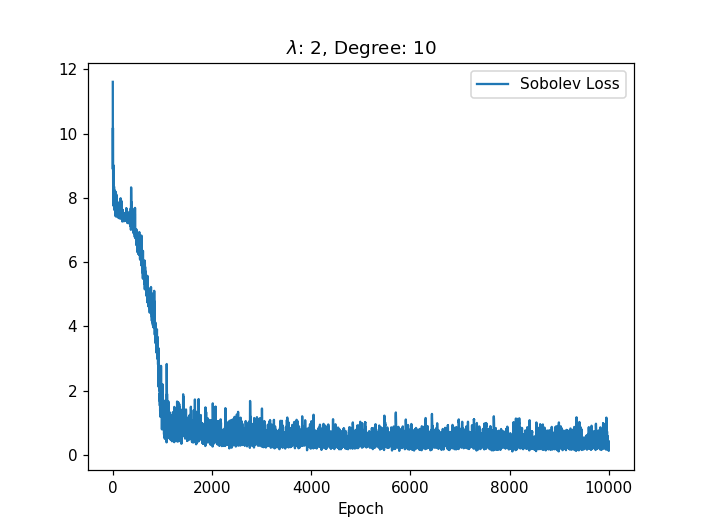

In [36]:
# %matplotlib notebook
#Produce plots
#!mkdir /Users/juanesteban/PhD_PINNs/Results_Simulation/27.04/
fig = plt.figure()
 #ax2 = fig.add_subplot(2, 1, 1)
#plt.plot(loss_1.numpy(), label='MSE Loss')
#plt.plot(loss_2.numpy(), label='Quadrature Loss')
plt.plot(loss_3.numpy(), label='Sobolev Loss')
plt.xlabel('Epoch')
#plt.ylabel('H1 Performance')
plt.title('$\lambda$: '+str(e_l)+', Degree: '+str(DEG))
plt.legend()
#plt.savefig(folder + 'MSE_quad_sob_bc_H2r_H1.png')
plt.show()

display## 

In [37]:
def pred_lam(deg, pinn):
    residual_set, res_weights , Hkw_res = Hk_coeff(deg,0)
    Xs = torch.Tensor(residual_set).T
    Xs.requires_grad = True
    lam = res_right(Xs,pinn(Xs)).dot(torch.Tensor(res_weights))/pinn(Xs).T[0].dot(torch.Tensor(res_weights))
    print(res_right(Xs,pinn(Xs)).dot(torch.Tensor(res_weights)))
    print(pinn(Xs).T[0].dot(torch.Tensor(res_weights)))
    return lam

In [38]:
x_t = np.linspace(lb[0], ub[0])
y_t = np.linspace(lb[1], ub[1])
t = 0
X_c = torch.tensor([[[i, j, t] for i in x_t] for j in y_t])
X_c1 = X_c.reshape(50*50,3)
X_c1.requires_grad = True
X_m,Y_m = np.meshgrid(x_t,y_t)

In [13]:
#print(schroedinger1d(X_c, pinn_1(X_c)))
pinn_1.load_model(folder+'best_model_Mse_'+str(DEG)+'_'+str(n_epoch)+'_.pt')
PRED_1 = pinn_1(X_c.float())
lam_pred = pred_lam(30,pinn_1)#torch.mean(torch.div(res_right(X_c1,pinn_1(X_c1.float())),
#                                pinn_1(X_c1.float())[:,0])).detach().numpy()
lam_pred = "{:.2f}".format(lam_pred)
fig = plt.figure()
ax = fig.gca(projection='3d')#fig.add_subplot(2, 1, 2, projection='3d')
c1 = ax.plot_surface(X_m, Y_m, PRED_1[:,:,0].detach().numpy(),label='Trained Psi',
                    color='blue')
c3 = ax.plot_wireframe(X_m, Y_m, Psi(X_m,Y_m,0,1),label ='Real Psi',color = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('$\lambda$: '+str(lam)+', Deg: '+str(DEG)+', $\lambda$_p: '+str(lam_pred))
#plt.savefig(folder + 'Final_dist_mse.png')
plt.show()


NameError: name 'pinn_1' is not defined

<IPython.core.display.Javascript object>


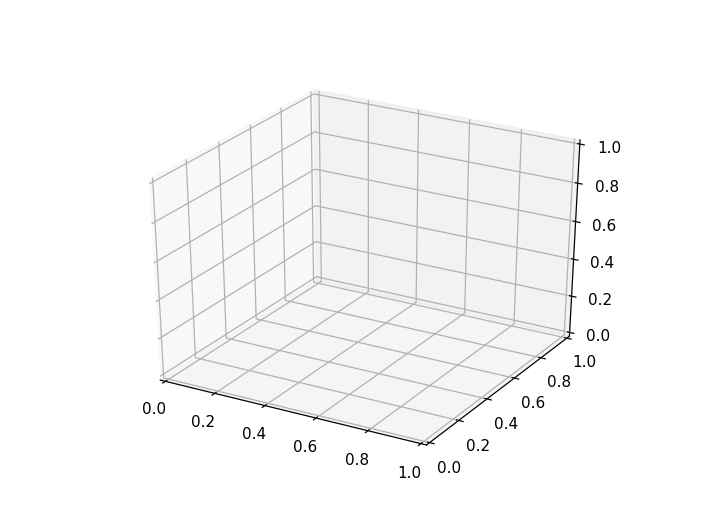

NameError: name 'pinn_1' is not defined

In [14]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ev_field = torch.div(res_right(X_c1,pinn_1(X_c1.float())),
                                pinn_1(X_c1.float())[:,0]).reshape(50,50).detach().numpy()
ax.plot_surface(X_m, Y_m, ev_field, label='Trained Psi_wass',
                    color='orange')
plt.savefig(folder + 'Eigenvalue_mse_'+str(DEG)+'_dist_H1.png')

In [16]:
pinn_2.load_model(folder+'best_model_Quad_'+str(DEG)+'_'+str(n_epoch)+'_.pt')
PRED_2 = pinn_2(X_c.float())
lam_pred = lam_pred = pred_lam(30,pinn_2)#torch.mean(torch.div(res_right(X_c1,pinn_2(X_c1.float())),
#                                pinn_2(X_c1.float())[:,0])).detach().numpy()
lam_pred = "{:.2f}".format(lam_pred)
fig = plt.figure()
ax = fig.gca(projection='3d')#
c2 = ax.plot_surface(X_m, Y_m, PRED_2[:, :, 0].detach().numpy(), label='Trained Psi_wass',
                    color='green')
c3 = ax.plot_wireframe(X_m, Y_m, Psi(X_m,Y_m,0,1),label ='Real Psi',color = 'red')
plt.title('$\lambda$: '+str(lam)+', Deg: '+str(DEG)+', $\lambda$_p: '+str(lam_pred))
#plt.savefig(folder + 'Final_dist_quad.png')
plt.show()


NameError: name 'pinn_2' is not defined

<IPython.core.display.Javascript object>


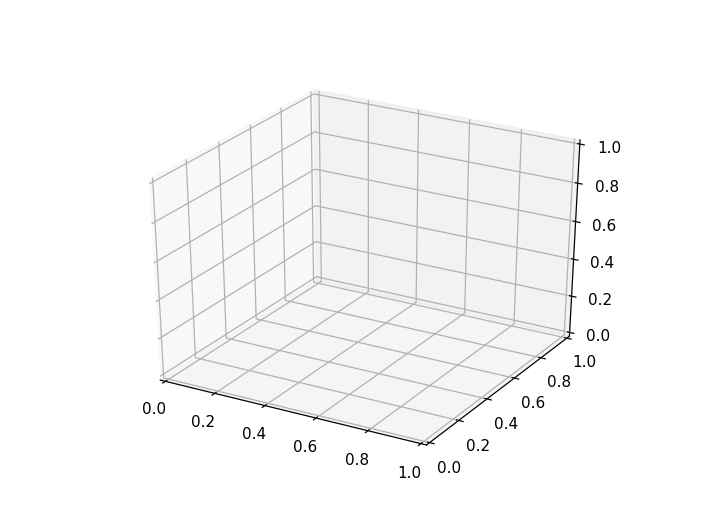

NameError: name 'pinn_2' is not defined

In [17]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ev_field = torch.div(res_right(X_c1,pinn_2(X_c1.float())),
                                pinn_2(X_c1.float())[:,0]).reshape(50,50).detach().numpy()
ax.plot_surface(X_m, Y_m, ev_field, label='Trained Psi_wass',
                    color='orange')
plt.savefig(folder + 'Eigenvalue_quad_'+str(DEG)+'_dist_H1.png')

tensor(0.0033, grad_fn=<DotBackward>)
tensor(0.0088, grad_fn=<DotBackward>)


<IPython.core.display.Javascript object>


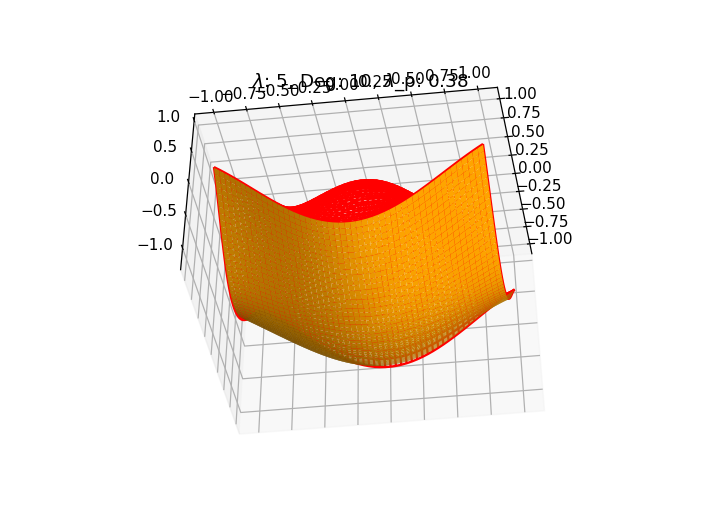

In [39]:
pinn_3.load_model(folder+'best_model_Wass_'+str(DEG)+'_'+str(n_epoch)+'_.pt')
PRED_3 = model_3(X_c.float())
lam_pred = lam_pred = pred_lam(30,pinn_3)#torch.median(torch.div(res_right(X_c1,pinn_3(X_c1.float())),
#                                pinn_3(X_c1.float())[:,0])).detach().numpy()
lam_pred = "{:.2f}".format(lam_pred)
fig = plt.figure()
ax = fig.gca(projection='3d')#
c2 = ax.plot_surface(X_m, Y_m, PRED_3[:, :, 0].detach().numpy(), label='Trained Psi_wass',
                    color='orange')
c3 = ax.plot_wireframe(X_m, Y_m, Psi(X_m,Y_m,1,e_l),label ='Real Psi',color = 'red')
plt.title('$\lambda$: '+str(lam)+', Deg: '+str(DEG)+', $\lambda$_p: '+str(lam_pred))
#plt.savefig(folder + 'Final_'+str(DEG)+'_dist_H1b_H2.png')
plt.show()


<IPython.core.display.Javascript object>


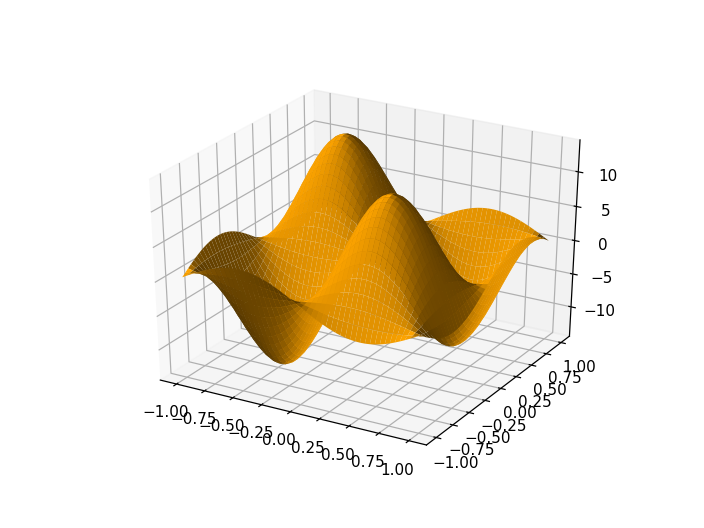

In [19]:
def Psi (x,y,t,e_l):
    x = torch.Tensor(x)
    y= torch.Tensor(y)
    Hn= Herm_pol(e_l)
    psi_t = torch.exp(torch.complex(torch.Tensor([0]),torch.Tensor([0])))
    return 1/((2**e_l*scipy.math.factorial(e_l))**(1/2))*(np.pi**(-1/4))*torch.exp(-(x**2+y**2)/2)*Hn(x)*Hn(y)
fig = plt.figure()
ax = fig.gca(projection='3d')
ev_field = #(Psi(X_m,Y_m,1,3)- Psi(X_m,Y_m,1,5)).detach().numpy()
ax.plot_surface(X_m, Y_m, ev_field, label='Trained Psi_wass',
                    color='orange')
plt.savefig(folder + 'Eigenvalue_dist_'+str(DEG)+'_dist_H1.png')

In [63]:
res_right(X_c1,pinn_3(X_c1.float())).reshape(50,50)


torch.Size([50, 50])

In [51]:
Psi(X_m,Y_m,1,e_l)

tensor([[0.3908, 0.3417, 0.2902,  ..., 0.2902, 0.3417, 0.3908],
        [0.3417, 0.2987, 0.2538,  ..., 0.2538, 0.2987, 0.3417],
        [0.2902, 0.2538, 0.2156,  ..., 0.2156, 0.2538, 0.2902],
        ...,
        [0.2902, 0.2538, 0.2156,  ..., 0.2156, 0.2538, 0.2902],
        [0.3417, 0.2987, 0.2538,  ..., 0.2538, 0.2987, 0.3417],
        [0.3908, 0.3417, 0.2902,  ..., 0.2902, 0.3417, 0.3908]])

<IPython.core.display.Javascript object>


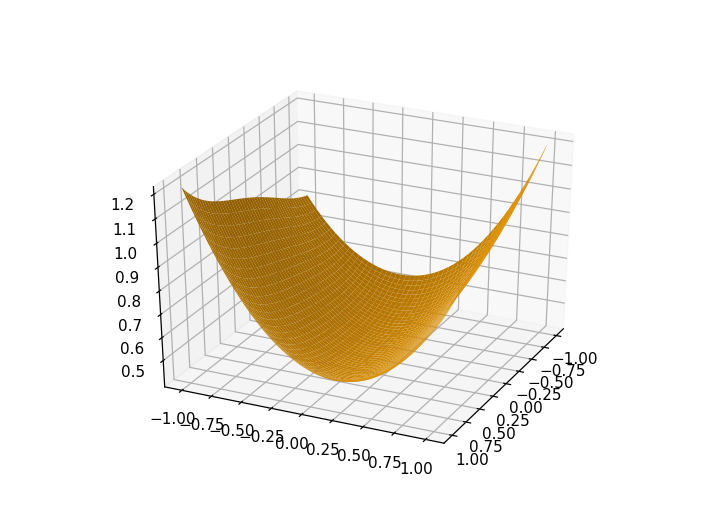

In [15]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ev_field = torch.div(res_right(X_c1,pinn_3(X_c1.float())),
                                pinn_3(X_c1.float())[:,0]).reshape(50,50).detach().numpy()
ax.plot_surface(X_m, Y_m, ev_field, label='Trained Psi_wass',
                    color='orange')
plt.savefig(folder + 'Eigenvalue_dist_'+str(DEG)+'_dist_H1.png')

<IPython.core.display.Javascript object>


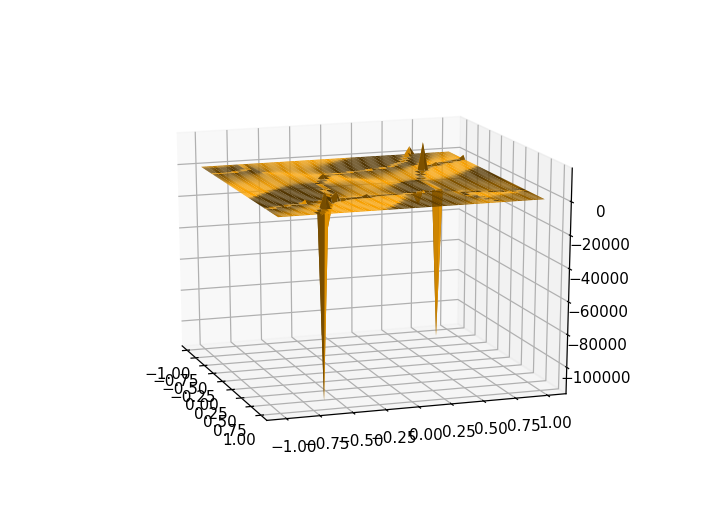

In [91]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ev_field = torch.div(res_right(X_c1,pinn_2(X_c1.float())),
                                pinn_2(X_c1.float())[:,0]).reshape(50,50).detach().numpy()
ax.plot_surface(X_m, Y_m, ev_field, label='Trained Psi_wass',
                    color='orange')